# Datathon V - Día 3 - MLOps

A continuación se detallan las actividades y puntos asignados para el reto de MLOps del Datathon V. Cada actividad tiene un puntaje específico y una evaluación que indica si se ha completado correctamente.

| **Actividad**                                                             | **Puntos**      | **Evaluación** |
| ------------------------------------------------------------------------- | --------------- | -------------- |
| **Tareas de Pipeline y MLFlow**                                           | **Total: 7**    |                |
| Crear un Pipeline de Scikit-Learn                                         | 0.5             | ✅            |
| Lanzar un servidor MLflow local                                           | 0.5             | ✅            |
| Entrenar y evaluar el modelo dentro de una ejecución de MLflow            | 0.5             | ✅            |
| Registrar el modelo y las métricas con MLflow                             | 0.5             | ✅            |
| Registrar el modelo en MLflow                                             | 0.5             | ✅            |
| Desplegar el modelo como una API REST (con Docker)                        | 2.0             | ✅            |
| Hacer predicciones usando la API REST                                     | 2.0             | ✅            |
| Subir las predicciones a la base de datos                                 | 0.5             | ✅            |
| **Código y Documentación**                                                | **Total: 1**    |               |
| Legibilidad del código                                                    | 0.5             | ✅            |
| Documentación en el notebook (títulos, subtítulos, texto)                 | 0.5             | ✅            |
| **Repositorio GIT**                                                       | **Total: 1**    |                |
| Incluir un archivo README.md completo                                     | 0.5             | ✅            |
| Uso de ramas para el desarrollo                                           | 0.5             | ✅            |
| **Puntos Extra (Bonus)**                                                  | **1 + Bonus**   |                |
| Explorar nuevas técnicas, modelos o productos                             | *Bonus*         | ✅              |
| Crear un pequeño artículo y promocionarlo                                 | *Bonus*         | ✅              |
| Cualquier otra iniciativa personal que mejore el proyecto                 | *Bonus*         | ✅              |
| **Evaluaciones Negativas**                                                | **Total: -9.0** |                  |
| Subir datos al repositorio                                                | -3.0            | ❌              |
| Subir contraseñas o información sensible                                  | -3.0            | ❌              |
| Subir archivos generados por MLflow (ej. `mlruns`)                        | -1.0            | ❌              |
| Faltan archivos estándar de Python (ej. `requirements.txt`, `.gitignore`) | -1.0            | ❌              |
| Un archivo README.md con mala presentación                                | -1.0            | ❌              |


**Notes**:
- Puntos Totales: 10 (sin contar los bonus ni los aspectos negativos).
- Los puntos extra pueden mejorar la puntuación, pero no permiten superar el máximo de 10 puntos.
- Las malas prácticas restan puntos.

## 1. Introducción

Lo primero: ¡Enhorabuena! 🎉 Si has llegado hasta aquí, quiere decir que te estas tomando tu formacion muy en serio. 

En este reto de MLOps, vamos a poner en práctica todo lo aprendido hasta ahora. El objetivo es desplegar un modelo registrado en MLFlow y hacer predicciones con él. Finalmente, subiremos los resultados a una base de datos para que puedan ser consultados durante la ultima fase del Datathon. Repasaremos el preprocesamiento de los datos y el entrenamiento del modelo dandole una vuelta: aprenderemos también a simplificar el procesamiento de los datos haciendo uso de un Pipeline de Scikit-Learn.

¿Listo/a? ¡Vamos a ello! 🚀

## 2. Obtención de los datos

En esta sección, vamos a cargar los datos desde la base de datos y vamos a convertir la serie temporal de ventas en un ejercicio Supervisado.

### 2.1 Cargar los datos desde la base de datos

Nos conectamos a la base de datos y ejecutamos una query para obtener los datos de ventas. Utilizamos la librería `pandas` para manejar los datos y `sqlalchemy` para conectarnos a la base de datos.

In [46]:
import sys 
print(sys.executable)

c:\Users\roger\anaconda3\envs\panaderia-datathon\python.exe


In [47]:
# Como en los anteriores notebooks, voy a importar varias dependencias
import polars as pl
import pandas as pd
import numpy as np

import os
from dotenv import load_dotenv  # He hecho archivo .env al inicio del proyecto

import plotly.express as px
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError

import sqlalchemy as sa
import sys

In [48]:
class DatabaseConnection:

    # Información necesaria para establecer la conexión a la BBDD
    def __init__(self):
        load_dotenv()  # Variables de entorno
        port = 3306  # Puerto por defecto de MySQL
        user = os.getenv("DB_USER")
        password = os.getenv("DB_PASSWORD")
        host = os.getenv("DB_HOST")
        db_name = os.getenv("DB_NAME") 
        self.engine = create_engine(
            f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db_name}"
        )
    def check_connection(self) -> bool:
        """Check if DB connection works"""
        try:
            with self.engine.connect() as conn:
                conn.execute(text("SELECT 1"))
            print("Conexión establecida correctamente.")
            return True
        except Exception as e:
            print(f"Error de conexión: {e}")
            return False
    def query_to_pandas(self, sql_query: str) -> pd.DataFrame:
        """Execute a query and get a Pandas"""
        try:
            with self.engine.connect() as conn:
                df = pd.read_sql_query(sql_query, conn)
            print("Consulta ejecutada correctamente (Pandas).")
            return df
        except SQLAlchemyError as e:
            print(f"Error SQLAlchemy: {e}")
            return None
        except Exception as e:
            print(f"Error inesperado: {e}")
            return None
    # En el notebook anterior hago esta función pero de query a Polars, en vista de los problemas que me ha dado, aqui ya usaré Pandas
    def insert_dataframe(self, df: pd.DataFrame, table_name: str) -> None:
        """Inserta un DataFrame de Pandas en la base de datos."""
        try:
            df.to_sql(table_name, self.engine, if_exists="replace", index=False)
            print(f"Tabla '{table_name}' insertada correctamente.")
        except Exception as e:
            print(f"Error insertando DataFrame: {e}")
    

Seteamos las Variables de Configuracion

In [49]:
# Seteadas en archivo .env

Conectamos con la base de datos

In [50]:
database = DatabaseConnection()
database.check_connection()

Conexión establecida correctamente.


True

Realizamos la consulta SQL para obtener los datos de ventas

In [51]:
query = """
    SELECT familia,
        articulo,
        fechaVenta AS fecha_venta,
        festivo,
        precio,
        cantidad,
        importe,
        orden_articulo_familia

    FROM ventas_diarias_estudio_completo
"""

# Obtenemos el DataFrame de la base de datos
df = database.query_to_pandas(query)

df.info()

Consulta ejecutada correctamente (Pandas).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10574 entries, 0 to 10573
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   familia                 10574 non-null  object 
 1   articulo                10574 non-null  object 
 2   fecha_venta             10574 non-null  object 
 3   festivo                 837 non-null    object 
 4   precio                  10574 non-null  float64
 5   cantidad                10574 non-null  float64
 6   importe                 10574 non-null  float64
 7   orden_articulo_familia  10574 non-null  int64  
dtypes: float64(3), int64(1), object(4)
memory usage: 661.0+ KB


In [52]:
# Pequeña comprobación para ver si devuelve resultados
if df is not None and not df.empty:
    print("Datos cargados correctamente:")
    display(df.head())
else:
    print("No se cargaron datos.")

Datos cargados correctamente:


familia articulo fecha_venta festivo  precio     cantidad       importe  \
0  BOLLERIA     3880  2021-05-01    None   2.591  3990.000000  10338.089966   
1  BOLLERIA     3960  2021-05-01    None   2.318  5628.000000  13045.703926   
2  BOLLERIA     5803  2021-05-01    None   2.727  3318.000000   9048.185730   
3  BOLLERIA     6286  2021-05-01    None   3.136  2310.000000   7244.160088   
4  BOLLERIA     6425  2021-05-01    None  31.364   444.149994  13930.309166   

   orden_articulo_familia  
0                       3  
1                       1  
2                       5  
3                       4  
4                       2

#### La mayoría de operaciones que hay que hacer ahora, las tengo hechas en el notebook03 de EDA (de Alba y Juan), aunque he usado Polars, así que voy a volver a realizar los siguientes pasos pero con Pandas

In [53]:
print(df.describe())

             precio      cantidad       importe  orden_articulo_familia
count  10574.000000  10574.000000  10574.000000            10574.000000
mean      15.414053   1927.631345   6475.291113                2.961982
std       17.003998   2074.303991   3838.170413                1.395454
min        0.865000     16.800001    126.000000                1.000000
25%        2.591000    210.000000   4030.425002                2.000000
50%        3.545000   1176.000000   5670.000000                3.000000
75%       34.091000   3066.000000   7975.171048                4.000000
max       43.500000  15540.000000  45807.019470                5.000000


In [54]:
# Compruebo las columnas que hay y sus tipos
print(df.columns)
print(df.dtypes)

Index(['familia', 'articulo', 'fecha_venta', 'festivo', 'precio', 'cantidad',
       'importe', 'orden_articulo_familia'],
      dtype='object')
familia                    object
articulo                   object
fecha_venta                object
festivo                    object
precio                    float64
cantidad                  float64
importe                   float64
orden_articulo_familia      int64
dtype: object


Convertimos las fechas a formato datetime y los artículos a tipo int

In [55]:
df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
df["articulo"] = df["articulo"].astype(int)

In [56]:
# Comprobación de tipos
print(df.dtypes)

familia                           object
articulo                           int64
fecha_venta               datetime64[ns]
festivo                           object
precio                           float64
cantidad                         float64
importe                          float64
orden_articulo_familia             int64
dtype: object


### 2.2 Filtramos para un solo producto

Hemos seleccionado el PRODUCT_ID 3960, pero podemos seleccionar cualquier otro producto.

In [57]:
# Voy a seleccionar el producto más vendido
top_sales_product = df.groupby("articulo")["cantidad"].sum().sort_values(ascending=False)
print(top_sales_product.head(1))

articulo
900    4600974.0
Name: cantidad, dtype: float64


In [58]:
# Hemos visto que el artículo 900 es el más vendido
PRODUCT_ID = 900

# Filtramos el DataFrame para el producto deseado
item_df = df.loc[df["articulo"] == PRODUCT_ID].copy()
print(item_df)

        familia  articulo fecha_venta          festivo  precio  cantidad  \
3737  PANADERIA       900  2021-05-01             None   0.865    9114.0   
3742  PANADERIA       900  2021-05-02  Día de la Madre   0.865   12096.0   
3747  PANADERIA       900  2021-05-03   Día de la Cruz   0.865    7770.0   
3752  PANADERIA       900  2021-05-04             None   0.865    6510.0   
3757  PANADERIA       900  2021-05-05             None   0.865    6048.0   
...         ...       ...         ...              ...     ...       ...   
7452  PANADERIA       900  2023-05-14             None   1.050    2940.0   
7457  PANADERIA       900  2023-05-15             None   1.050    2352.0   
7462  PANADERIA       900  2023-05-16             None   1.050    1302.0   
7467  PANADERIA       900  2023-05-17             None   1.050    1722.0   
7472  PANADERIA       900  2023-05-18             None   1.050    2058.0   

           importe  orden_articulo_familia  
3737   7883.609967                       3

Organizamos los datos por fecha y reiniciamos el índice

In [59]:
# Ordenamos por fecha de venta y reseteo del índice
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
display(item_df.head())

familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       900  2021-05-01             None   0.865    9114.0   
1  PANADERIA       900  2021-05-02  Día de la Madre   0.865   12096.0   
2  PANADERIA       900  2021-05-03   Día de la Cruz   0.865    7770.0   
3  PANADERIA       900  2021-05-04             None   0.865    6510.0   
4  PANADERIA       900  2021-05-05             None   0.865    6048.0   

        importe  orden_articulo_familia  
0   7883.609967                       3  
1  10463.040039                       3  
2   6721.050021                       3  
3   5631.150089                       3  
4   5231.519944                       3

### 2.3 Convertimos la serie a formato supervisado

Para poder predecir las ventas, necesitamos transformar los datos en un problema supervisado. Para ello vamos a:

- 👉 Obtener la `cantidad` contabilizada los días anteriores y añadirlos al día presente (shift).
- 👉 Obtener la `cantidad` contabilizada las semanas anteriores y añadirlos al día presente (shift).

👇 Para facilitar el proceso hemos diseñado una función que nos permite transformar la serie a formato supervisado. Esta función recibe como parámetros el dataframe, el número de días y semanas a considerar.

In [60]:
# Prácticamente he usado la misma función, algun "retoque" pero es la misma
def series_to_supervised(
    df: pd.DataFrame,
    target_column: str = "cantidad",
    daily_lag: int = 1,
    weekly_lag: int = 1,
    weekly_period: int = 7,  # Permite cambiar el periodo semanal si fuera necesario
) -> pd.DataFrame:
    """
    Converts a time series dataset into a supervised learning dataset.
    
    Args:
        data: Sequence of observations as a numpy array or DataFrame.
        daily_lag: Number of daily lag observations to include as inputs (X).
        weekly_lag: Number of weekly lag observations to include as inputs (X).
    
    Returns:
        Pandas DataFrame suitable for supervised learning.
    """
    final_df = df.copy()
    target_feature = final_df[target_column]

    # Función interna para crear los lags
    def create_shifted_feature(lag: int, frequency: int, freq_label: str):
        shifted_feature = target_feature.shift(lag * frequency)
        feature_name = f"{target_feature.name} (t-{lag} {freq_label})"
        final_df[feature_name] = shifted_feature

    # Add weekly lagged features
    for lag in range(weekly_lag, 0, -1):
        create_shifted_feature(lag, 7, "weeks")

    # Add daily lagged features
    for lag in range(daily_lag, 0, -1):
        create_shifted_feature(lag, 1, "days")

    return final_df

In [61]:
# Usamos la función con el artículo o ítem seleccionado

item_df_supervised = series_to_supervised(item_df, target_column="cantidad", daily_lag=6, weekly_lag=4)
display(item_df_supervised.head(10))

familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       900  2021-05-01             None   0.865    9114.0   
1  PANADERIA       900  2021-05-02  Día de la Madre   0.865   12096.0   
2  PANADERIA       900  2021-05-03   Día de la Cruz   0.865    7770.0   
3  PANADERIA       900  2021-05-04             None   0.865    6510.0   
4  PANADERIA       900  2021-05-05             None   0.865    6048.0   
5  PANADERIA       900  2021-05-06             None   0.865    6804.0   
6  PANADERIA       900  2021-05-07             None   0.865    8064.0   
7  PANADERIA       900  2021-05-08             None   0.865   11928.0   
8  PANADERIA       900  2021-05-09             None   0.865    9828.0   
9  PANADERIA       900  2021-05-10             None   0.865    5544.0   

        importe  orden_articulo_familia  cantidad (t-4 weeks)  \
0   7883.609967                       3                   NaN   
1  10463.040039                       3                   NaN   
2   6721.050021                       3                   NaN   
3   5631.150089                       3                   NaN   
4   5231.519944                       3                   NaN   
5   5885.460065                       3                   NaN   
6   6975.359933                       3                   NaN   
7  10317.720074                       3                   NaN   
8   8501.220014                       3                   NaN   
9   4795.560036                       3                   NaN   

   cantidad (t-3 weeks)  cantidad (t-2 weeks)  cantidad (t-1 weeks)  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   
5                   NaN                   NaN                   NaN   
6                   NaN                   NaN                   NaN   
7                   NaN                   NaN                9114.0   
8                   NaN                   NaN               12096.0   
9                   NaN                   NaN                7770.0   

   cantidad (t-6 days)  cantidad (t-5 days)  cantidad (t-4 days)  \
0                  NaN                  NaN                  NaN   
1                  NaN                  NaN                  NaN   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN               9114.0   
5                  NaN               9114.0              12096.0   
6               9114.0              12096.0               7770.0   
7              12096.0               7770.0               6510.0   
8               7770.0               6510.0               6048.0   
9               6510.0               6048.0               6804.0   

   cantidad (t-3 days)  cantidad (t-2 days)  cantidad (t-1 days)  
0                  NaN                  NaN                  NaN  
1                  NaN                  NaN               9114.0  
2                  NaN               9114.0              12096.0  
3               9114.0              12096.0               7770.0  
4              12096.0               7770.0               6510.0  
5               7770.0               6510.0               6048.0  
6               6510.0               6048.0               6804.0  
7               6048.0               6804.0               8064.0  
8               6804.0               8064.0              11928.0  
9               8064.0              11928.0               9828.0

## 3. Preprocesamiento de los datos

Hasta ahora en clase hemos visto como podemos modificar los datos de entrada para adaptarlos a los modelos. En este caso vamos a ir un paso más allá y vamos a **crear un Flujo de Transformacion de Datos (Data Pipeline)** que nos permita transformar los datos de entrada en un formato adecuado para el modelo.

Cuales son las transformaciones que vamos a realizar?

- 👉 **Extraer info de la fecha de venta**: el día, el mes, el año, el día de la semana y si es fin de semana o no.
- 👉 **Indicar si el día es festivo o no.**
- 👉 **Agregar informacion meteorológica**: temperatura, humedad, velocidad del viento y precipitaciones...


💡El uso de funciones nos permite reutilizar el codigo tantas veces como queramos.

### 3.1 Extraemos info de la fecha de venta

A traves de la fecha de venta vamos a crear las siguientes columnas:

- 👉 El día de la semana ( `dayofweek`)
- 👉 El día del mes (`day`)
- 👉 El mes (`month`)
- 👉 El año (`year`)
- 👉 Si es fin de semana o no (`weekend`)

In [62]:
# Añadimos columnas relacionadas con fechas
def add_date_columns(df: pd.DataFrame, date_column: str = "fecha_venta") -> pd.DataFrame:
    df = df.copy()    # Así evito modificar el original fuera de la función
    df["day"] = df[date_column].dt.day
    df["month"] = df[date_column].dt.month
    df["year"] = df[date_column].dt.year
    df["dayofweek"] = df[date_column].dt.dayofweek + 1 # Lunes=1...Domingo=7
    df["isWeekend"] = (df["dayofweek"] >= 6).astype(int)  # Entero preparado para ml
    
    
    return df

item_df_tmp = item_df.copy()
item_df_tmp = add_date_columns(item_df_tmp)
display(item_df_tmp.head())

familia  articulo fecha_venta          festivo  precio  cantidad  \
0  PANADERIA       900  2021-05-01             None   0.865    9114.0   
1  PANADERIA       900  2021-05-02  Día de la Madre   0.865   12096.0   
2  PANADERIA       900  2021-05-03   Día de la Cruz   0.865    7770.0   
3  PANADERIA       900  2021-05-04             None   0.865    6510.0   
4  PANADERIA       900  2021-05-05             None   0.865    6048.0   

        importe  orden_articulo_familia  day  month  year  dayofweek  \
0   7883.609967                       3    1      5  2021          6   
1  10463.040039                       3    2      5  2021          7   
2   6721.050021                       3    3      5  2021          1   
3   5631.150089                       3    4      5  2021          2   
4   5231.519944                       3    5      5  2021          3   

   isWeekend  
0          1  
1          1  
2          0  
3          0  
4          0

### 3.2 Indicamos si es festivo o no

Para ello sustituimos los valores de la columna `isHoliday` por `True` si el día es festivo y `False` si no lo es. A continuación, eliminamos la columna `festivo`, de tipo `str`, ya que no la vamos a necesitar.

In [63]:
# Añadimos la columna de si es festivo o no
def add_holiday_column(df: pd.DataFrame, holiday_column_name: str = "festivo") -> pd.DataFrame:
    df = df.copy()  # Sin modificar el original
    if holiday_column_name in df.columns:
        df["isHoliday"]  = ~df[holiday_column_name].isna()
        df["isHoliday"] = df["isHoliday"].astype(int)  # Entero (0/1)
        df.drop(columns=[holiday_column_name], inplace=True)
    return df

item_df_tmp = item_df.copy()
item_df_tmp = add_holiday_column(item_df_tmp)
display(item_df_tmp.head())

familia  articulo fecha_venta  precio  cantidad       importe  \
0  PANADERIA       900  2021-05-01   0.865    9114.0   7883.609967   
1  PANADERIA       900  2021-05-02   0.865   12096.0  10463.040039   
2  PANADERIA       900  2021-05-03   0.865    7770.0   6721.050021   
3  PANADERIA       900  2021-05-04   0.865    6510.0   5631.150089   
4  PANADERIA       900  2021-05-05   0.865    6048.0   5231.519944   

   orden_articulo_familia  isHoliday  
0                       3          0  
1                       3          1  
2                       3          1  
3                       3          0  
4                       3          0

### 3.3 Agregamos la información meteorológica

Utilizamos la API de meteostat para obtener los datos meteorológicos.

- 👉 Añadir las condiciones meteorológicas para las fechas en el dataframe
- 👉 Añadir una columna `rain` que indique si ese dia hubo o no lluvia (verdadero/falso).

In [64]:
# Establezco el código correcto para LOCATION con variables de entorno
def get_location_from_env(varname="LOCATION"):
    loc = os.getenv(varname)
    loc = loc.replace("(", "").replace(")", "").replace(" ", "")
    lat, lon = map(float, loc.split(","))
    return (lat, lon)

location = get_location_from_env()


In [65]:
# Añadimos información meteorológica con la API
from datetime import datetime
from meteostat import Point, Daily
import numpy as np


def get_weather_df(start: datetime, end: datetime, location: tuple[float, float]) -> pd.DataFrame:
    lat, lon = location
    point = Point(lat, lon)
    return Daily(point, start, end).fetch().fillna(0).reset_index()

def merge_dfs_by_column(df1: pd.DataFrame, df2: pd.DataFrame, col_1_name: str, col_2_name: str) -> pd.DataFrame:
    merged_df = df1.reset_index().merge(df2, left_on=col_1_name, right_on=col_2_name, how="inner").set_index("index")
    merged_df.index.name = None
    return merged_df

def add_rain_column(df: pd.DataFrame, precipitation_column_name: str = "prcp") -> pd.DataFrame:
    df = df.copy()
    rain_condition = df[precipitation_column_name] > 0
    df["isRaining"] = np.where(rain_condition, True, False)
    return df

def add_weather_columns(
    df: pd.DataFrame,
    location: tuple[float, float],   # He cambiado de int a float por si las coordenadas tuvieran decimales
    date_column_name: str = "fecha_venta",
) -> pd.DataFrame:
    start = df[date_column_name].min()
    end = df[date_column_name].max()
    weather_df = get_weather_df(start, end, location)
    weather_df = add_rain_column(weather_df)
    weather_df = merge_dfs_by_column(df, weather_df, date_column_name, "time")
    return weather_df

In [66]:
# Vemos el weather df

item_df_tmp = add_weather_columns(item_df_tmp, location)
display(item_df_tmp.head())

familia  articulo fecha_venta  precio  cantidad       importe  \
0  PANADERIA       900  2021-05-01   0.865    9114.0   7883.609967   
1  PANADERIA       900  2021-05-02   0.865   12096.0  10463.040039   
2  PANADERIA       900  2021-05-03   0.865    7770.0   6721.050021   
3  PANADERIA       900  2021-05-04   0.865    6510.0   5631.150089   
4  PANADERIA       900  2021-05-05   0.865    6048.0   5231.519944   

   orden_articulo_familia  isHoliday       time  tavg  tmin  tmax  prcp  snow  \
0                       3          0 2021-05-01  17.2  11.9  22.8   0.0   0.0   
1                       3          1 2021-05-02  16.3  10.8  23.2   0.0   0.0   
2                       3          1 2021-05-03  15.3  12.7  20.1   6.5   0.0   
3                       3          0 2021-05-04  16.5  12.0  20.9   0.0   0.0   
4                       3          0 2021-05-05  16.7  12.3  21.7   0.0   0.0   

   wdir  wspd  wpgt    pres  tsun  isRaining  
0   0.0  14.2   0.0  1014.0   0.0      False  
1   0.0  15.7   0.0  1015.9   0.0      False  
2   0.0   9.7   0.0  1017.7   0.0       True  
3   0.0  12.1   0.0  1018.0   0.0      False  
4   0.0  13.8   0.0  1016.5   0.0      False

In [67]:
item_df_tmp

familia  articulo fecha_venta  precio  cantidad       importe  \
0    PANADERIA       900  2021-05-01   0.865    9114.0   7883.609967   
1    PANADERIA       900  2021-05-02   0.865   12096.0  10463.040039   
2    PANADERIA       900  2021-05-03   0.865    7770.0   6721.050021   
3    PANADERIA       900  2021-05-04   0.865    6510.0   5631.150089   
4    PANADERIA       900  2021-05-05   0.865    6048.0   5231.519944   
..         ...       ...         ...     ...       ...           ...   
743  PANADERIA       900  2023-05-14   1.050    2940.0   3087.000047   
744  PANADERIA       900  2023-05-15   1.050    2352.0   2469.599961   
745  PANADERIA       900  2023-05-16   1.050    1302.0   1367.100021   
746  PANADERIA       900  2023-05-17   1.050    1722.0   1808.100015   
747  PANADERIA       900  2023-05-18   1.050    2058.0   2160.900032   

     orden_articulo_familia  isHoliday       time  tavg  tmin  tmax  prcp  \
0                         3          0 2021-05-01  17.2  11.9  22.8   0.0   
1                         3          1 2021-05-02  16.3  10.8  23.2   0.0   
2                         3          1 2021-05-03  15.3  12.7  20.1   6.5   
3                         3          0 2021-05-04  16.5  12.0  20.9   0.0   
4                         3          0 2021-05-05  16.7  12.3  21.7   0.0   
..                      ...        ...        ...   ...   ...   ...   ...   
743                       3          0 2023-05-14  19.4  14.1  25.5   0.0   
744                       3          0 2023-05-15  23.8  15.9  32.0   0.0   
745                       3          0 2023-05-16  22.3  17.8  26.2   0.0   
746                       3          0 2023-05-17  19.2  17.2  23.0   0.0   
747                       3          0 2023-05-18  17.0  13.7  22.3  13.3   

     snow  wdir  wspd  wpgt    pres  tsun  isRaining  
0     0.0   0.0  14.2   0.0  1014.0   0.0      False  
1     0.0   0.0  15.7   0.0  1015.9   0.0      False  
2     0.0   0.0   9.7   0.0  1017.7   0.0       True  
3     0.0   0.0  12.1   0.0  1018.0   0.0      False  
4     0.0   0.0  13.8   0.0  1016.5   0.0      False  
..    ...   ...   ...   ...     ...   ...        ...  
743   0.0   0.0  12.6  31.5  1018.2   0.0      False  
744   0.0   0.0  15.5  33.3  1015.5   0.0      False  
745   0.0   0.0  17.6  31.5  1013.0   0.0      False  
746   0.0   0.0   9.5  27.8  1013.4   0.0      False  
747   0.0   0.0  14.3  27.8  1016.2   0.0       True  

[748 rows x 20 columns]

## 4. Creación del Pipeline 

Sklearn nos permite crear un Pipeline de Transformación de Datos que nos permite aplicar las transformaciones de manera secuencial. Al final del pipeline incluiríamos el modelo de Machine Learning que queremos utilizar. De esta manera, podemos aplicar las transformaciones de manera automática cada vez que entrenamos el modelo. Aumentamos la reusabilidad del código y la legibilidad del mismo. Los pasos del pipeline son:

1. Aplicar las transformaciones de los datos de entrada.
2. Normalizar los datos de entrada utilizando OneHotEncoder y MinMaxScaler.
3. Rellenar los valores nulos calculando la media de cada columna.
4. Incluir un modelo de Machine Learning al final del pipeline.
5. Normalizar la variable objetivo (target) utilizando MinMaxScaler.

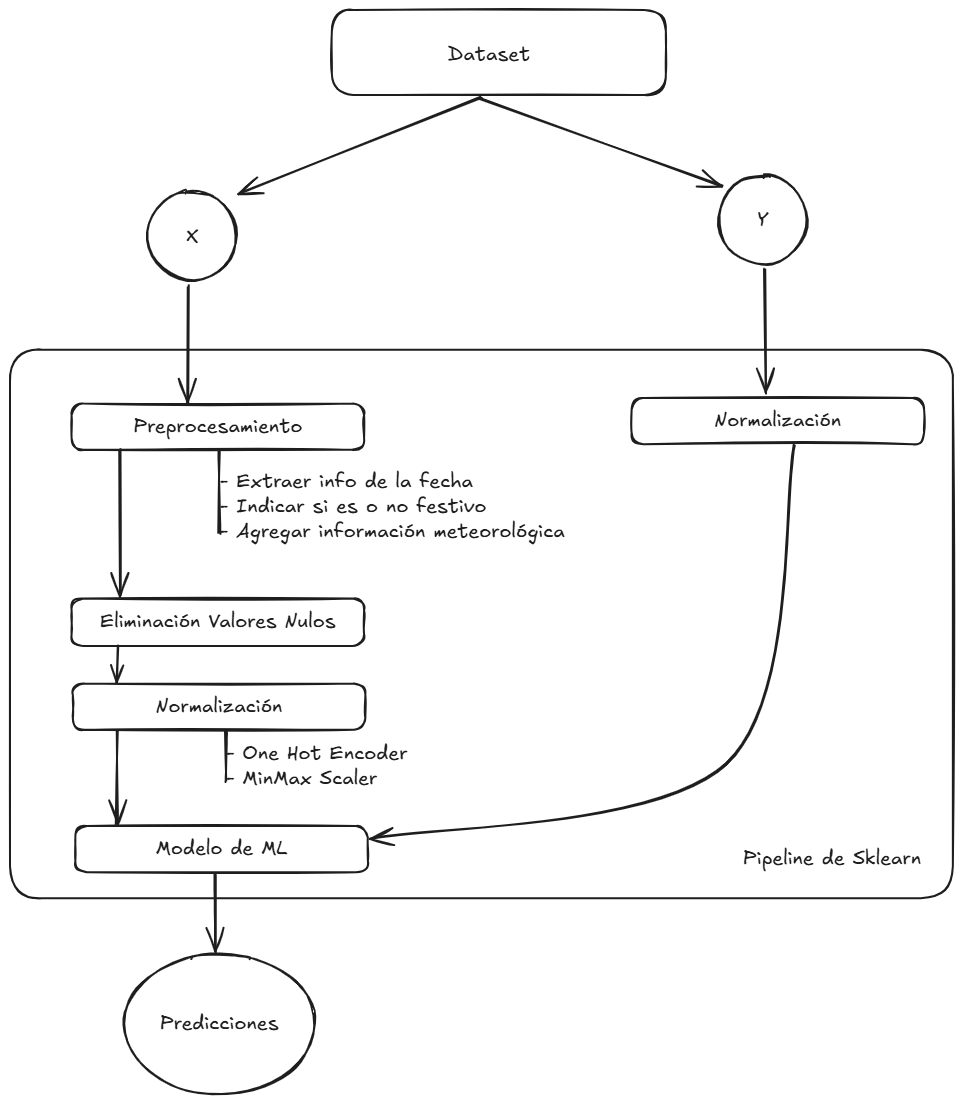

### 4.1 Paso 1: Preprocesamiento de los datos de entrada

Agregamos todas las transformaciones que hemos desarrollado en la sección anterior en un Pipeline de Transformación de Datos.

In [68]:
# Pipeline de transformación de datos
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

class PreprocessTransformer(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self, location: tuple[float, float]):
        self.location = location

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        # No necesita que aprenda nada, solamente devuelve self
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X = add_date_columns(X)
        X = add_holiday_column(X)
        X = add_weather_columns(X, location=self.location)
        return X
       

In [69]:
# Probamos la función
preprocessor = PreprocessTransformer(location=location)
df_preprocessed = preprocessor.fit_transform(item_df_supervised)
display(df_preprocessed.head())

familia  articulo fecha_venta  precio  cantidad       importe  \
0  PANADERIA       900  2021-05-01   0.865    9114.0   7883.609967   
1  PANADERIA       900  2021-05-02   0.865   12096.0  10463.040039   
2  PANADERIA       900  2021-05-03   0.865    7770.0   6721.050021   
3  PANADERIA       900  2021-05-04   0.865    6510.0   5631.150089   
4  PANADERIA       900  2021-05-05   0.865    6048.0   5231.519944   

   orden_articulo_familia  cantidad (t-4 weeks)  cantidad (t-3 weeks)  \
0                       3                   NaN                   NaN   
1                       3                   NaN                   NaN   
2                       3                   NaN                   NaN   
3                       3                   NaN                   NaN   
4                       3                   NaN                   NaN   

   cantidad (t-2 weeks)  ...  tmin  tmax  prcp  snow  wdir  wspd  wpgt  \
0                   NaN  ...  11.9  22.8   0.0   0.0   0.0  14.2   0.0   
1                   NaN  ...  10.8  23.2   0.0   0.0   0.0  15.7   0.0   
2                   NaN  ...  12.7  20.1   6.5   0.0   0.0   9.7   0.0   
3                   NaN  ...  12.0  20.9   0.0   0.0   0.0  12.1   0.0   
4                   NaN  ...  12.3  21.7   0.0   0.0   0.0  13.8   0.0   

     pres  tsun  isRaining  
0  1014.0   0.0      False  
1  1015.9   0.0      False  
2  1017.7   0.0       True  
3  1018.0   0.0      False  
4  1016.5   0.0      False  

[5 rows x 35 columns]

In [70]:
# Check columnas
df_preprocessed.columns

Index(['familia', 'articulo', 'fecha_venta', 'precio', 'cantidad', 'importe',
       'orden_articulo_familia', 'cantidad (t-4 weeks)',
       'cantidad (t-3 weeks)', 'cantidad (t-2 weeks)', 'cantidad (t-1 weeks)',
       'cantidad (t-6 days)', 'cantidad (t-5 days)', 'cantidad (t-4 days)',
       'cantidad (t-3 days)', 'cantidad (t-2 days)', 'cantidad (t-1 days)',
       'day', 'month', 'year', 'dayofweek', 'isWeekend', 'isHoliday', 'time',
       'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'tsun', 'isRaining'],
      dtype='object')

### 4.2 Paso 2: Eliminar los valores nulos

En este paso simplemente rellenamos los valores nulos calculando la media de cada columna.

In [71]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

# Solo columnas numéricas
numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

# Imputador de la media
nans_remover = SimpleImputer(strategy="mean")

# ColumnTransformer para aplicar el imputador solo a las numéricas
remove_nans_transformer = ColumnTransformer(
    transformers=[
        ("RemoveNans", nans_remover, numerical_features),
    ],
    remainder="passthrough"   # Deja el resto de columnas como estan
)


In [72]:
# Probamos
df_no_nans = remove_nans_transformer.fit_transform(df_preprocessed)

# Aquí el resultado es un array de numpy, no un DataFrame (muchos errores de este tipo préviamente)
df_no_nans = pd.DataFrame(
    df_no_nans,
    columns=remove_nans_transformer.get_feature_names_out()
)

df_no_nans.head()


RemoveNans__articulo RemoveNans__precio RemoveNans__cantidad  \
0                900.0              0.865               9114.0   
1                900.0              0.865              12096.0   
2                900.0              0.865               7770.0   
3                900.0              0.865               6510.0   
4                900.0              0.865               6048.0   

  RemoveNans__importe RemoveNans__orden_articulo_familia  \
0         7883.609967                                3.0   
1        10463.040039                                3.0   
2         6721.050021                                3.0   
3         5631.150089                                3.0   
4         5231.519944                                3.0   

  RemoveNans__cantidad (t-4 weeks) RemoveNans__cantidad (t-3 weeks)  \
0                      6268.266667                      6234.082531   
1                      6268.266667                      6234.082531   
2                      6268.266667                      6234.082531   
3                      6268.266667                      6234.082531   
4                      6268.266667                      6234.082531   

  RemoveNans__cantidad (t-2 weeks) RemoveNans__cantidad (t-1 weeks)  \
0                      6209.820163                      6189.190283   
1                      6209.820163                      6189.190283   
2                      6209.820163                      6189.190283   
3                      6209.820163                      6189.190283   
4                      6209.820163                      6189.190283   

  RemoveNans__cantidad (t-6 days)  ... RemoveNans__pres RemoveNans__tsun  \
0                     6183.169811  ...           1014.0              0.0   
1                     6183.169811  ...           1015.9              0.0   
2                     6183.169811  ...           1017.7              0.0   
3                     6183.169811  ...           1018.0              0.0   
4                     6183.169811  ...           1016.5              0.0   

  remainder__familia remainder__fecha_venta remainder__day remainder__month  \
0          PANADERIA             2021-05-01              1                5   
1          PANADERIA             2021-05-02              2                5   
2          PANADERIA             2021-05-03              3                5   
3          PANADERIA             2021-05-04              4                5   
4          PANADERIA             2021-05-05              5                5   

  remainder__year remainder__dayofweek remainder__time remainder__isRaining  
0            2021                    6      2021-05-01                False  
1            2021                    7      2021-05-02                False  
2            2021                    1      2021-05-03                 True  
3            2021                    2      2021-05-04                False  
4            2021                    3      2021-05-05                False  

[5 rows x 35 columns]

In [73]:
# A colación con el tipado np.array que nos dan devuelve algunas funciones, establezco una función para automatizar

def transformer_output_to_df(transformer, array, index=None):
    """
    Convierte la salida de un transformer de sklearn a un DataFrame de pandas
    con los nombres de columnas correctos.
    
    Args:
        transformer: el transformer fitted (por ejemplo, ColumnTransformer).
        array: numpy array (output de transformer.transform o fit_transform).
        index: (opcional) el índice a usar para el DataFrame (por defecto None).
    
    Returns:
        pd.DataFrame
    """
    columns = transformer.get_feature_names_out()
    return pd.DataFrame(array, columns=columns, index=index)

# Así queda automatizado por si necesitamos la función más adelante

In [74]:
type(df_no_nans)

pandas.core.frame.DataFrame

### 4.3 Paso 3: Normalización de los datos de entrada

Usamos `OneHotEncoder` para las variables categoricas y `MinMaxScaler`. para las variables numéricas.

In [75]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector

categorical_features = make_column_selector(dtype_include=[object, np.int32])
numerical_features = make_column_selector(dtype_include=[np.float64])
# He añadido variables categóricas porque veo que me ayudaran en la estacionalidad

# Variables de preprocesamiento
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
minmax_scaler = MinMaxScaler(feature_range=(0, 1))

encoders_transformer = ColumnTransformer(
    transformers=[
        ("OneHotEncoder", ohe_encoder, categorical_features),
        ("MinMaxScaler", minmax_scaler, numerical_features),
    ],
    remainder="drop"    # Por si queremos conservar solo las variables codificadas o escaladas
)

### 4.4 Incluimos el modelo de Machine Learning

Como nos encontramos en un problema de regresión, vamos a utilizar un modelo de regresión. En este caso, vamos a utilizar el modelo `LinearRegression` de Scikit-Learn.

In [76]:
# Asignamos model al modelo elegido
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model
# De momento LinearRegression, posteriormente veremos si es el mejor modelo

LinearRegression()

### 4.5 Creamos el pipeline para las variables de entrada

Agregamos los pasos anteriores al pipeline de transformación de datos de forma secuencial. El pipeline se encargará de aplicar las transformaciones a los datos de entrada y de entrenar el modelo.

In [77]:
# No cambio nada en esta celda, definimos el pipeline 
from sklearn.pipeline import Pipeline


input_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("model", model),
    ]
)

input_pipeline.set_output(transform="pandas")

Pipeline(steps=[('preprocessor',
                 PreprocessTransformer(location=(36.721477644071705,
                                                 -4.363132134392174))),
                ('nan_remover',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('RemoveNans', SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AF733D6F50>)])),
                ('data_encoding',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AF76A55710>),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AF71709A50>)])),
                ('model', LinearRegression())])

### 4.6 Paso 5: Normalizamos la variable objetivo

En ultimo paso, usamos el mismo `OneHotEncoder` utilizado para los datos de entrada para codificar la variable objetivo (target), pero sin ajustarlo nuevamente. Esto asegura que la variable objetivo esté en el mismo formato que los datos de entrada, facilitando así la predicción y evaluación del modelo.

In [78]:
# Dejamos la celda igual también
from sklearn.compose import TransformedTargetRegressor


target_feature_scaler = MinMaxScaler(feature_range=(0,1))
final_pipeline = TransformedTargetRegressor(
    regressor=input_pipeline,
    transformer=target_feature_scaler,
)
final_pipeline

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      PreprocessTransformer(location=(36.721477644071705,
                                                                                      -4.363132134392174))),
                                                     ('nan_remover',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('RemoveNans',
                                                                                       SimpleImputer(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000002AF733D6F50>)])),
                                                     ('data_encoding',
                                                      C...sformers=[('OneHotEncoder',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000002AF76A55710>),
                                                                                      ('MinMaxScaler',
                                                                                       MinMaxScaler(),
                                                                                       <sklearn.compose._column_transformer.make_column_selector object at 0x000002AF71709A50>)])),
                                                     ('model',
                                                      LinearRegression())]),
                           transformer=MinMaxScaler())

## 5. Entrenamos el modelo

Utilizamos el pipeline creado anteriormente para entrenar el modelo. Marcamos el horizonte de tiempo del conjunto de test a 30 días. Esto significa que el modelo se evaluará con los datos de los últimos 30 días y se entrenará con los datos previos a dicho horizonte. Elegimos un solo producto para simplificar el proceso de entrenamiento y evaluación del modelo.

In [79]:
# Vamos a entrenar el modelo con el producto más vendido como he declarado anteriormente
PRODUCT_ID = 900

item_mask = df["articulo"] == PRODUCT_ID
item_df = df[item_mask].copy()
item_df.head()

familia  articulo fecha_venta          festivo  precio  cantidad  \
3737  PANADERIA       900  2021-05-01             None   0.865    9114.0   
3742  PANADERIA       900  2021-05-02  Día de la Madre   0.865   12096.0   
3747  PANADERIA       900  2021-05-03   Día de la Cruz   0.865    7770.0   
3752  PANADERIA       900  2021-05-04             None   0.865    6510.0   
3757  PANADERIA       900  2021-05-05             None   0.865    6048.0   

           importe  orden_articulo_familia  
3737   7883.609967                       3  
3742  10463.040039                       3  
3747   6721.050021                       3  
3752   5631.150089                       3  
3757   5231.519944                       3

Guardamos la familia a la que pertenece el producto para guardarlo como tag en MLFlow

In [80]:
# Guardamos familia
item_df = item_df.reset_index(drop=True)
product_family = item_df["familia"][0]
product_family


'PANADERIA'

In [81]:
item_df

familia  articulo fecha_venta          festivo  precio  cantidad  \
0    PANADERIA       900  2021-05-01             None   0.865    9114.0   
1    PANADERIA       900  2021-05-02  Día de la Madre   0.865   12096.0   
2    PANADERIA       900  2021-05-03   Día de la Cruz   0.865    7770.0   
3    PANADERIA       900  2021-05-04             None   0.865    6510.0   
4    PANADERIA       900  2021-05-05             None   0.865    6048.0   
..         ...       ...         ...              ...     ...       ...   
743  PANADERIA       900  2023-05-14             None   1.050    2940.0   
744  PANADERIA       900  2023-05-15             None   1.050    2352.0   
745  PANADERIA       900  2023-05-16             None   1.050    1302.0   
746  PANADERIA       900  2023-05-17             None   1.050    1722.0   
747  PANADERIA       900  2023-05-18             None   1.050    2058.0   

          importe  orden_articulo_familia  
0     7883.609967                       3  
1    10463.040039                       3  
2     6721.050021                       3  
3     5631.150089                       3  
4     5231.519944                       3  
..            ...                     ...  
743   3087.000047                       3  
744   2469.599961                       3  
745   1367.100021                       3  
746   1808.100015                       3  
747   2160.900032                       3  

[748 rows x 8 columns]

### 5.1 Pequeña limpieza previa de los datos

Eliminamos las columnas que no vamos a utilizar

In [82]:
# Pequeño ajuste por si alguna columna no existe al re-ejecutar el notebook varias veces
item_df.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True)
print(item_df.head())
print(item_df.tail())


  fecha_venta          festivo  precio  cantidad
0  2021-05-01             None   0.865    9114.0
1  2021-05-02  Día de la Madre   0.865   12096.0
2  2021-05-03   Día de la Cruz   0.865    7770.0
3  2021-05-04             None   0.865    6510.0
4  2021-05-05             None   0.865    6048.0
    fecha_venta festivo  precio  cantidad
743  2023-05-14    None    1.05    2940.0
744  2023-05-15    None    1.05    2352.0
745  2023-05-16    None    1.05    1302.0
746  2023-05-17    None    1.05    1722.0
747  2023-05-18    None    1.05    2058.0


Reorganizamos el dataframe para que el orden de las fechas sea ascendente

In [83]:
# Nos aseguramos de las fechas sean ascendentes
item_df.sort_values("fecha_venta", inplace=True)
item_df.reset_index(inplace=True, drop=True)
print(item_df.head())
print(item_df.tail())

  fecha_venta          festivo  precio  cantidad
0  2021-05-01             None   0.865    9114.0
1  2021-05-02  Día de la Madre   0.865   12096.0
2  2021-05-03   Día de la Cruz   0.865    7770.0
3  2021-05-04             None   0.865    6510.0
4  2021-05-05             None   0.865    6048.0
    fecha_venta festivo  precio  cantidad
743  2023-05-14    None    1.05    2940.0
744  2023-05-15    None    1.05    2352.0
745  2023-05-16    None    1.05    1302.0
746  2023-05-17    None    1.05    1722.0
747  2023-05-18    None    1.05    2058.0


Convertimos la serie a formato supervisado

In [84]:
# Usamos la función series_to_supervised con el artículo
item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)
print(item_df.head())
print(item_df.tail())


  fecha_venta          festivo  precio  cantidad  cantidad (t-4 weeks)  \
0  2021-05-01             None   0.865    9114.0                   NaN   
1  2021-05-02  Día de la Madre   0.865   12096.0                   NaN   
2  2021-05-03   Día de la Cruz   0.865    7770.0                   NaN   
3  2021-05-04             None   0.865    6510.0                   NaN   
4  2021-05-05             None   0.865    6048.0                   NaN   

   cantidad (t-3 weeks)  cantidad (t-2 weeks)  cantidad (t-1 weeks)  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   cantidad (t-6 days)  cantidad (t-5 days)  cantidad (t-4 days)  \
0                  NaN                  NaN                 

In [85]:
# Compruebo las columnas (checkeo por si parece que esté todo correcto)
print(item_df)

    fecha_venta          festivo  precio  cantidad  cantidad (t-4 weeks)  \
0    2021-05-01             None   0.865    9114.0                   NaN   
1    2021-05-02  Día de la Madre   0.865   12096.0                   NaN   
2    2021-05-03   Día de la Cruz   0.865    7770.0                   NaN   
3    2021-05-04             None   0.865    6510.0                   NaN   
4    2021-05-05             None   0.865    6048.0                   NaN   
..          ...              ...     ...       ...                   ...   
743  2023-05-14             None   1.050    2940.0                2688.0   
744  2023-05-15             None   1.050    2352.0                3276.0   
745  2023-05-16             None   1.050    1302.0                2856.0   
746  2023-05-17             None   1.050    1722.0                2184.0   
747  2023-05-18             None   1.050    2058.0                2226.0   

     cantidad (t-3 weeks)  cantidad (t-2 weeks)  cantidad (t-1 weeks)  \
0             

### 5.2 Dividimos en conjuntos de entrenamiento y test

In [86]:
# train/test del artículo 900
horizont = datetime(2023,4,19)

df_train = item_df[item_df["fecha_venta"] < horizont]
df_test = item_df[item_df["fecha_venta"] >= horizont]

print("Train set size:", df_train.shape[0])
print("Test set size:", df_test.shape[0])
print("Primer día test:", df_test["fecha_venta"].min())
print("Último día test:", df_test["fecha_venta"].max())

print("Primer día train:", df_train["fecha_venta"].min())
print("Último día train:", df_train["fecha_venta"].max())



X_train = df_train.drop(columns=["cantidad"])
y_train = df_train["cantidad"]
X_test = df_test.drop(columns=["cantidad"])
y_test = df_test["cantidad"]

Train set size: 718
Test set size: 30
Primer día test: 2023-04-19 00:00:00
Último día test: 2023-05-18 00:00:00
Primer día train: 2021-05-01 00:00:00
Último día train: 2023-04-18 00:00:00


### 5.3 Iniciar el servidor de MLFlow

- 👉 Lanzar un servidor MLFlow local
- 👉 Conectarse al servidor MLFlow local
- 👉 Establecer el experimento deseado
- 👉 Habilitar el autologging de MLFlow para sklearn

In [87]:
# Errores con el "pip install mflow", así compruebo el Python que estoy usando
import sys
print(sys.executable)

c:\Users\roger\anaconda3\envs\panaderia-datathon\python.exe


In [88]:
import mlflow


In [89]:
# Connect to MLFlow server hosted locally
MLFLOW_EXPERIMENT_NAME = "Panaderia-Datathon"
MLFLOW_TRACKING_URI = "http://localhost:5000"


mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.sklearn.autolog()

2025/07/29 09:40:25 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 1.3.0 <= scikit-learn <= 1.7.0, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


### 5.4 Entrenamos y evaluamos el modelo

La siguiente sección consiste en entrenar y evaluar el modelo. Veremos como al utilizar el pipeline se simplifica el proceso de entrenamiento y evaluación del modelo. 

💡 El autolog registrará automáticamente las métricas y el modelo

In [90]:
# He añadido dos métricas más, el mse y el r2 score
from sklearn import metrics


with mlflow.start_run() as run:

    mlflow.set_tag("product_family", product_family)
    mlflow.set_tag("product_id", PRODUCT_ID)

    final_pipeline.fit(X_train, y_train)
    y_pred = final_pipeline.predict(X_test)

    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = metrics.root_mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    

    mlflow.log_metric('mae', mae)
    mlflow.log_metric('mse', mse)
    mlflow.log_metric('rmse', rmse)
    mlflow.log_metric('r2', r2)

    print(f"MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

MAE: 1165.35 | MSE: 1811603.32 | RMSE: 1345.96 | R2: 0.178
🏃 View run sedate-shrike-477 at: http://localhost:5000/#/experiments/240983069707345815/runs/2dccc6b65a534ae2a5aa310905eef94a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815


### 5.5 Creamos graficos de resultados

Mostramos la diferencia entre las ventas reales y las predicciones

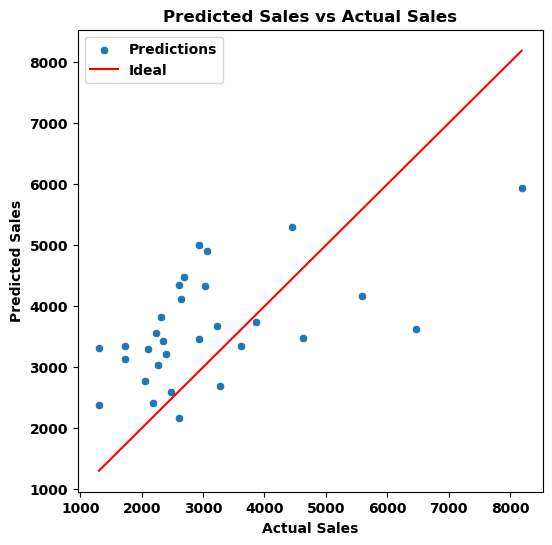

In [91]:
# Observamos las ventas reales con las predicciones
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Actual Sales")
ax.set_ylabel("Predicted Sales")

# Scatter plot (real vs predict)
sns.scatterplot(x=y_test.values, y=y_pred, ax=ax, label="Predictions")

# Línea ideal (y=x)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
sns.lineplot(x=lims, y=lims, color="red", ax=ax, label="Ideal")

# Save to mlartifacts
fig_path = '../mlartifacts/predictions_vs_ground_truth_article900.png'
plt.savefig(fig_path)
plt.show()


mlflow.log_artifact(fig_path)

Mostramos la diferencia entre las ventas reales y las predicciones a lo largo del tiempo

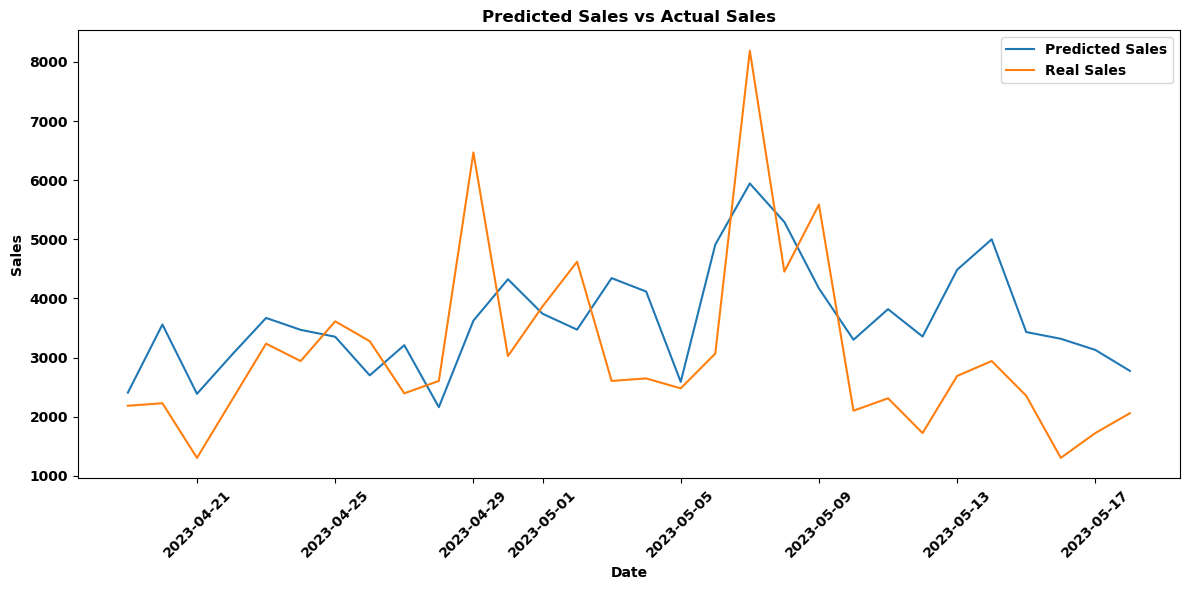

In [92]:
# Diferencia clara en el gráfico en ventas reales y predicciones
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

dates = df_test["fecha_venta"]

sns.lineplot(x=dates, y=y_pred, label="Predicted Sales", ax=ax)
sns.lineplot(x=dates, y=y_test, label="Real Sales", ax=ax)

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()

# Save to MLFlow last run
fig_path = '../mlartifacts/predictions_vs_ground_truth_article900_timeline.png'
plt.savefig(fig_path)
plt.show()
mlflow.log_artifact(fig_path)

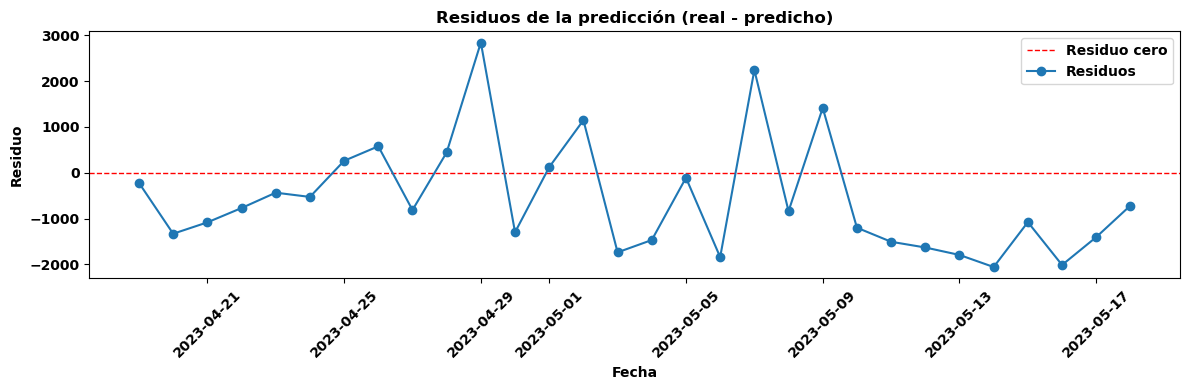

In [93]:
# Vamos a hacer un plot de residuos para ver que sesgo tiene el modelo, si sobrestima o subestima

# Calculamos residuos
residuos = y_test.values - y_pred

# Gráfico de residuos por fecha
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Residuos de la predicción (real - predicho)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Residuo")

ax.axhline(0, color="red", linestyle="--", lw=1, label="Residuo cero")
ax.plot(df_test["fecha_venta"], residuos, marker="o", label="Residuos")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

fig_path = "../mlartifacts/residuos_article900_tiempo.png"
plt.savefig(fig_path)
plt.show()
mlflow.log_artifact(fig_path)

## Análisis de Resultados – Producto 900

A continuación, se analizan los resultados obtenidos al aplicar un modelo de regresión lineal sobre la serie de ventas del producto 900. Se muestran tres gráficos clave para evaluar el desempeño del modelo: **scatterplot predicción vs realidad**, **evolución temporal de las ventas** y **residuos de predicción**.

---

### 1. Scatterplot: Predicted Sales vs Actual Sales

![Scatterplot](../mlartifacts/predictions_vs_ground_truth.png)

- Cada punto representa un día del conjunto de test, comparando la venta real (eje X) con la predicha por el modelo (eje Y).
- La **línea roja** indica la predicción perfecta (y = x).  
- **Observación:** La mayoría de los puntos se sitúan por debajo de la línea ideal, lo que indica que el modelo tiende a **sobreestimar** las ventas reales en la mayoría de los días. Además, se observa dispersión, especialmente en días con ventas bajas o muy altas, lo que refleja cierta dificultad del modelo para capturar los extremos de la serie.

---

### 2. Evolución temporal: Predicción vs Realidad

![Lineplot](../mlartifacts/predictions_vs_ground_truth_timeline.png)

- Este gráfico muestra la evolución temporal de las ventas reales y las predicciones del modelo a lo largo de las fechas del conjunto de test.
- **Observación:** El modelo sigue razonablemente bien la tendencia general de la serie, pero “suaviza” los picos y valles. Es decir, no es capaz de captar completamente las subidas o bajadas abruptas de las ventas, lo que es un comportamiento típico de los modelos lineales en series con alta volatilidad o estacionalidad.

---

### 3. Residuos: Real – Predicho

![Residuos](../mlartifacts/residuos_tiempo.png)

- El gráfico de residuos muestra la diferencia entre las ventas reales y las predichas para cada día.
- **Observación:** Se observa que el modelo tiende a **sobreestimar las ventas** (residuos negativos) en la última parte de la serie, mientras que en algunos días subestima (residuos positivos), sobre todo en los picos. La magnitud de los errores es variable y no completamente aleatoria, lo que sugiere que hay patrones que el modelo no logra capturar adecuadamente.

---

**Conclusión rápida:**  
El modelo de regresión lineal proporciona una primera aproximación aceptable para la predicción de ventas del producto 900, capturando la tendencia general, pero presenta dificultades para ajustarse a los picos y valles. Los análisis visuales sugieren que podría mejorarse el rendimiento utilizando modelos más flexibles (árboles, boosting) o incorporando nuevas variables explicativas que recojan mejor la variabilidad de la demanda.


### Comprobación de distintos modelos

- Voy a crear un snippet simple para comprobar que modelo podría ser el adecuado y que se acerque más a la realidad. Modelos que tienen el mismo preprocesado para no tener que cambiar (por el momento)

In [94]:
mlflow.end_run()

🏃 View run carefree-carp-947 at: http://localhost:5000/#/experiments/240983069707345815/runs/53c23ddfddb449c1b96e18f0d156bb99
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815


In [95]:
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

modelos = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42)
}

# Defino el scaler para la variable objetivo (igual para todos)
target_feature_scaler = MinMaxScaler(feature_range=(0,1))

for nombre, modelo in modelos.items():
    # Creo un pipeline Nuevo para cada modelo
    input_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("nans_remover", remove_nans_transformer),
            ("data_encoding", encoders_transformer),
            ("model", modelo)
        ]
    )
    input_pipeline.set_output(transform="pandas")

    # Añadir el TransformedTargetRegressor
    final_pipeline = TransformedTargetRegressor(
        regressor=input_pipeline,
        transformer=target_feature_scaler,
    )

    with mlflow.start_run(run_name=nombre):
        print(f"\nEntrenando y evaluando: {nombre}")

        # Entrenamiento
        final_pipeline.fit(X_train, y_train)
        y_pred = final_pipeline.predict(X_test)

        # Métricas
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        rmse = metrics.root_mean_squared_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)

        print(f"Para el producto 900 -> MAE: {mae:.2f} | MSE: {mse:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

        # Logging
        mlflow.log_param("modelo", nombre)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)

        # Logging del pipeline COMPLETO
        mlflow.sklearn.log_model(final_pipeline, name="model")



Entrenando y evaluando: LinearRegression
Para el producto 900 -> MAE: 1165.35 | MSE: 1811603.32 | RMSE: 1345.96 | R2: 0.178


2025/07/29 09:40:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression at: http://localhost:5000/#/experiments/240983069707345815/runs/baed981381f94854a27acf1e91365fe8
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

Entrenando y evaluando: RandomForest
Para el producto 900 -> MAE: 1344.20 | MSE: 2791258.32 | RMSE: 1670.71 | R2: -0.267


2025/07/29 09:41:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest at: http://localhost:5000/#/experiments/240983069707345815/runs/f90a472e39bd4b339b766b95bec86b8e
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

Entrenando y evaluando: HistGradientBoosting
Para el producto 900 -> MAE: 1229.36 | MSE: 2422268.00 | RMSE: 1556.36 | R2: -0.100


2025/07/29 09:41:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting at: http://localhost:5000/#/experiments/240983069707345815/runs/f2003738ca484af99e611852db38b8a8
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815


In [96]:
mlflow.end_run()

## Comparación de modelos: Resultados y Conclusiones

Se han entrenado y evaluado tres modelos de regresión distintos para predecir las ventas del producto 900. A continuación se presentan las principales métricas obtenidas en el conjunto de test:

| Modelo                  | MAE     | RMSE     | R²     |
|-------------------------|---------|----------|--------|
| Linear Regression       | 1165.35 | 1345.96  | 0.178  |
| Random Forest           | 1344.20 | 1670.71  | -0.267 |
| HistGradientBoosting    | 1229.36 | 1556.36  | -0.100 |

**MAE**: error absoluto medio (cuanto menor, mejor)  
**RMSE**: raíz del error cuadrático medio (cuanto menor, mejor)  
**R²**: coeficiente de determinación (más cerca de 1 es mejor; valores negativos indican que el modelo es peor que predecir la media).

---

### Análisis

- **El modelo de regresión lineal es el que mejor se comporta** en este caso: obtiene el menor MAE y RMSE, y es el único con R² positivo (0.178).
- Los modelos de árbol (Random Forest y HistGradientBoosting) no logran mejorar los resultados; de hecho, su R² es negativo, lo que significa que predicen peor que la media de la serie.
- Esto puede deberse a que los patrones de la serie son relativamente lineales o a que los modelos no lineales necesitan ajustes adicionales (más datos, más features, tuning de hiperparámetros...).

---

### Conclusión

Por ahora, la **regresión lineal es el modelo más preciso y robusto** para este problema y conjunto de datos. En el futuro, se puede explorar la mejora de los modelos no lineales ajustando sus hiperparámetros o incorporando nuevas variables explicativas.



#### Vamos a testear algun producto más (individualmente) para comprobar que no se trata de un caso aislado las métricas obtenidas con el producto 900.

In [97]:
mlflow.end_run()

In [98]:
# Para automatizar el proceso vamos a crear una función que no haga el pipeline simplemente pasando el ID del producto
def pipeline_product(
        PRODUCT_ID,
        df_original,
        preprocessor,
        remove_nans_transformer,
        encoders_transformer,
        target_feature_scaler,
        modelos,
        horizonte_fecha=pd.Timestamp('2023-04-19')
):
    """
    Ejecutar todo el flujo de análisis, el train y logging para un producto.
    """
    resultados = {}

    item_mask =df_original["articulo"] == PRODUCT_ID
    item_df = df_original[item_mask].copy()
    if item_df.empty:
        print(f"No hay datos para el artículo {PRODUCT_ID}")
        return
    # Preprocesado
    item_df.drop(columns=['importe', 'articulo', 'familia', 'orden_articulo_familia'], inplace=True, errors="ignore")
    item_df = item_df.sort_values("fecha_venta")
    item_df = item_df.reset_index(drop=True)

    # Añadir los lags
    item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)
    

    # Columna fecha para el split
    fecha_col = "fecha_venta"
    if not horizonte_fecha:  # Con esto, corta el último mes como test, si no especificamos
        horizonte_fecha = item_df[fecha_col].max() - pd.Timedelta(days=30)
        print(f"Usando {horizonte_fecha()} como corte para train/test")

    df_train = item_df[item_df[fecha_col] < horizonte_fecha]
    df_test = item_df[item_df[fecha_col] >= horizonte_fecha]

    if df_train.empty or df_test.empty:
        print(f"No hay datos suficientes para split train/test en el artículo {PRODUCT_ID}")
        return
    
    X_train = df_train.drop(columns=["cantidad"])
    y_train = df_train["cantidad"]
    X_test = df_test.drop(columns=["cantidad"])
    y_test = df_test["cantidad"]
    fechas_test = df_test[fecha_col].reset_index(drop=True)  # IMPORTANTE GUARDARLAS

    

    for nombre, model in modelos.items():
        input_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("nan_remover", remove_nans_transformer),
                ("data_encoding", encoders_transformer),
                ("model", model),
            ]
        )
        input_pipeline.set_output(transform="pandas")

        final_pipeline = TransformedTargetRegressor(
            regressor=input_pipeline,
            transformer=target_feature_scaler,
        )

        with mlflow.start_run(run_name=f"{nombre}-articulo-{PRODUCT_ID}"):
            final_pipeline.fit(X_train, y_train)
            y_pred = final_pipeline.predict(X_test)

            # Métricas
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = metrics.root_mean_squared_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)

            # Voy a intentar obtener métricas absolutas y errores medios, va a otorgar mucha más claridad para escoger un modelo

            # Relative metrics: error medio relativo y error cuadrático relativo
            mean_y = y_test.mean()
            mae_rel = mae / mean_y if mean_y != 0 else np.nan
            rmse_rel = rmse / mean_y if mean_y != 0 else np.nan

            # Mean Absolute Percentage Error (MAPE).  Evitamos dividir por cero
            y_test_arr = y_test.values
            y_pred_arr = np.asarray(y_pred)
            mask_non_zero = y_test_arr != 0
            if mask_non_zero.any():
                mape = np.mean(np.abs((y_test_arr[mask_non_zero] - y_pred_arr[mask_non_zero]) / y_test_arr[mask_non_zero]))
            else:
                mape = np.nan

            print(f"[\u271a Árbol {nombre}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f} | "
            f"MAE_rel: {mae_rel:.3f} | RMSE_rel: {rmse_rel:.3f} | MAPE: {mape:.3f}"
                )

            # Log parameters and metrics
            mlflow.log_param("modelo", nombre)
            mlflow.log_param("product_id", PRODUCT_ID)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae_rel", mae_rel)
            mlflow.log_metric("rmse_rel", rmse_rel)
            mlflow.log_metric("mape", mape)
            mlflow.sklearn.log_model(final_pipeline, name="model")

            # Aquí se guardan resultados para plotear después
            resultados[nombre] = {
                "y_test": y_test.reset_index(drop=True),
                "y_pred": y_pred,
                "fechas": fechas_test,
            }

        print(f"Análisis terminado para artículo {PRODUCT_ID}.\n")
    return resultados

In [99]:
# Vamos a comprobar el artículo propuesto en el notebook, el 3960, y probamos que funcione la función

resultados_3960 = pipeline_product(
    PRODUCT_ID=3960,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)


[✚ Árbol LinearRegression] MAE: 498.64 | RMSE: 703.38 | R2: 0.418 | MAE_rel: 0.153 | RMSE_rel: 0.216 | MAPE: 0.164


2025/07/29 09:41:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/0bc566fe74f74bb68159f7ee02d304f1
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960.

[✚ Árbol RandomForest] MAE: 530.71 | RMSE: 781.39 | R2: 0.282 | MAE_rel: 0.163 | RMSE_rel: 0.240 | MAPE: 0.171


2025/07/29 09:41:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/7d1bf48b3c4845aabef9cf2adea5dc80
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960.

[✚ Árbol HistGradientBoosting] MAE: 561.23 | RMSE: 841.29 | R2: 0.168 | MAE_rel: 0.172 | RMSE_rel: 0.258 | MAPE: 0.175


2025/07/29 09:41:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/4fed11f9d89043b3af3cb367a89b9d33
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960.



## Resultados de Modelos de Predicción de Ventas (3960)

Se han evaluado tres modelos de regresión para predecir la demanda del producto utilizando un conjunto de datos de series temporales. A continuación se muestran las principales métricas de rendimiento obtenidas para cada modelo:

| Modelo                  | MAE    | MSE        | RMSE   | R2    |
|-------------------------|--------|------------|--------|-------|
| Linear Regression       | 498.64 | 494,743.92 | 703.38 | 0.418 |
| Random Forest           | 530.71 | 610,572.24 | 781.39 | 0.282 |
| HistGradientBoosting    | 561.23 | 707,769.82 | 841.29 | 0.168 |

**Interpretación rápida:**
- El modelo de **Linear Regression** obtiene el mejor desempeño en todos los indicadores, destacando especialmente en el coeficiente de determinación (*R2*), lo que sugiere que explica mejor la variabilidad de la demanda respecto a los otros modelos probados.
- **Random Forest** y **HistGradientBoosting** muestran un rendimiento inferior, con errores más altos y menor capacidad explicativa.
- Todos los modelos presentan un margen de error moderado, lo que indica que la predicción es útil pero todavía puede mejorarse (por ejemplo, añadiendo nuevas variables, ajustando hiperparámetros o probando otros enfoques).

---

**Métricas clave:**
- **MAE (Error absoluto medio):** Error promedio entre la predicción y el valor real, en unidades de ventas.
- **MSE (Error cuadrático medio):** Penaliza más los errores grandes.
- **RMSE (Raíz del error cuadrático medio):** Interpretable en las mismas unidades que la variable objetivo.
- **R2:** Explica la proporción de la varianza de la variable dependiente explicada por el modelo.



In [100]:
# Después de aplicar la función, compruebo si ha contado bien los festivos (tenía errores antes)
item_df2 = add_holiday_column(item_df)
print(item_df2[["fecha_venta", "isHoliday"]].head(10))

  fecha_venta  isHoliday
0  2021-05-01          0
1  2021-05-02          1
2  2021-05-03          1
3  2021-05-04          0
4  2021-05-05          0
5  2021-05-06          0
6  2021-05-07          0
7  2021-05-08          0
8  2021-05-09          0
9  2021-05-10          0


In [101]:
print(item_df2["isHoliday"].value_counts())


isHoliday
0    689
1     59
Name: count, dtype: int64


#### Parece que la función que hace todo el flujo funciona bién, así podemos comprobar individualmente las métricas de todos los productos individualmente, para un análisis lo más preciso posible.

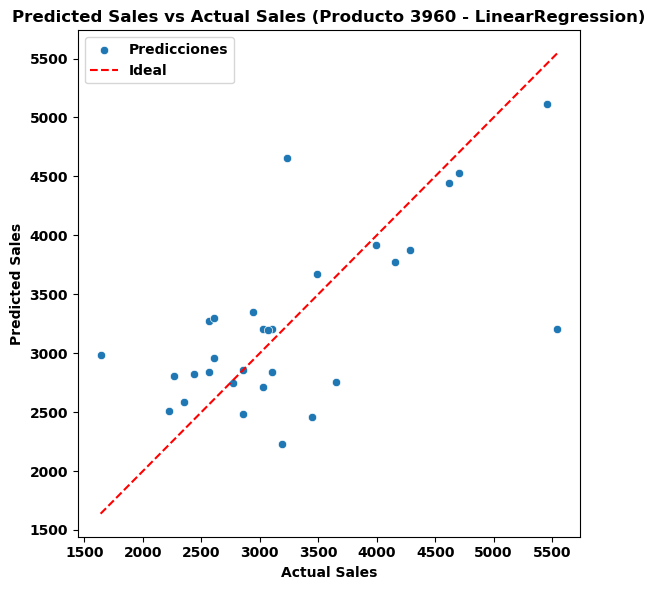

In [102]:
# Scatter plot del producto 3960, con LinearRegression (mejor modelo aquí)
lr_res = resultados_3960["LinearRegression"]
y_test = lr_res["y_test"]
y_pred = lr_res["y_pred"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales (Producto 3960 - LinearRegression)")
ax.set_xlabel("Actual Sales")
ax.set_ylabel("Predicted Sales")

sns.scatterplot(x=y_test.values, y=y_pred, ax=ax, label="Predicciones")
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, color="red", linestyle="--", label="Ideal")

plt.legend()
plt.tight_layout()
plt.show()

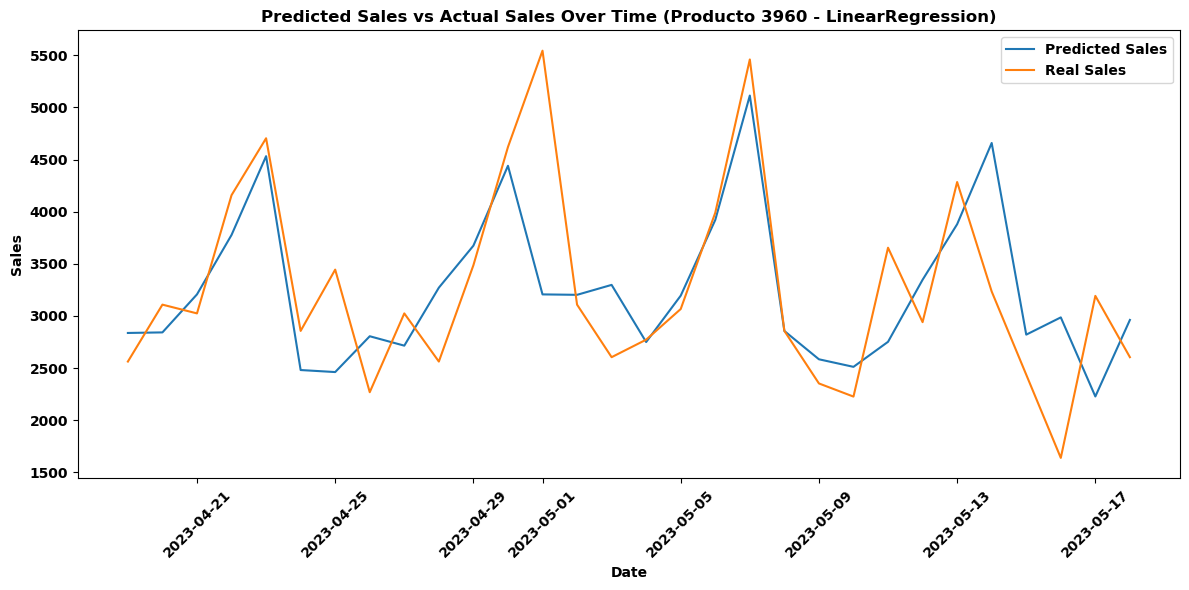

In [103]:
# Comparación de ventas 3960
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales Over Time (Producto 3960 - LinearRegression)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

dates = lr_res["fechas"]
sns.lineplot(x=dates, y=y_pred, label="Predicted Sales", ax=ax)
sns.lineplot(x=dates, y=y_test, label="Real Sales", ax=ax)

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()


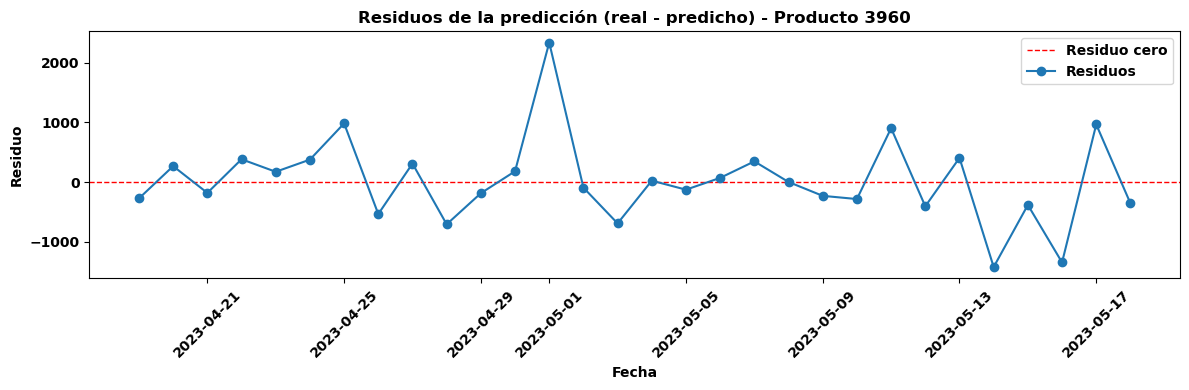

In [104]:
# Residuos plot
residuos = y_test.values - y_pred

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Residuos de la predicción (real - predicho) - Producto 3960")
ax.set_xlabel("Fecha")
ax.set_ylabel("Residuo")

ax.axhline(0, color="red", linestyle="--", lw=1, label="Residuo cero")
ax.plot(dates, residuos, marker="o", label="Residuos")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [105]:
# Vamos a probar con algun artículo más

articulo_menos_vendido = (
    df.groupby("articulo")["cantidad"]
    .sum()
    .sort_values()
    .index[0]
)

print(f"Artículo menos vendido: {articulo_menos_vendido}")

Artículo menos vendido: 6549


In [106]:
# Vamos a comprobar el artículo menos vendido, el 6549

resultados_6549 = pipeline_product(
    PRODUCT_ID=6549,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)


[✚ Árbol LinearRegression] MAE: 91.44 | RMSE: 107.46 | R2: 0.097 | MAE_rel: 0.523 | RMSE_rel: 0.614 | MAPE: 0.976


2025/07/29 09:42:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/598c8a3c87ef4d39af414211a8156ddb
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549.

[✚ Árbol RandomForest] MAE: 67.81 | RMSE: 87.68 | R2: 0.399 | MAE_rel: 0.387 | RMSE_rel: 0.501 | MAPE: 0.555


2025/07/29 09:42:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/3cee51e5e83c430f8373d65d2cd293c5
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549.

[✚ Árbol HistGradientBoosting] MAE: 75.47 | RMSE: 94.93 | R2: 0.295 | MAE_rel: 0.431 | RMSE_rel: 0.542 | MAPE: 0.509


2025/07/29 09:42:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/88f971ef1c134f478c852108d7b00504
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549.



## Resultados de Modelos para Predicción de Ventas (6549)

Se han evaluado los mismos tres modelos de regresión sobre un artículo diferente. Los resultados son los siguientes:

| Modelo                  | MAE   | MSE      | RMSE   | R2    |
|-------------------------|-------|----------|--------|-------|
| Linear Regression       | 91.44 | 11,548.52| 107.46 | 0.097 |
| Random Forest           | 67.81 | 7,688.52 | 87.68  | 0.399 |
| HistGradientBoosting    | 75.47 | 9,012.39 | 94.93  | 0.295 |

**Interpretación rápida:**
- En este caso, el modelo de **Random Forest** ofrece el mejor desempeño global, logrando el menor error absoluto (MAE) y el mayor coeficiente de determinación (*R2*), lo que indica que es el modelo que mejor se ajusta a los datos de este artículo concreto.
- **HistGradientBoosting** también supera a la regresión lineal en todas las métricas.
- El modelo de **Linear Regression** obtiene el peor resultado en este escenario, con un R2 muy bajo, lo que indica una capacidad explicativa limitada para este artículo.

**Métricas clave:**  
- **MAE:** Error medio absoluto en unidades de venta.  
- **MSE:** Error cuadrático medio, penaliza los errores grandes.  
- **RMSE:** Raíz cuadrada del MSE, interpretable en las mismas unidades que la variable objetivo.  
- **R2:** Porcentaje de la varianza explicada por el modelo.



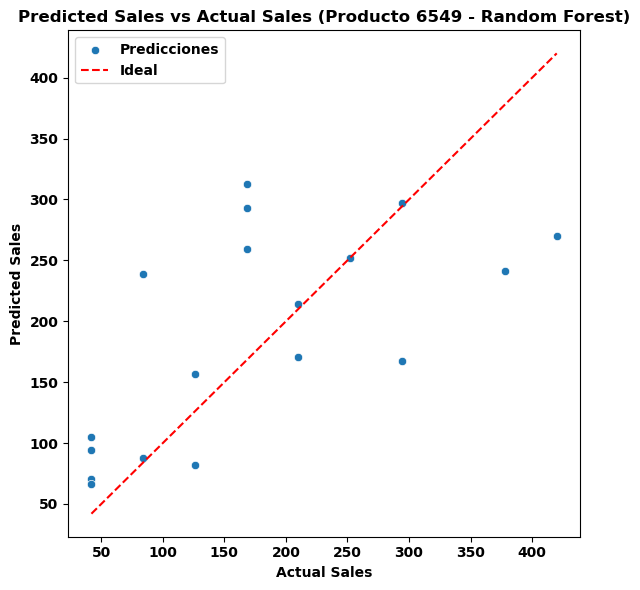

In [107]:
# Plot 1: Real vs. Predicho (Scatter plot 6549 - Random Forest)
rf_res = resultados_6549["RandomForest"]
y_test = rf_res["y_test"]
y_pred = rf_res["y_pred"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Predicted Sales vs Actual Sales (Producto 6549 - Random Forest)")
ax.set_xlabel("Actual Sales")
ax.set_ylabel("Predicted Sales")

sns.scatterplot(x=y_test.values, y=y_pred, ax=ax, label="Predicciones")
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, color="red", linestyle="--", label="Ideal")

plt.legend()
plt.tight_layout()
plt.show()

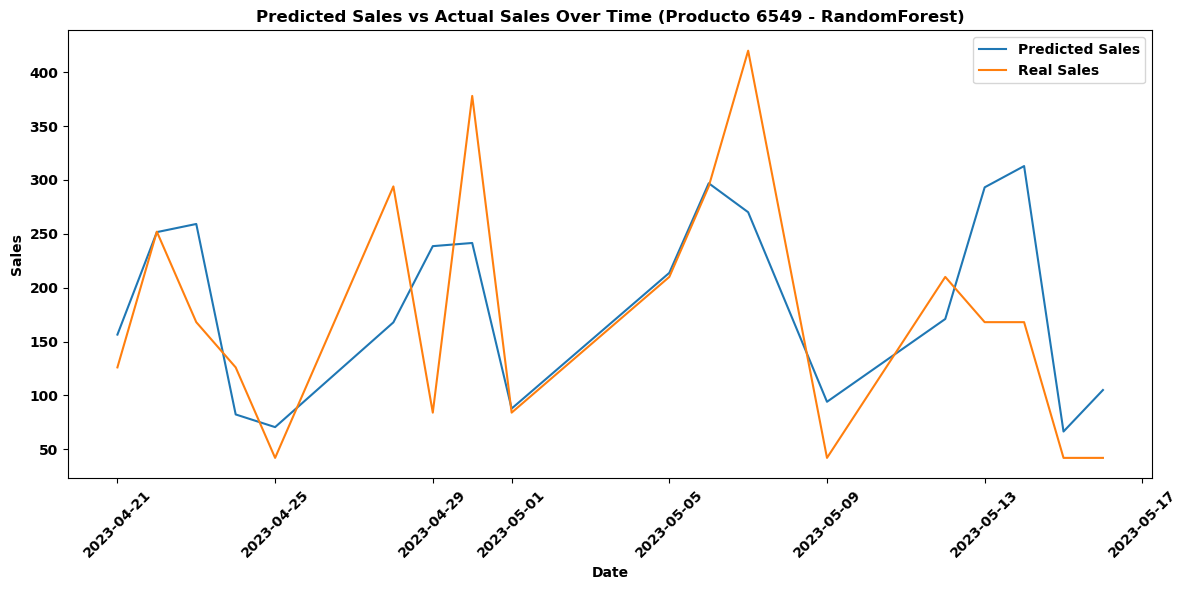

In [108]:
# Comparación de ventas 6549
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title("Predicted Sales vs Actual Sales Over Time (Producto 6549 - RandomForest)")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

dates = rf_res["fechas"]
sns.lineplot(x=dates, y=y_pred, label="Predicted Sales", ax=ax)
sns.lineplot(x=dates, y=y_test, label="Real Sales", ax=ax)

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

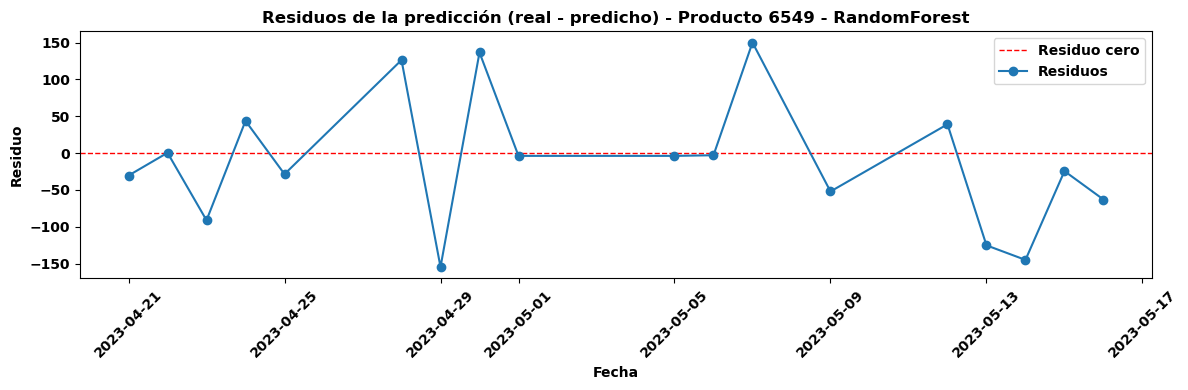

In [109]:
# Plot de resiuduos artículo 6549
residuos = y_test.values - y_pred

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Residuos de la predicción (real - predicho) - Producto 6549 - RandomForest")
ax.set_xlabel("Fecha")
ax.set_ylabel("Residuo")

ax.axhline(0, color="red", linestyle="--", lw=1, label="Residuo cero")
ax.plot(dates, residuos, marker="o", label="Residuos")

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [110]:
# Tenemos que pasar por la función, todos los artículos que quedan


resultados_417 = pipeline_product(
    PRODUCT_ID=417,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 106.42 | RMSE: 143.87 | R2: -0.272 | MAE_rel: 0.125 | RMSE_rel: 0.168 | MAPE: 0.133


2025/07/29 09:42:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/336da25905284e2d91a100c1a64bb6e6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417.

[✚ Árbol RandomForest] MAE: 116.28 | RMSE: 146.79 | R2: -0.324 | MAE_rel: 0.136 | RMSE_rel: 0.172 | MAPE: 0.148


2025/07/29 09:43:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/84dde5fdc3d14d8aa19e7a771d4072ec
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417.

[✚ Árbol HistGradientBoosting] MAE: 122.39 | RMSE: 156.75 | R2: -0.510 | MAE_rel: 0.143 | RMSE_rel: 0.184 | MAPE: 0.144


2025/07/29 09:43:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/25ec7f70e3ab45f6b6282c54076beb4b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417.



In [111]:
resultados_968 = pipeline_product(
    PRODUCT_ID=968,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 893.73 | RMSE: 1151.35 | R2: -0.740 | MAE_rel: 0.254 | RMSE_rel: 0.327 | MAPE: 0.245


2025/07/29 09:43:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/947e2761fadb43e48e2366f5084d3a6b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968.

[✚ Árbol RandomForest] MAE: 502.82 | RMSE: 723.67 | R2: 0.312 | MAE_rel: 0.143 | RMSE_rel: 0.206 | MAPE: 0.140


2025/07/29 09:43:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/783d85f5bdac4351bc5e190ba1560127
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968.

[✚ Árbol HistGradientBoosting] MAE: 533.17 | RMSE: 704.55 | R2: 0.348 | MAE_rel: 0.152 | RMSE_rel: 0.200 | MAPE: 0.153


2025/07/29 09:43:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/8b911f8b47a14ac3ad75b2215461e5cb
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968.



In [112]:
resultados_1043 = pipeline_product(
    PRODUCT_ID=1043,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 481.66 | RMSE: 733.12 | R2: 0.478 | MAE_rel: 0.222 | RMSE_rel: 0.338 | MAPE: 0.202


2025/07/29 09:44:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/92b68737f86a45fd8cbffea7e9110919
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043.

[✚ Árbol RandomForest] MAE: 565.64 | RMSE: 771.61 | R2: 0.422 | MAE_rel: 0.261 | RMSE_rel: 0.356 | MAPE: 0.288


2025/07/29 09:44:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/6666b6b575f4433c8a1f606a6df0b340
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043.

[✚ Árbol HistGradientBoosting] MAE: 466.89 | RMSE: 654.58 | R2: 0.584 | MAE_rel: 0.215 | RMSE_rel: 0.302 | MAPE: 0.221


2025/07/29 09:44:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/2a721457849043288d7fad2fe515fcfd
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043.



In [113]:
resultados_1084 = pipeline_product(
    PRODUCT_ID=1084,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 613.62 | RMSE: 793.56 | R2: -0.388 | MAE_rel: 0.165 | RMSE_rel: 0.214 | MAPE: 0.187


2025/07/29 09:44:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/32c819bf8b604d10a36a9a7546a8826a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084.

[✚ Árbol RandomForest] MAE: 542.89 | RMSE: 715.46 | R2: -0.129 | MAE_rel: 0.146 | RMSE_rel: 0.193 | MAPE: 0.165


2025/07/29 09:44:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/c3f975f339c540a484eb953435aefc69
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084.

[✚ Árbol HistGradientBoosting] MAE: 527.15 | RMSE: 762.40 | R2: -0.282 | MAE_rel: 0.142 | RMSE_rel: 0.205 | MAPE: 0.164


2025/07/29 09:45:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/d7231c6a774f4ebaabc40b1ecd09a19b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084.



In [114]:
resultados_3880 = pipeline_product(
    PRODUCT_ID=3880,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 335.92 | RMSE: 441.21 | R2: 0.491 | MAE_rel: 0.150 | RMSE_rel: 0.197 | MAPE: 0.153


2025/07/29 09:45:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/3bde7ca92f3f47908f6a45c57ec8447d
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880.

[✚ Árbol RandomForest] MAE: 339.67 | RMSE: 448.70 | R2: 0.474 | MAE_rel: 0.152 | RMSE_rel: 0.201 | MAPE: 0.149


2025/07/29 09:45:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/91e4e2a1c949466c99c3f929b80ea599
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880.

[✚ Árbol HistGradientBoosting] MAE: 402.26 | RMSE: 477.04 | R2: 0.405 | MAE_rel: 0.180 | RMSE_rel: 0.213 | MAPE: 0.183


2025/07/29 09:45:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/7090642c2c204ef6ac0bfe750394e8c8
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880.



In [115]:
resultados_5803 = pipeline_product(
    PRODUCT_ID=5803,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 247.12 | RMSE: 314.94 | R2: 0.500 | MAE_rel: 0.250 | RMSE_rel: 0.319 | MAPE: 0.280


2025/07/29 09:45:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/068c54c36a3b4d0dbb23544a08f1a085
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803.

[✚ Árbol RandomForest] MAE: 296.44 | RMSE: 380.05 | R2: 0.272 | MAE_rel: 0.300 | RMSE_rel: 0.385 | MAPE: 0.340


2025/07/29 09:46:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/45172ef6835f4e7391d5e28470648da3
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803.

[✚ Árbol HistGradientBoosting] MAE: 285.69 | RMSE: 381.70 | R2: 0.266 | MAE_rel: 0.289 | RMSE_rel: 0.387 | MAPE: 0.309


2025/07/29 09:46:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/de96151f2d4c49f6a970a3d994d9431d
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803.



In [116]:
resultados_6286 = pipeline_product(
    PRODUCT_ID=6286,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 284.62 | RMSE: 484.95 | R2: 0.414 | MAE_rel: 0.200 | RMSE_rel: 0.342 | MAPE: 0.212


2025/07/29 09:46:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/099c814cb9814e269000b7e7af583844
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286.

[✚ Árbol RandomForest] MAE: 292.04 | RMSE: 471.77 | R2: 0.446 | MAE_rel: 0.206 | RMSE_rel: 0.332 | MAPE: 0.226


2025/07/29 09:46:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/ed29385f2c074c63b7f562eb7766d524
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286.

[✚ Árbol HistGradientBoosting] MAE: 343.03 | RMSE: 512.98 | R2: 0.344 | MAE_rel: 0.242 | RMSE_rel: 0.361 | MAPE: 0.261


2025/07/29 09:46:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/9dd07a3ddafa4c47bf68884413764670
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286.



In [117]:
resultados_6425 = pipeline_product(
    PRODUCT_ID=6425,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 83.41 | RMSE: 104.76 | R2: 0.117 | MAE_rel: 0.424 | RMSE_rel: 0.533 | MAPE: 0.996


2025/07/29 09:47:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/8a00ef3f890c4c0d9abfd9702031efaf
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425.

[✚ Árbol RandomForest] MAE: 85.82 | RMSE: 100.17 | R2: 0.192 | MAE_rel: 0.436 | RMSE_rel: 0.509 | MAPE: 1.017


2025/07/29 09:47:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/61d429c88b3d4b849eb0fef03fc5f608
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425.

[✚ Árbol HistGradientBoosting] MAE: 78.40 | RMSE: 97.71 | R2: 0.232 | MAE_rel: 0.399 | RMSE_rel: 0.497 | MAPE: 0.915


2025/07/29 09:47:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/eede53d69282475d97242f7d8ba13336
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425.



In [118]:
resultados_5403 = pipeline_product(
    PRODUCT_ID=5403,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 116.19 | RMSE: 166.81 | R2: 0.151 | MAE_rel: 0.464 | RMSE_rel: 0.666 | MAPE: 0.628


2025/07/29 09:47:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/5ac4065d978045638b8a0b41f5b95b15
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403.

[✚ Árbol RandomForest] MAE: 120.26 | RMSE: 163.16 | R2: 0.188 | MAE_rel: 0.480 | RMSE_rel: 0.651 | MAPE: 0.815


2025/07/29 09:47:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/81d7229cc58b4d75be9175af886c3a16
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403.

[✚ Árbol HistGradientBoosting] MAE: 117.58 | RMSE: 157.08 | R2: 0.247 | MAE_rel: 0.469 | RMSE_rel: 0.627 | MAPE: 0.727


2025/07/29 09:48:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/283a8d46933949079ab1a47f1c8b364e
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403.



In [119]:
resultados_5404 = pipeline_product(
    PRODUCT_ID=5404,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 118.03 | RMSE: 168.69 | R2: 0.411 | MAE_rel: 0.462 | RMSE_rel: 0.661 | MAPE: 0.801


2025/07/29 09:48:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/ef4a2f49812f4b688c53bcd2fe7a3ace
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404.

[✚ Árbol RandomForest] MAE: 111.50 | RMSE: 175.60 | R2: 0.362 | MAE_rel: 0.437 | RMSE_rel: 0.688 | MAPE: 0.691


2025/07/29 09:48:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/51aaaa5a24fa4aac9f431650a1343021
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404.

[✚ Árbol HistGradientBoosting] MAE: 129.09 | RMSE: 188.29 | R2: 0.267 | MAE_rel: 0.505 | RMSE_rel: 0.737 | MAPE: 0.866


2025/07/29 09:48:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/dae042ba3ca34278ba3af44bb06355f5
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404.



In [120]:
resultados_6451 = pipeline_product(
    PRODUCT_ID=6451,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 80.71 | RMSE: 99.83 | R2: 0.237 | MAE_rel: 0.569 | RMSE_rel: 0.703 | MAPE: 0.862


2025/07/29 09:48:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/0cf3f474847a43ccaca439060d572398
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451.

[✚ Árbol RandomForest] MAE: 84.55 | RMSE: 106.81 | R2: 0.127 | MAE_rel: 0.596 | RMSE_rel: 0.753 | MAPE: 0.981


2025/07/29 09:49:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/07168d063b5948e38e48794bdecd253b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451.

[✚ Árbol HistGradientBoosting] MAE: 87.27 | RMSE: 108.87 | R2: 0.093 | MAE_rel: 0.615 | RMSE_rel: 0.767 | MAPE: 1.065


2025/07/29 09:49:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/1704fcba52184b4cb0de2ab27bf75488
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451.



In [121]:
resultados_6523 = pipeline_product(
    PRODUCT_ID=6523,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol LinearRegression] MAE: 66.59 | RMSE: 80.42 | R2: -0.073 | MAE_rel: 0.480 | RMSE_rel: 0.580 | MAPE: 0.741


2025/07/29 09:49:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/2ba049dae3ec4aadb193dc73a9366000
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523.

[✚ Árbol RandomForest] MAE: 55.92 | RMSE: 66.66 | R2: 0.263 | MAE_rel: 0.403 | RMSE_rel: 0.480 | MAPE: 0.590


2025/07/29 09:49:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/527bf32aea9d4bcebc93687723895334
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523.

[✚ Árbol HistGradientBoosting] MAE: 62.85 | RMSE: 76.17 | R2: 0.037 | MAE_rel: 0.453 | RMSE_rel: 0.549 | MAPE: 0.746


2025/07/29 09:49:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/fdcabb57475844ac8efdea6cab736d02
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523.



### Resultados por producto:

- Producto 417 (PANADERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 106.42 | RMSE: 143.87 | R2: -0.27  
  
- Producto 900 (PANADERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 1165.35 | RMSE: 1345.96 | R2: 0.18  
  
- Producto 968 (PANADERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 502.82 | RMSE: 723.67 | R2: 0.31  

- Producto 1043 (PANADERIA):  
  - **Mejor modelo:** HistGradientBoosting  
  - MAE: 466.89 | RMSE: 654.58 | R2: 0.58  
  
- Producto 1084 (PANADERIA):  
  - **Mejor modelo:** HistGradientBoosting  
  - MAE: 527.15 | RMSE: 762.40 | R2: -0.28  
  
- Producto 3880 (BOLLERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 335.92 | RMSE: 441.21 | R2: 0.49  
  
- Producto 3960 (BOLLERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 498.64 | RMSE: 703.38 | R2: 0.42  
  
- Producto 5803 (BOLLERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 247.12 | RMSE: 314.94 | R2: 0.50  
  
- Producto 6286 (BOLLERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 292.04 | RMSE: 471.77 | R2: 0.45  
  
- Producto 6425 (BOLLERIA):  
  - **Mejor modelo:** HistGradientBoosting  
  - MAE: 78.40 | RMSE: 97.71 | R2: 0.23  

- Producto 5403 (PASTELERIA):  
  - **Mejor modelo:** HistGradientBoosting  
  - MAE: 117.58 | RMSE: 157.08 | R2: 0.25  
  

- Producto 5404 (PASTELERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 111.50 | RMSE: 175.60 | R2: 0.36  
  
- Producto 6451 (PASTELERIA):  
  - **Mejor modelo:** LinearRegression  
  - MAE: 80.71 | RMSE: 99.83 | R2: 0.24  
  
- Producto 6523 (PASTELERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 55.92 | RMSE: 66.66 | R2: 0.26  
 
- Producto 6549 (PASTELERIA):  
  - **Mejor modelo:** RandomForest  
  - MAE: 67.81 | RMSE: 87.68 | R2: 0.40  
  


### Evaluación de modelos: próximos pasos

Tras analizar los resultados de predicción de ventas para todos los productos, hemos identificado varios casos donde los modelos probados (Linear Regression, Random Forest y HistGradientBoosting) presentan un bajo rendimiento, especialmente evidenciado por valores de R² negativos o cercanos a cero y errores elevados.

**Para los siguientes productos es imprescindible explorar otros modelos, ya que los resultados actuales no son satisfactorios:**

- **Producto 417 (PANADERIA)**
- **Producto 900 (PANADERIA)**
- **Producto 1084 (PANADERIA)**

**Además, sería recomendable intentar mejorar el modelo para estos productos, ya que muestran R² bajos o margen de mejora:**

- **Producto 6425 (BOLLERIA)**
- **Producto 5403 (PASTELERIA)**
- **Producto 6451 (PASTELERIA)**
- **Producto 6523 (PASTELERIA)**
- **Producto 5404 (PASTELERIA)**
- **Producto 6549 (PASTELERIA)**

Para todos estos artículos, vamos a explorar y probar otros modelos o técnicas adicionales, con el objetivo de mejorar la precisión de las predicciones. Entre las opciones que consideraremos están:

- Modelos clásicos de series temporales (ARIMA, Prophet)
- Otros algoritmos de machine learning (XGBoost, LightGBM, redes neuronales)
- Técnicas avanzadas de feature engineering o ajuste de hiperparámetros

De este modo, buscamos encontrar la mejor solución para cada producto, garantizando resultados más robustos y fiables en la predicción de la demanda.


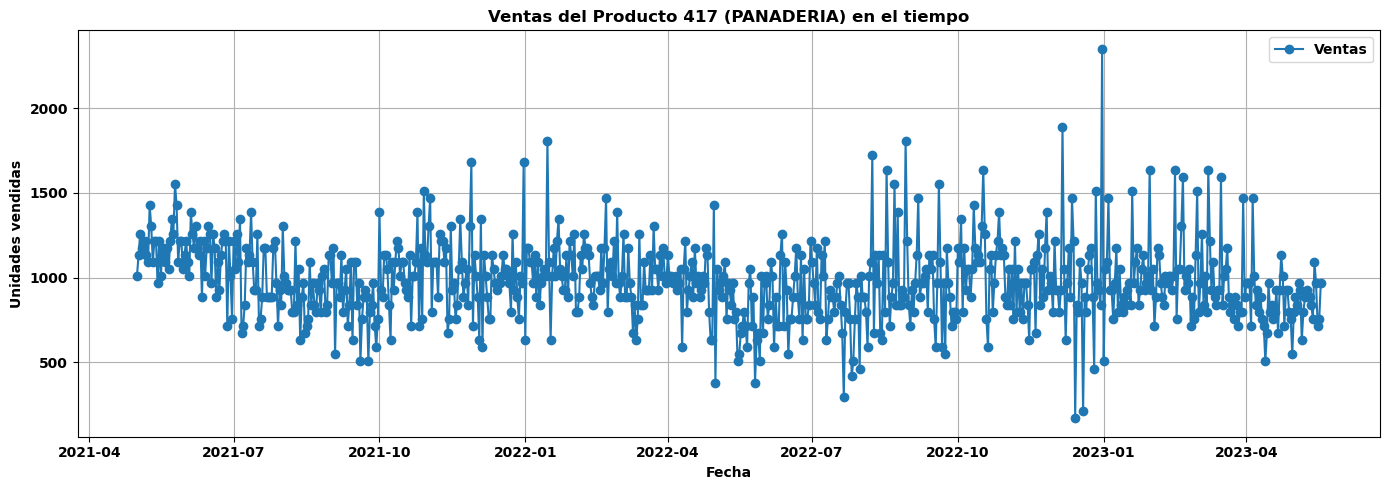

In [122]:
import matplotlib.pyplot as plt

# Filtra las ventas del producto 417
df_417 = df[df["articulo"] == 417].copy()
df_417 = df_417.sort_values("fecha_venta")

plt.figure(figsize=(14, 5))
plt.plot(df_417["fecha_venta"], df_417["cantidad"], marker='o', label="Ventas")
plt.title("Ventas del Producto 417 (PANADERIA) en el tiempo")
plt.xlabel("Fecha")
plt.ylabel("Unidades vendidas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Con este plot, vamos a analizar los outliers claros que hay, vamos a marcar el umbral en 3 veces la desviación estándar (std)

In [123]:
# Umbral: 3 veces la desviación estándar
umbral417 = df_417["cantidad"].mean() + 3 * df_417["cantidad"].std()
outliers417 = df_417[df_417["cantidad"] > umbral417]

print(f"Se han detectado {len(outliers417)} posibles outliers:")
print(outliers417[["fecha_venta", "cantidad"]])


Se han detectado 7 posibles outliers:
     fecha_venta  cantidad
4791  2021-11-28    1680.0
4956  2021-12-31    1680.0
5031  2022-01-15    1806.0
6056  2022-08-08    1722.0
6161  2022-08-29    1806.0
6656  2022-12-06    1890.0
6781  2022-12-31    2352.0


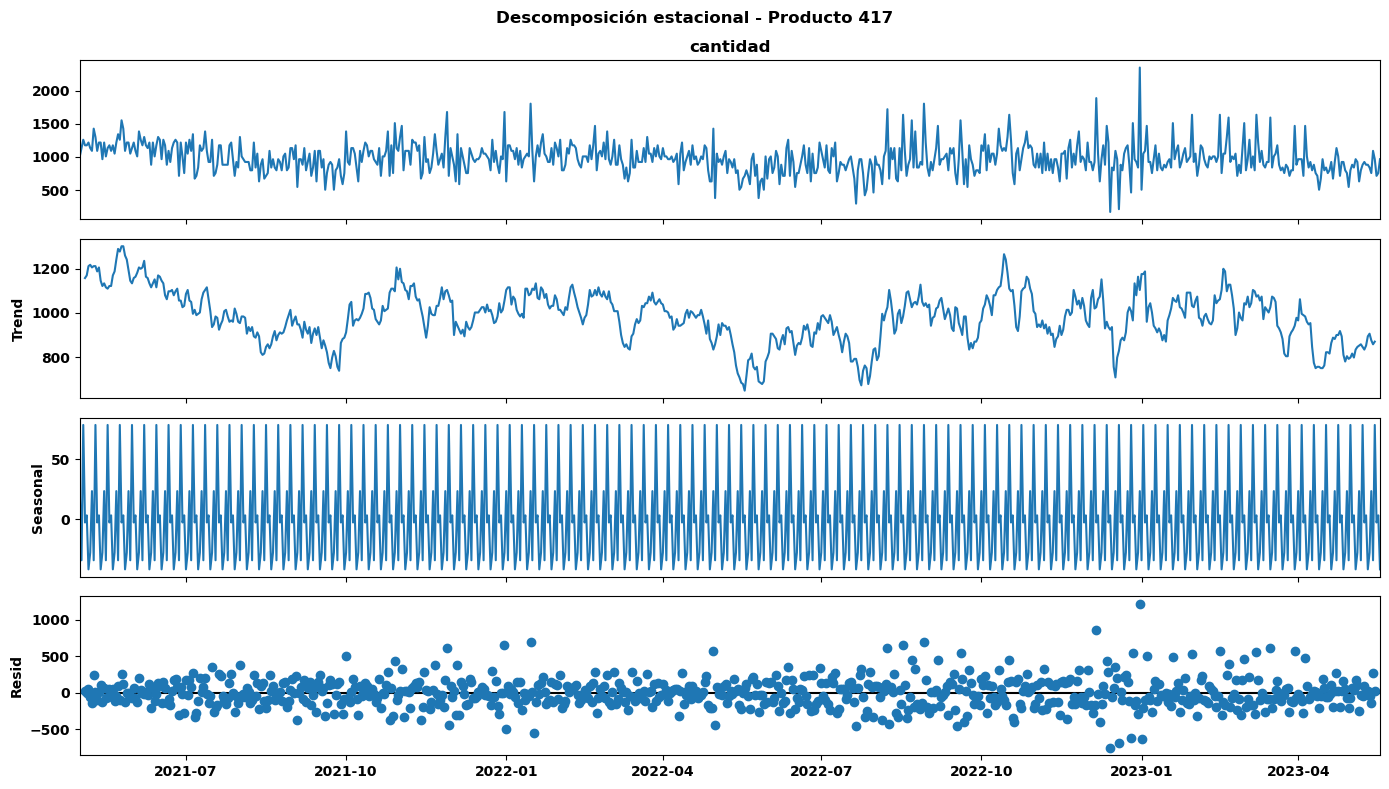

In [124]:
# Con seasonal_decompose, podremos descomponer la estacionalidad
from statsmodels.tsa.seasonal import seasonal_decompose

# Reindexa fechas para tener frecuencia diaria y rellena vacíos con 0
df_417_daily = df_417.set_index("fecha_venta").resample("D").sum().fillna(0)

# Descomposición aditiva (puedo ajustar period si tenemos patrón semanal o mensual)
result = seasonal_decompose(df_417_daily["cantidad"], model='additive', period=7)

fig = result.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Descomposición estacional - Producto 417")
plt.tight_layout()
plt.show()


#### Descomposición estacional – Producto 417

El análisis de descomposición estacional para el Producto 417 muestra lo siguiente:

- **Serie original:** Las ventas diarias presentan gran variabilidad y algunos picos, sin una tendencia claramente creciente o decreciente.
- **Tendencia:** Se observa una caída de ventas a finales de 2021, seguida de cierta recuperación y oscilaciones posteriores.
- **Estacionalidad:** Existe un patrón periódico muy marcado con una cadencia semanal, indicando que las ventas varían de forma significativa según el día de la semana.
- **Residuo:** La mayor parte de los residuos oscilan cerca de cero, aunque aparecen algunos valores atípicos (outliers) que podrían deberse a eventos puntuales o errores de registro.

**Conclusión:**  
El producto presenta una **estacionalidad semanal muy fuerte** y cierta variabilidad en la tendencia. Creo que para mejorar las predicciones, es fundamental incorporar variables que recojan aún más la estacionalidad, o explorar otros modelos, o analizar posibles outliers en los datos.


# Siguientes pasos

### 📊 Comparativa y selección de modelos según producto y métricas

Con el objetivo de mejorar la precisión de las predicciones en productos con bajo rendimiento, se probarán distintos modelos de regresión. La selección se realiza en función del comportamiento y las métricas obtenidas en las primeras pruebas:

| Tipo de producto / Métrica obtenida                               | Modelos a probar                                                    | Observaciones clave                                      |
|-------------------------------------------------------------------|---------------------------------------------------------------------|----------------------------------------------------------|
| **R² negativo o cercano a 0**<br>(Mucho error, patrones poco claros)  | - XGBoost<br>- LightGBM<br>- SVR<br>- HuberRegressor                 | Suele haber mucho ruido, no linealidad o outliers        |
| **R² entre 0.1 y 0.5**<br>(Moderada predictibilidad)                  | - Ridge<br>- Lasso<br>- ExtraTreesRegressor                          | Regularización y modelos robustos pueden mejorar la predicción |
| **R² > 0.5 y error bajo**<br>(Buen ajuste)                            | - Mantener mejor modelo<br>- Probar Ridge/Lasso o XGBoost (opcional) | Sólo intentar mejorar si hay margen                      |
| **Ventas muy irregulares/estacionales**                               | - XGBoost<br>- LightGBM<br>- NeuralProphet (si es viable)            | Modelos que detectan patrones no lineales o complejos     |
| **Presencia de outliers claros**                                     | - HuberRegressor<br>- RANSACRegressor                                | Modelos robustos a valores atípicos                      |

---

**Notas:**
- Todos estos modelos son compatibles con el pipeline actual basado en scikit-learn.
- Se irá comparando el rendimiento de los nuevos modelos con las métricas obtenidas anteriormente para cada producto.
- El proceso es iterativo: se mantienen aquellos modelos que aportan una mejora clara en R² y/o reducción del error.


In [125]:
# Vamos a ajustar el pipeline_product

from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR

modelos_productos_problematicos = {
    "XGBoost": XGBRegressor(random_state=42),
    "Ridge": Ridge(max_iter=10000, tol=1e-4),
    "Huber": HuberRegressor(),
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    "SVR": SVR()
}


In [126]:
# Empezamos por uno de los productos más problematicos, el 417
resultados_417 = pipeline_product(
    PRODUCT_ID=417,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos_productos_problematicos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol XGBoost] MAE: 119.72 | RMSE: 153.34 | R2: -0.445 | MAE_rel: 0.140 | RMSE_rel: 0.180 | MAPE: 0.147


2025/07/29 09:50:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/ff397a625d0d4f26af8d663960ca00bf
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417.

[✚ Árbol Ridge] MAE: 106.40 | RMSE: 143.49 | R2: -0.266 | MAE_rel: 0.125 | RMSE_rel: 0.168 | MAPE: 0.133


2025/07/29 09:50:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/fa395d43969147b4ba7132315aa1d4e7
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417.



STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[✚ Árbol Huber] MAE: 104.59 | RMSE: 139.39 | R2: -0.194 | MAE_rel: 0.122 | RMSE_rel: 0.163 | MAPE: 0.129


2025/07/29 09:50:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Huber-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/5da91b0257c74224a4674eeb214c8775
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417.

[✚ Árbol ExtraTrees] MAE: 129.50 | RMSE: 170.16 | R2: -0.780 | MAE_rel: 0.152 | RMSE_rel: 0.199 | MAPE: 0.161


2025/07/29 09:50:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/9c73225c86aa478081586b195eb435a0
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417.

[✚ Árbol SVR] MAE: 141.94 | RMSE: 182.46 | R2: -1.046 | MAE_rel: 0.166 | RMSE_rel: 0.214 | MAPE: 0.180


2025/07/29 09:50:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SVR-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/ec23cbf581d64d60b77d8637c18a0916
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417.



In [127]:
resultados_900 = pipeline_product(
    PRODUCT_ID=900,
    df_original=df,
    preprocessor=preprocessor,
    remove_nans_transformer=remove_nans_transformer,
    encoders_transformer=encoders_transformer,
    target_feature_scaler=target_feature_scaler,
    modelos=modelos_productos_problematicos,
    horizonte_fecha=pd.Timestamp('2023-04-19')
)

[✚ Árbol XGBoost] MAE: 1572.60 | RMSE: 1895.64 | R2: -0.631 | MAE_rel: 0.512 | RMSE_rel: 0.617 | MAPE: 0.649


2025/07/29 09:51:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/56f75658cc304a04a3e571513767aa98
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900.

[✚ Árbol Ridge] MAE: 1191.80 | RMSE: 1366.94 | R2: 0.152 | MAE_rel: 0.388 | RMSE_rel: 0.445 | MAPE: 0.461


2025/07/29 09:51:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/e4c17b565aa04224a08548650651962f
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900.



STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[✚ Árbol Huber] MAE: 1281.04 | RMSE: 1460.49 | R2: 0.032 | MAE_rel: 0.417 | RMSE_rel: 0.475 | MAPE: 0.494


2025/07/29 09:51:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Huber-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/ef8ac246c46a4707ae446d767be63389
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900.

[✚ Árbol ExtraTrees] MAE: 1390.96 | RMSE: 1698.36 | R2: -0.309 | MAE_rel: 0.452 | RMSE_rel: 0.552 | MAPE: 0.565


2025/07/29 09:51:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/4c1e5d9658ec414db6612757d555d595
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900.

[✚ Árbol SVR] MAE: 1624.69 | RMSE: 1821.17 | R2: -0.506 | MAE_rel: 0.528 | RMSE_rel: 0.592 | MAPE: 0.677


2025/07/29 09:51:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SVR-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/dfa5bb48dbc44116a88f35fd3e6f6e70
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900.



#### Los resultados son bastante mediocres, así que lógicamente vamos a cambiar el pipeline para estos modelos que estamos probando, ya que requieren de transformaciones distintas, preprocesados distintos, etc.

In [128]:
from __future__ import annotations

from typing import Dict, Iterable, Tuple
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler


In [129]:
# Voy a realizar dos pipelines distintos, uno para modelos de árbol, y otra para modelos lineales
# Empezaré cambiando todo el proceso previo al modelado
class PreprocessTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, location: Tuple[float, float]):
        self.location = location

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X = add_date_columns(X)
        X = add_holiday_column(X)
        X = add_weather_columns(X, location=self.location)
        return X
    
    def set_output(self, transform=None):
        return self


def _prepare_item_dataframe(
    df_original: pd.DataFrame,
    product_id: int | str,
    horizon_date: pd.Timestamp,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """Seleccionamos y preparamos el DataFrame para un solo producto.
    """
    # Filtramos datos del producto seleccionado
    item_mask = df_original["articulo"] == product_id
    item_df = df_original[item_mask].copy()
    if item_df.empty:
        raise ValueError(f"No hay datos para el artículo {product_id}")

    # Quitamos columnas no necesarias
    item_df.drop(
        columns=["importe", "articulo", "familia", "orden_articulo_familia"],
        inplace=True,
        errors="ignore",
    )
    # Ordenamos por fecha
    item_df = item_df.sort_values("fecha_venta").reset_index(drop=True)

    # Lags
    item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)

    # Train/test
    fecha_col = "fecha_venta"
    if horizon_date is None:
        horizon_date = item_df[fecha_col].max() - pd.Timedelta(days=30)
    df_train = item_df[item_df[fecha_col] < horizon_date]
    df_test = item_df[item_df[fecha_col] >= horizon_date]

    if df_train.empty or df_test.empty:
        raise ValueError(
            f"No hay datos suficientes para split train/test en el artículo {product_id}"
        )

    # Separamos features y target
    X_train = df_train.drop(columns=["cantidad"])
    y_train = df_train["cantidad"]
    X_test = df_test.drop(columns=["cantidad"])
    y_test = df_test["cantidad"]
    fechas_test = df_test[fecha_col].reset_index(drop=True)

    return item_df, X_train, X_test, y_train, y_test, fechas_test


def pipeline_product_arbol(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    modelos: Dict[str, BaseEstimator],
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
) -> Dict[str, Dict[str, pd.Series]]:
    
    resultados: Dict[str, Dict[str, pd.Series]] = {}

    # Preparamos datos para el producto
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
        df_original=df_original,
        product_id=product_id,
        horizon_date=horizon_date,
    )

    # Definimos los selectores de columnas
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    # Gestión de NaNs
    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    # Encoder para variables categóricas
    ordinal_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OrdinalEncoder", ordinal_encoder, categorical_features),
            ("numeric", "passthrough", numerical_features),
        ],
        remainder="drop",
    )

    target_feature_scaler = MinMaxScaler(feature_range=(0, 1))

    preprocessor = PreprocessTransformer(location=location)

    # Iteramos cada modelo
    for nombre, model in modelos.items():
        input_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("nan_remover", remove_nans_transformer),
                ("data_encoding", encoders_transformer),
                ("model", model),
            ]
        )
        input_pipeline.set_output(transform="pandas")

        final_pipeline = TransformedTargetRegressor(
            regressor=input_pipeline,
            transformer=target_feature_scaler,
        )

        # Start MLflow 
        with mlflow.start_run(run_name=f"{nombre}-articulo-{product_id}"):
            final_pipeline.fit(X_train, y_train)
            y_pred = final_pipeline.predict(X_test)

            # Métricas
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = metrics.root_mean_squared_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)

            # Relative metrics: error medio relativo y error cuadrático relativo
            mean_y = y_test.mean()
            mae_rel = mae / mean_y if mean_y != 0 else np.nan
            rmse_rel = rmse / mean_y if mean_y != 0 else np.nan

            # Mean Absolute Percentage Error (MAPE).  Evitamos dividir por cero
            y_test_arr = y_test.values
            y_pred_arr = np.asarray(y_pred)
            mask_non_zero = y_test_arr != 0
            if mask_non_zero.any():
                mape = np.mean(np.abs((y_test_arr[mask_non_zero] - y_pred_arr[mask_non_zero]) / y_test_arr[mask_non_zero]))
            else:
                mape = np.nan

            print(f"[\u271a Árbol {nombre}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f} | "
            f"MAE_rel: {mae_rel:.3f} | RMSE_rel: {rmse_rel:.3f} | MAPE: {mape:.3f}"
            )

            # Log parameters and metrics
            mlflow.log_param("modelo", nombre)
            mlflow.log_param("product_id", product_id)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae_rel", mae_rel)
            mlflow.log_metric("rmse_rel", rmse_rel)
            mlflow.log_metric("mape", mape)
            mlflow.sklearn.log_model(final_pipeline, name="model")

            # Guardamos resultados
            resultados[nombre] = {
                "y_test": y_test.reset_index(drop=True),
                "y_pred": pd.Series(y_pred),
                "fechas": fechas_test,
            }

        print(f"Análisis terminado para artículo {product_id} con modelo {nombre}.\n")

    return resultados

In [130]:
# Pipeline para productos para evaluar modelos lineales
def pipeline_product_lineal(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    modelos: Dict[str, BaseEstimator],
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
) -> Dict[str, Dict[str, pd.Series]]:
    """Probamos para modelos lineares específicos
    """
    resultados: Dict[str, Dict[str, pd.Series]] = {}

    # Preparamos los datos para el producto
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
        df_original=df_original,
        product_id=product_id,
        horizon_date=horizon_date,
    )

    # Definimos selectores de columnas
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    # Gestionamos NaNs
    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    # Encoder para variables categóricas y escalamos variables numéricas
    ohe_encoder = OneHotEncoder(
        sparse_output=False, handle_unknown="ignore"
    )
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OneHotEncoder", ohe_encoder, categorical_features),
            ("MinMaxScaler", minmax_scaler, numerical_features),
        ],
        remainder="drop",
    )

    # Escalamos el target a [0, 1]
    target_feature_scaler = MinMaxScaler(feature_range=(0, 1))

    preprocessor = PreprocessTransformer(location=location)

    for nombre, model in modelos.items():
        input_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("nan_remover", remove_nans_transformer),
                ("data_encoding", encoders_transformer),
                ("model", model),
            ]
        )
        input_pipeline.set_output(transform="pandas")

        final_pipeline = TransformedTargetRegressor(
            regressor=input_pipeline,
            transformer=target_feature_scaler,
        )

        with mlflow.start_run(run_name=f"{nombre}-articulo-{product_id}"):
            final_pipeline.fit(X_train, y_train)
            y_pred = final_pipeline.predict(X_test)

            # Compute metrics
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = metrics.root_mean_squared_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)

            # Relative metrics: error medio relativo y error cuadrático relativo
            mean_y = y_test.mean()
            mae_rel = mae / mean_y if mean_y != 0 else np.nan
            rmse_rel = rmse / mean_y if mean_y != 0 else np.nan

            # Mean Absolute Percentage Error (MAPE).  Evitamos dividir por cero
            y_test_arr = y_test.values
            y_pred_arr = np.asarray(y_pred)
            mask_non_zero = y_test_arr != 0
            if mask_non_zero.any():
                mape = np.mean(np.abs((y_test_arr[mask_non_zero] - y_pred_arr[mask_non_zero]) / y_test_arr[mask_non_zero]))
            else:
                mape = np.nan

            print(f"[\u271a Árbol {nombre}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f} | "
                f"MAE_rel: {mae_rel:.3f} | RMSE_rel: {rmse_rel:.3f} | MAPE: {mape:.3f}"
                )

            # Log parameters and metrics
            mlflow.log_param("modelo", nombre)
            mlflow.log_param("product_id", product_id)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae_rel", mae_rel)
            mlflow.log_metric("rmse_rel", rmse_rel)
            mlflow.log_metric("mape", mape)
            mlflow.sklearn.log_model(final_pipeline, name="model")
            # Guardamos resultados
            resultados[nombre] = {
                "y_test": y_test.reset_index(drop=True),
                "y_pred": pd.Series(y_pred),
                "fechas": fechas_test,
            }

        print(f"Análisis terminado para artículo {product_id} con modelo {nombre}.\n")

    return resultados

In [131]:
from sklearn.linear_model import ElasticNet, Lasso
# Definimos los modelos de árbol y los lineales que queremos comparar
modelos_arbol = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

modelos_lineales = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet()
}

In [132]:
# Llamamos a las funciones pasándoles el ID de producto y el DataFrame
resultados_arbol417 = pipeline_product_arbol(
    product_id=417,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=pd.Timestamp('2023-04-19')
)

print(resultados_arbol417.keys())  # nombres de los modelos de árbol evaluados

[✚ Árbol RandomForest] MAE: 109.89 | RMSE: 138.56 | R2: -0.180 | MAE_rel: 0.129 | RMSE_rel: 0.162 | MAPE: 0.141


2025/07/29 09:52:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/b3dd351a056f4c52b63275ec371ad64f
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 111.89 | RMSE: 137.78 | R2: -0.167 | MAE_rel: 0.131 | RMSE_rel: 0.161 | MAPE: 0.138


2025/07/29 09:52:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/9ca62ab4160848b6954e6a1cf6fd735b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 126.08 | RMSE: 152.52 | R2: -0.430 | MAE_rel: 0.148 | RMSE_rel: 0.179 | MAPE: 0.153


2025/07/29 09:52:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/04e8028276b94e4aa944959afe48a254
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 118.13 | RMSE: 144.98 | R2: -0.292 | MAE_rel: 0.138 | RMSE_rel: 0.170 | MAPE: 0.142


2025/07/29 09:52:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/696b06a1a7944478ade9b69c9404f48f
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo XGBoost.

dict_keys(['RandomForest', 'ExtraTrees', 'HistGradientBoosting', 'XGBoost'])


In [133]:
resultados_lineal417 = pipeline_product_lineal(
    product_id=417,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=pd.Timestamp('2023-04-19')
)

print(resultados_lineal417.keys())  # nombres de los modelos lineales evaluados

[✚ Árbol LinearRegression] MAE: 106.42 | RMSE: 143.87 | R2: -0.272 | MAE_rel: 0.125 | RMSE_rel: 0.168 | MAPE: 0.133


2025/07/29 09:52:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/3cf7e3f664d443c6bcac38f5bbac9aef
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 106.40 | RMSE: 143.49 | R2: -0.266 | MAE_rel: 0.125 | RMSE_rel: 0.168 | MAPE: 0.133


2025/07/29 09:53:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/7c0659ffde0c4f4f86784c6b904f8c56
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo Ridge.

[✚ Árbol Lasso] MAE: 151.86 | RMSE: 184.87 | R2: -1.101 | MAE_rel: 0.178 | RMSE_rel: 0.216 | MAPE: 0.201


2025/07/29 09:53:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/4a54d2bf49074b2a8124200a05c3fe45
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo Lasso.

[✚ Árbol ElasticNet] MAE: 151.86 | RMSE: 184.87 | R2: -1.101 | MAE_rel: 0.178 | RMSE_rel: 0.216 | MAPE: 0.201


2025/07/29 09:53:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/a8ca71b0b8e146cab98687dcb610acfa
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo ElasticNet.

dict_keys(['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet'])


In [134]:
resultados_arbol900 = pipeline_product_arbol(
    product_id=900,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=pd.Timestamp('2023-04-19')
)

print(resultados_arbol417.keys())  # nombres de los modelos de árbol evaluados

[✚ Árbol RandomForest] MAE: 1280.87 | RMSE: 1539.62 | R2: -0.076 | MAE_rel: 0.417 | RMSE_rel: 0.501 | MAPE: 0.512


2025/07/29 09:53:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/202ec5407a17460e80869ab474a705a7
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 1194.42 | RMSE: 1521.20 | R2: -0.051 | MAE_rel: 0.389 | RMSE_rel: 0.495 | MAPE: 0.452


2025/07/29 09:53:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/61f1dead227a472ba0986fbb6d43f083
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 1221.22 | RMSE: 1548.45 | R2: -0.088 | MAE_rel: 0.397 | RMSE_rel: 0.504 | MAPE: 0.502


2025/07/29 09:53:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/ee6c8219f4274971a694b1ac20d6740e
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 1463.43 | RMSE: 1838.56 | R2: -0.535 | MAE_rel: 0.476 | RMSE_rel: 0.598 | MAPE: 0.591


2025/07/29 09:54:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/9426adfb598d4f4d8ed295a01758bdd1
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo XGBoost.

dict_keys(['RandomForest', 'ExtraTrees', 'HistGradientBoosting', 'XGBoost'])


In [135]:
resultados_lineal900 = pipeline_product_lineal(
    product_id=900,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=pd.Timestamp('2023-04-19')
)

print(resultados_lineal417.keys())  # nombres de los modelos lineales evaluados

[✚ Árbol LinearRegression] MAE: 1165.35 | RMSE: 1345.96 | R2: 0.178 | MAE_rel: 0.379 | RMSE_rel: 0.438 | MAPE: 0.446


2025/07/29 09:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/1b3c4e9540234e908873f038e6051b2b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 1191.80 | RMSE: 1366.94 | R2: 0.152 | MAE_rel: 0.388 | RMSE_rel: 0.445 | MAPE: 0.461


2025/07/29 09:54:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/e4ba2d502d5e443d982f99fe617a2dc7
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo Ridge.

[✚ Árbol Lasso] MAE: 3345.11 | RMSE: 3532.14 | R2: -4.664 | MAE_rel: 1.088 | RMSE_rel: 1.149 | MAPE: 1.443


2025/07/29 09:54:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/548cb5655626415f924d5a72f0b0a89c
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo Lasso.

[✚ Árbol ElasticNet] MAE: 3345.11 | RMSE: 3532.14 | R2: -4.664 | MAE_rel: 1.088 | RMSE_rel: 1.149 | MAPE: 1.443


2025/07/29 09:54:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ElasticNet-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/2a86ba2d2af84df8a6b7598927838d19
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo ElasticNet.

dict_keys(['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet'])


### Resultados actuales y siguientes pasos

Durante el análisis hemos implementado **dos pipelines diferenciados**:  
- Uno optimizado para **modelos de árboles** (XGBoost, RandomForest, etc.)
- Otro para **modelos lineales** (LinearRegression, Ridge, Huber, etc.)

Ambos pipelines están adaptados a las necesidades de cada familia de modelos, incluyendo técnicas de imputación, encoding y escalado según corresponde.

### Sin embargo, los resultados siguen siendo insatisfactorios para varios productos:

- Las métricas de error (MAE, MSE, RMSE) continúan siendo elevadas.
- Los valores de R² en la mayoría de artículos problemáticos son negativos o cercanos a cero, lo que indica un mal ajuste incluso tras probar distintos algoritmos y estrategias de preprocesado.

---

## Próximo paso

Ante esta situación, el siguiente paso será **profundizar en el análisis de los datos** de los artículos más problemáticos, con el objetivo de:

- Explorar en detalle las series temporales para identificar patrones, estacionalidad o anomalías no capturadas.
- Detectar y analizar outliers o cambios de comportamiento en las ventas.
- Revisar la calidad de las variables predictoras y su correlación con la variable objetivo.

Esto nos permitirá detectar posibles causas subyacentes que estén dificultando la predicción y definir nuevas estrategias de modelado o ingeniería de variables si es necesario.


In [136]:
display(df)

familia  articulo fecha_venta festivo     precio     cantidad  \
0        BOLLERIA      3880  2021-05-01    None   2.591000  3990.000000   
1        BOLLERIA      3960  2021-05-01    None   2.318000  5628.000000   
2        BOLLERIA      5803  2021-05-01    None   2.727000  3318.000000   
3        BOLLERIA      6286  2021-05-01    None   3.136000  2310.000000   
4        BOLLERIA      6425  2021-05-01    None  31.364000   444.149994   
...           ...       ...         ...     ...        ...          ...   
10569  PASTELERIA      6523  2023-05-17    None  40.772999   168.000000   
10570  PASTELERIA      5403  2023-05-18    None  40.772999   109.200003   
10571  PASTELERIA      5404  2023-05-18    None  43.500000   252.000000   
10572  PASTELERIA      6451  2023-05-18    None  43.500000    42.000000   
10573  PASTELERIA      6523  2023-05-18    None  40.772999    42.000000   

            importe  orden_articulo_familia  
0      10338.089966                       3  
1      13045.703926                       1  
2       9048.185730                       5  
3       7244.160088                       4  
4      13930.309166                       2  
...             ...                     ...  
10569   6849.864014                       3  
10570   4452.406097                       2  
10571  10962.000000                       1  
10572   1827.000000                       4  
10573   1712.466003                       3  

[10574 rows x 8 columns]

In [137]:
# Voy a ir a comprobar patrones relacionados con la FAMILIA, ya que todos los productos de PASTELERIA dan malas métricas

# Suma diaria de la cantidad vendida en cada familia
family_daily_sales = (
    df.groupby(["familia", "fecha_venta"])["cantidad"]
    .sum()
    .reset_index(name="family_cantidad")
)

# Unimos con el df original para que cada fila conozca la suma de su familia
df_with_family_sales = df.merge(
    family_daily_sales,
    on=["familia", "fecha_venta"],
    how="left"
)

print(df_with_family_sales)

          familia  articulo fecha_venta festivo     precio     cantidad  \
0        BOLLERIA      3880  2021-05-01    None   2.591000  3990.000000   
1        BOLLERIA      3960  2021-05-01    None   2.318000  5628.000000   
2        BOLLERIA      5803  2021-05-01    None   2.727000  3318.000000   
3        BOLLERIA      6286  2021-05-01    None   3.136000  2310.000000   
4        BOLLERIA      6425  2021-05-01    None  31.364000   444.149994   
...           ...       ...         ...     ...        ...          ...   
10569  PASTELERIA      6523  2023-05-17    None  40.772999   168.000000   
10570  PASTELERIA      5403  2023-05-18    None  40.772999   109.200003   
10571  PASTELERIA      5404  2023-05-18    None  43.500000   252.000000   
10572  PASTELERIA      6451  2023-05-18    None  43.500000    42.000000   
10573  PASTELERIA      6523  2023-05-18    None  40.772999    42.000000   

            importe  orden_articulo_familia  family_cantidad  
0      10338.089966                 

In [138]:
# Necesito generar lags para familia
def add_family_lags(df, lags=[1, 7]):
    df = df.copy()
    for lag in lags:
        df[f"family_cantidad_lag_{lag}"] = (
            df.groupby("familia")["family_cantidad"]
            .shift(lag) 
        )
    return df

df_with_family_sales = add_family_lags(df_with_family_sales, lags=[1, 7, 14])

In [139]:
class PreprocessTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, location: Tuple[float, float]):
        self.location = location

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X = add_date_columns(X)
        X = add_holiday_column(X)
        X = add_weather_columns(X, location=self.location)
        return X

    def set_output(self, transform: str | None = None):  # type: ignore[override]
        return self


    def _prepare_item_dataframe(
        df_original: pd.DataFrame,
        product_id: int | str,
        horizon_date: pd.Timestamp,
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
   
        # Filtramos los datos
        item_mask = df_original["articulo"] == product_id
        item_df = df_original[item_mask].copy()
        if item_df.empty:
            raise ValueError(f"No hay datos para el artículo {product_id}")

    # ----------------------------------------------------------------------
    # Conservamos las columnas ``familia`` y ``articulo`` para que el modelo
    # pueda utilizarlas como variables categóricas.  Eliminamos únicamente
    # aquellas columnas irrelevantes para el entrenamiento, como ``importe`` y
    # ``orden_articulo_familia``.  De este modo, la familia y el identificador
    # del artículo estarán disponibles en el conjunto de datos transformado.
        item_df.drop(
            columns=["importe", "orden_articulo_familia"],
            inplace=True,
            errors="ignore",
        )

    # ----------------------------------------------------------------------
    # Añadimos una columna con la suma diaria de ventas de la familia y lags
    # asociados.  Estas características permiten que el modelo conozca la
    # demanda agregada de la familia para la fecha actual y fechas pasadas.
    # Calculamos la suma de ``cantidad`` por ``familia`` y ``fecha_venta`` en el
    # conjunto original y luego hacemos ``merge`` con ``item_df``.  Después
    # calculamos algunos lags (por ejemplo 1 día y 1 semana) dentro de cada
    # familia.
        family_daily_sales = (
            df_original.groupby(["familia", "fecha_venta"])["cantidad"]
            .sum()
            .reset_index(name="family_cantidad")
        )
        item_df = item_df.merge(
            family_daily_sales, on=["familia", "fecha_venta"], how="left"
        )
        # Crear lags de la suma familiar; sólo si hay varias filas por familia
        for lag in [1, 7]:
            item_df[f"family_cantidad_lag_{lag}"] = (
                item_df.groupby("familia")["family_cantidad"].shift(lag)
            )

    # Aseguramos que las columnas ``articulo`` y ``familia`` se tratan como
    # categóricas al convertirlas a tipo ``object``.  Esto evita que el
    # identificador numérico del artículo sea interpretado como una variable
    # continua por los codificadores.
        item_df["familia"] = item_df["familia"].astype(str)
        item_df["articulo"] = item_df["articulo"].astype(str)

        item_df = item_df.sort_values("fecha_venta").reset_index(drop=True)

    # Lags
        item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)

        # Split y train y test basado en la fecha horizonte
        fecha_col = "fecha_venta"
        if horizon_date is None:
            # Default: cortamos al mes predeterminadamente
            horizon_date = item_df[fecha_col].max() - pd.Timedelta(days=30)
        df_train = item_df[item_df[fecha_col] < horizon_date]
        df_test = item_df[item_df[fecha_col] >= horizon_date]

        if df_train.empty or df_test.empty:
            raise ValueError(
                f"No hay datos suficientes para split train/test en el artículo {product_id}"
            )

    # Separamos features y target
        X_train = df_train.drop(columns=["cantidad"])
        y_train = df_train["cantidad"]
        X_test = df_test.drop(columns=["cantidad"])
        y_test = df_test["cantidad"]
        fechas_test = df_test[fecha_col].reset_index(drop=True)

        return item_df, X_train, X_test, y_train, y_test, fechas_test

In [140]:
def pipeline_product_arbol(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    modelos: Dict[str, BaseEstimator],
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
) -> Dict[str, Dict[str, pd.Series]]:
    
    
    resultados: Dict[str, Dict[str, pd.Series]] = {}

    # Preparamos los datos
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
        df_original=df_original,
        product_id=product_id,
        horizon_date=horizon_date,
    )

    # Definimos los selectores de las columnas
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    # Gestión de NaNs
    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    # Ordinal encoding para las variables categóricas  
    ordinal_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OrdinalEncoder", ordinal_encoder, categorical_features),
            ("numeric", "passthrough", numerical_features),
        ],
        remainder="drop",
    )

    target_feature_scaler = MinMaxScaler(feature_range=(0, 1))

    preprocessor = PreprocessTransformer(location=location)

    # Iteramos modelos
    for nombre, model in modelos.items():
        # Construimos pipeline
        input_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("nan_remover", remove_nans_transformer),
                ("data_encoding", encoders_transformer),
                ("model", model),
            ]
        )
        input_pipeline.set_output(transform="pandas")

        final_pipeline = TransformedTargetRegressor(
            regressor=input_pipeline,
            transformer=target_feature_scaler,
        )

        # Arrancamos MLflow run for logging
        with mlflow.start_run(run_name=f"{nombre}-articulo-{product_id}"):
            final_pipeline.fit(X_train, y_train)
            y_pred = final_pipeline.predict(X_test)

            
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = metrics.root_mean_squared_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)

            # Relative metrics: error medio relativo y error cuadrático relativo
            mean_y = y_test.mean()
            mae_rel = mae / mean_y if mean_y != 0 else np.nan
            rmse_rel = rmse / mean_y if mean_y != 0 else np.nan

            # Mean Absolute Percentage Error (MAPE).  Evitamos dividir por cero
            y_test_arr = y_test.values
            y_pred_arr = np.asarray(y_pred)
            mask_non_zero = y_test_arr != 0
            if mask_non_zero.any():
                mape = np.mean(np.abs((y_test_arr[mask_non_zero] - y_pred_arr[mask_non_zero]) / y_test_arr[mask_non_zero]))
            else:
                mape = np.nan

            print(
                f"[\u271a Árbol {nombre}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f} | "
                f"MAE_rel: {mae_rel:.3f} | RMSE_rel: {rmse_rel:.3f} | MAPE: {mape:.3f}"
            )

            # Log parameters and metrics
            mlflow.log_param("modelo", nombre)
            mlflow.log_param("product_id", product_id)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae_rel", mae_rel)
            mlflow.log_metric("rmse_rel", rmse_rel)
            mlflow.log_metric("mape", mape)
            mlflow.sklearn.log_model(final_pipeline, name="model")

            # Guardo resultados
            resultados[nombre] = {
                "y_test": y_test.reset_index(drop=True),
                "y_pred": pd.Series(y_pred),
                "fechas": fechas_test,
            }

        print(f"Análisis terminado para artículo {product_id} con modelo {nombre}.\n")

    return resultados




In [141]:
def pipeline_product_lineal(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    modelos: Dict[str, BaseEstimator],
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
) -> Dict[str, Dict[str, pd.Series]]:
    
    resultados: Dict[str, Dict[str, pd.Series]] = {}

    # Preparamos los datos para el producto
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
        df_original=df_original,
        product_id=product_id,
        horizon_date=horizon_date,
    )

    # Definimos selectores de columnas
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    # Tratamos NaNs
    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    # One‑hot encode para variables categóricas y escalamos para variables numéricas
    ohe_encoder = OneHotEncoder(
        sparse_output=False, handle_unknown="ignore"
    )
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OneHotEncoder", ohe_encoder, categorical_features),
            ("MinMaxScaler", minmax_scaler, numerical_features),
        ],
        remainder="drop",
    )

    # Escalamos el target
    target_feature_scaler = MinMaxScaler(feature_range=(0, 1))

    # Creamos preprocessor
    preprocessor = PreprocessTransformer(location=location)

    # Iteramos cada modelo y evaluamos
    for nombre, model in modelos.items():
        input_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("nan_remover", remove_nans_transformer),
                ("data_encoding", encoders_transformer),
                ("model", model),
            ]
        )
        input_pipeline.set_output(transform="pandas")

        final_pipeline = TransformedTargetRegressor(
            regressor=input_pipeline,
            transformer=target_feature_scaler,
        )

        with mlflow.start_run(run_name=f"{nombre}-articulo-{product_id}"):
            final_pipeline.fit(X_train, y_train)
            y_pred = final_pipeline.predict(X_test)

            
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = metrics.root_mean_squared_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)

            # Relative metrics: error medio relativo y error cuadrático relativo
            mean_y = y_test.mean()
            mae_rel = mae / mean_y if mean_y != 0 else np.nan
            rmse_rel = rmse / mean_y if mean_y != 0 else np.nan

            # Mean Absolute Percentage Error (MAPE).  Evitamos dividir por cero
            y_test_arr = y_test.values
            y_pred_arr = np.asarray(y_pred)
            mask_non_zero = y_test_arr != 0
            if mask_non_zero.any():
                mape = np.mean(np.abs((y_test_arr[mask_non_zero] - y_pred_arr[mask_non_zero]) / y_test_arr[mask_non_zero]))
            else:
                mape = np.nan

            print(
                f"[\u271a Árbol {nombre}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f} | "
                f"MAE_rel: {mae_rel:.3f} | RMSE_rel: {rmse_rel:.3f} | MAPE: {mape:.3f}"
            )

            # Log parameters and metrics
            mlflow.log_param("modelo", nombre)
            mlflow.log_param("product_id", product_id)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae_rel", mae_rel)
            mlflow.log_metric("rmse_rel", rmse_rel)
            mlflow.log_metric("mape", mape)
            mlflow.sklearn.log_model(final_pipeline, name="model")

            # Guardamos resultados
            resultados[nombre] = {
                "y_test": y_test.reset_index(drop=True),
                "y_pred": pd.Series(y_pred),
                "fechas": fechas_test,
            }

        print(f"Análisis terminado para artículo {product_id} con modelo {nombre}.\n")

    return resultados

In [142]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from datetime import datetime

# Cargamos o preparamos el DataFrame original de ventas
#    (ya contiene las columnas familia, articulo, fecha_venta, cantidad, precio, festivo, etc.)
df['fecha_venta'] = pd.to_datetime(df['fecha_venta'])

# Definimos los modelos que queremos comparar
modelos_arbol = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

modelos_lineales = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso()
}

# Elegimos el producto y la fecha de corte (horizon_date)
product_id = 417  # por ejemplo
horizon_date = pd.Timestamp("2023-04-19")

# Definimos la ubicación para las variables meteorológicas (si procede)
# Puedo usar get_location_from_env() o escribir las coordenadas manualmente.
location = location

# Llamamos a los pipelines.
#    Estas funciones se encargan internamente de:
#    - Filtrar por el producto elegido.
#    - Conservar las columnas 'familia' y 'articulo'.
#    - Añadir ventas agregadas de la familia y sus lags.
#    - Añadir columnas de fecha, festivo y meteorología.
#    - Dividir en train/test según horizon_date.
#    - Construir el Pipeline con imputación, codificación, escalado y modelo.
#    - Ajustar el modelo, hacer predicciones y registrar métricas con mlflow.
#    - Devolver un diccionario con los valores reales, predichos y fechas de test.
print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

# Puedes examinar las predicciones y métricas.




Resultados de modelos de árbol para el producto 417
[✚ Árbol RandomForest] MAE: 109.89 | RMSE: 138.56 | R2: -0.180 | MAE_rel: 0.129 | RMSE_rel: 0.162 | MAPE: 0.141


2025/07/29 09:55:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/88010a363d2243e2917fa09e499cec77
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 111.89 | RMSE: 137.78 | R2: -0.167 | MAE_rel: 0.131 | RMSE_rel: 0.161 | MAPE: 0.138


2025/07/29 09:55:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/0abf0f55e949428392e3c04590d066db
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 126.08 | RMSE: 152.52 | R2: -0.430 | MAE_rel: 0.148 | RMSE_rel: 0.179 | MAPE: 0.153


2025/07/29 09:55:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/567bf4fba6454054b30982c4f678afd8
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 118.13 | RMSE: 144.98 | R2: -0.292 | MAE_rel: 0.138 | RMSE_rel: 0.170 | MAPE: 0.142


2025/07/29 09:55:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/fb11c6353aba49a1b20eee6bd5baf61f
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo XGBoost.

Resultados de modelos lineales para el producto 417
[✚ Árbol LinearRegression] MAE: 106.42 | RMSE: 143.87 | R2: -0.272 | MAE_rel: 0.125 | RMSE_rel: 0.168 | MAPE: 0.133


2025/07/29 09:55:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/7b10f89cb0de44038d55fdd9ab6aeb2a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 106.40 | RMSE: 143.49 | R2: -0.266 | MAE_rel: 0.125 | RMSE_rel: 0.168 | MAPE: 0.133


2025/07/29 09:55:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/8bdaa5a1f13342528be56123d205c25c
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo Ridge.

[✚ Árbol Lasso] MAE: 151.86 | RMSE: 184.87 | R2: -1.101 | MAE_rel: 0.178 | RMSE_rel: 0.216 | MAPE: 0.201


2025/07/29 09:56:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-417 at: http://localhost:5000/#/experiments/240983069707345815/runs/be6dcdbf0954473f95284c14c6b5373e
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 417 con modelo Lasso.



In [143]:
product_id = 5403

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)




Resultados de modelos de árbol para el producto 5403
[✚ Árbol RandomForest] MAE: 109.62 | RMSE: 149.16 | R2: 0.321 | MAE_rel: 0.438 | RMSE_rel: 0.596 | MAPE: 0.787


2025/07/29 09:56:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/ac6536b2436b4f8b9db90c9a96d76e70
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 111.23 | RMSE: 147.04 | R2: 0.341 | MAE_rel: 0.444 | RMSE_rel: 0.587 | MAPE: 0.818


2025/07/29 09:56:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/893de40078a943d898ee0669ff835732
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 111.15 | RMSE: 147.11 | R2: 0.340 | MAE_rel: 0.444 | RMSE_rel: 0.587 | MAPE: 0.715


2025/07/29 09:56:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/47d7dcd850f84f54be15123a97415008
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 111.66 | RMSE: 148.47 | R2: 0.328 | MAE_rel: 0.446 | RMSE_rel: 0.593 | MAPE: 0.801


2025/07/29 09:56:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/1c928ffb53b3460a9b06f458b09c28fd
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403 con modelo XGBoost.

Resultados de modelos lineales para el producto 5403
[✚ Árbol LinearRegression] MAE: 116.19 | RMSE: 166.81 | R2: 0.151 | MAE_rel: 0.464 | RMSE_rel: 0.666 | MAPE: 0.628


2025/07/29 09:56:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/6b23148a195e418691106179f75590d0
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 115.21 | RMSE: 166.12 | R2: 0.158 | MAE_rel: 0.460 | RMSE_rel: 0.663 | MAPE: 0.625


2025/07/29 09:57:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/4deb82a39da647bdac1d9d938855ac84
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403 con modelo Ridge.

[✚ Árbol Lasso] MAE: 141.93 | RMSE: 188.33 | R2: -0.082 | MAE_rel: 0.567 | RMSE_rel: 0.752 | MAPE: 0.955


2025/07/29 09:57:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-5403 at: http://localhost:5000/#/experiments/240983069707345815/runs/ca36cd4dc5b74b7993a784bea2657b22
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5403 con modelo Lasso.



In [144]:
product_id = 900

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 900
[✚ Árbol RandomForest] MAE: 1280.87 | RMSE: 1539.62 | R2: -0.076 | MAE_rel: 0.417 | RMSE_rel: 0.501 | MAPE: 0.512


2025/07/29 09:57:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/77d814a3195b4bab8765d1391e047588
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 1194.42 | RMSE: 1521.20 | R2: -0.051 | MAE_rel: 0.389 | RMSE_rel: 0.495 | MAPE: 0.452


2025/07/29 09:57:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/362f927ea56e4be3bc62265f8fb95c4c
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 1221.22 | RMSE: 1548.45 | R2: -0.088 | MAE_rel: 0.397 | RMSE_rel: 0.504 | MAPE: 0.502


2025/07/29 09:57:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/88f3ee0b31834cf89a611229c2a788a6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 1463.43 | RMSE: 1838.56 | R2: -0.535 | MAE_rel: 0.476 | RMSE_rel: 0.598 | MAPE: 0.591


2025/07/29 09:58:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/61a20d39542843209351a37e1f09a74d
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo XGBoost.

Resultados de modelos lineales para el producto 900
[✚ Árbol LinearRegression] MAE: 1165.35 | RMSE: 1345.96 | R2: 0.178 | MAE_rel: 0.379 | RMSE_rel: 0.438 | MAPE: 0.446


2025/07/29 09:58:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/22ba39964d31422ca13c1248d8bc142b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 1191.80 | RMSE: 1366.94 | R2: 0.152 | MAE_rel: 0.388 | RMSE_rel: 0.445 | MAPE: 0.461


2025/07/29 09:58:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/6912d860e2414e4e887e61a5db5dd0f9
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo Ridge.

[✚ Árbol Lasso] MAE: 3345.11 | RMSE: 3532.14 | R2: -4.664 | MAE_rel: 1.088 | RMSE_rel: 1.149 | MAPE: 1.443


2025/07/29 09:58:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-900 at: http://localhost:5000/#/experiments/240983069707345815/runs/f0196688b507449db003e5c4fc98e1c3
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 900 con modelo Lasso.



In [145]:
product_id = 1084

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 1084
[✚ Árbol RandomForest] MAE: 540.79 | RMSE: 707.10 | R2: -0.102 | MAE_rel: 0.146 | RMSE_rel: 0.190 | MAPE: 0.165


2025/07/29 09:58:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/e8356c6b93454f85b094a02e31147297
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 459.97 | RMSE: 654.17 | R2: 0.056 | MAE_rel: 0.124 | RMSE_rel: 0.176 | MAPE: 0.143


2025/07/29 09:58:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/e06fb4ca2cba4de082ff652154c14bbe
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 610.67 | RMSE: 836.10 | R2: -0.541 | MAE_rel: 0.164 | RMSE_rel: 0.225 | MAPE: 0.191


2025/07/29 09:59:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/3ad8769fcdd040f389d844ab75f70232
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 584.89 | RMSE: 759.90 | R2: -0.273 | MAE_rel: 0.157 | RMSE_rel: 0.205 | MAPE: 0.177


2025/07/29 09:59:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/148778bd3a49476c982f2ca2380b0eff
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084 con modelo XGBoost.

Resultados de modelos lineales para el producto 1084
[✚ Árbol LinearRegression] MAE: 613.62 | RMSE: 793.56 | R2: -0.388 | MAE_rel: 0.165 | RMSE_rel: 0.214 | MAPE: 0.187


2025/07/29 09:59:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/611b98feba384301844fab292c6eb519
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 618.68 | RMSE: 794.85 | R2: -0.393 | MAE_rel: 0.167 | RMSE_rel: 0.214 | MAPE: 0.189


2025/07/29 09:59:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/41e241dcdd794844ac561560dd0a97b0
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084 con modelo Ridge.

[✚ Árbol Lasso] MAE: 1211.55 | RMSE: 1353.00 | R2: -3.036 | MAE_rel: 0.326 | RMSE_rel: 0.364 | MAPE: 0.372


2025/07/29 09:59:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-1084 at: http://localhost:5000/#/experiments/240983069707345815/runs/7e171fbb50ad4aa1b8f485cb24cf18f3
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1084 con modelo Lasso.



In [146]:
product_id = 5404

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 5404
[✚ Árbol RandomForest] MAE: 115.92 | RMSE: 175.15 | R2: 0.365 | MAE_rel: 0.454 | RMSE_rel: 0.686 | MAPE: 0.714


2025/07/29 09:59:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/f8cca74a1adf4ee2899be733d598e5c8
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 117.78 | RMSE: 177.35 | R2: 0.349 | MAE_rel: 0.461 | RMSE_rel: 0.694 | MAPE: 0.820


2025/07/29 10:00:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/df0092bb634746ed8261976102c8a815
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 132.08 | RMSE: 194.78 | R2: 0.215 | MAE_rel: 0.517 | RMSE_rel: 0.763 | MAPE: 0.809


2025/07/29 10:00:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/d0c5bdf82bec42aa88c11756109533e5
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 130.55 | RMSE: 205.14 | R2: 0.129 | MAE_rel: 0.511 | RMSE_rel: 0.803 | MAPE: 0.792


2025/07/29 10:00:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/e994027fe6aa44c98e2d264a4d29b7b5
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404 con modelo XGBoost.

Resultados de modelos lineales para el producto 5404
[✚ Árbol LinearRegression] MAE: 118.03 | RMSE: 168.69 | R2: 0.411 | MAE_rel: 0.462 | RMSE_rel: 0.661 | MAPE: 0.801


2025/07/29 10:00:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/99cbcb67ed934e7e988845c4cb0164cc
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 118.72 | RMSE: 168.49 | R2: 0.413 | MAE_rel: 0.465 | RMSE_rel: 0.660 | MAPE: 0.818


2025/07/29 10:00:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/6272f64a5140487297e27d2bba214585
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404 con modelo Ridge.

[✚ Árbol Lasso] MAE: 145.27 | RMSE: 223.30 | R2: -0.032 | MAE_rel: 0.569 | RMSE_rel: 0.874 | MAPE: 1.036


2025/07/29 10:01:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-5404 at: http://localhost:5000/#/experiments/240983069707345815/runs/77d5a431d7a246f090b5eda24dd084be
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5404 con modelo Lasso.



In [147]:
product_id = 6425

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 6425
[✚ Árbol RandomForest] MAE: 80.58 | RMSE: 95.39 | R2: 0.268 | MAE_rel: 0.410 | RMSE_rel: 0.485 | MAPE: 0.972


2025/07/29 10:01:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/49f31703b8b345c6a9b0d70b74210d5a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 87.79 | RMSE: 107.08 | R2: 0.077 | MAE_rel: 0.446 | RMSE_rel: 0.544 | MAPE: 1.038


2025/07/29 10:01:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/558e13957cd84a13b12937e8e8d0386b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 81.43 | RMSE: 104.07 | R2: 0.128 | MAE_rel: 0.414 | RMSE_rel: 0.529 | MAPE: 0.977


2025/07/29 10:01:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/5ef31036eee34f408a10ed9f52636ced
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 82.32 | RMSE: 105.30 | R2: 0.108 | MAE_rel: 0.419 | RMSE_rel: 0.535 | MAPE: 1.144


2025/07/29 10:01:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/2f629e4469814779b7b9a2f9dbdab6d0
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425 con modelo XGBoost.

Resultados de modelos lineales para el producto 6425
[✚ Árbol LinearRegression] MAE: 83.41 | RMSE: 104.76 | R2: 0.117 | MAE_rel: 0.424 | RMSE_rel: 0.533 | MAPE: 0.996


2025/07/29 10:02:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/9b11bbb32df3435691de8f52bcfdd96b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 82.42 | RMSE: 103.44 | R2: 0.139 | MAE_rel: 0.419 | RMSE_rel: 0.526 | MAPE: 0.995


2025/07/29 10:02:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/08c6dbb5c0d347799cae4dff6729dce3
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425 con modelo Ridge.

[✚ Árbol Lasso] MAE: 98.35 | RMSE: 116.23 | R2: -0.087 | MAE_rel: 0.500 | RMSE_rel: 0.591 | MAPE: 1.282


2025/07/29 10:02:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-6425 at: http://localhost:5000/#/experiments/240983069707345815/runs/c2ded2bbf3c0427698b860511d7d72bf
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6425 con modelo Lasso.



In [148]:
product_id = 6451

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 6451
[✚ Árbol RandomForest] MAE: 82.02 | RMSE: 103.37 | R2: 0.182 | MAE_rel: 0.578 | RMSE_rel: 0.728 | MAPE: 0.940


2025/07/29 10:02:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/9c2323150b94417ebac856bfe4ce7c42
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 82.16 | RMSE: 103.57 | R2: 0.179 | MAE_rel: 0.579 | RMSE_rel: 0.730 | MAPE: 0.956


2025/07/29 10:03:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/2c612f43f9cc4b209024458a06107f99
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 82.88 | RMSE: 107.10 | R2: 0.122 | MAE_rel: 0.584 | RMSE_rel: 0.755 | MAPE: 0.956


2025/07/29 10:03:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/6f37029d5dd34be2b12c0bee6a3ba92d
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 80.70 | RMSE: 103.89 | R2: 0.174 | MAE_rel: 0.569 | RMSE_rel: 0.732 | MAPE: 0.908


2025/07/29 10:03:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/2f373b20bae84dbda312e85a31fd39ba
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451 con modelo XGBoost.

Resultados de modelos lineales para el producto 6451
[✚ Árbol LinearRegression] MAE: 80.71 | RMSE: 99.83 | R2: 0.237 | MAE_rel: 0.569 | RMSE_rel: 0.703 | MAPE: 0.862


2025/07/29 10:03:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/db3d813557134d73bc9e00c3d4bb4867
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 80.50 | RMSE: 100.08 | R2: 0.234 | MAE_rel: 0.567 | RMSE_rel: 0.705 | MAPE: 0.852


2025/07/29 10:03:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/881cbec656fc4d45819978ccd8eb416a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451 con modelo Ridge.

[✚ Árbol Lasso] MAE: 88.22 | RMSE: 114.64 | R2: -0.006 | MAE_rel: 0.622 | RMSE_rel: 0.808 | MAPE: 0.995


2025/07/29 10:03:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-6451 at: http://localhost:5000/#/experiments/240983069707345815/runs/8236cb617e1b4347b884f7f3fd70b733
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6451 con modelo Lasso.



In [149]:
product_id = 6523

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 6523
[✚ Árbol RandomForest] MAE: 54.65 | RMSE: 67.84 | R2: 0.236 | MAE_rel: 0.394 | RMSE_rel: 0.489 | MAPE: 0.612


2025/07/29 10:04:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/6926f87ade734d02ad6a3db42358e02b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 55.40 | RMSE: 66.06 | R2: 0.276 | MAE_rel: 0.399 | RMSE_rel: 0.476 | MAPE: 0.609


2025/07/29 10:04:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/a4cdb0c16c19427f837ad12984191f78
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 52.54 | RMSE: 69.32 | R2: 0.203 | MAE_rel: 0.379 | RMSE_rel: 0.500 | MAPE: 0.575


2025/07/29 10:04:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/e5bc5d5c148244439948dc16f84d9445
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 54.56 | RMSE: 68.68 | R2: 0.217 | MAE_rel: 0.393 | RMSE_rel: 0.495 | MAPE: 0.579


2025/07/29 10:04:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/a6113e993e194b65b853683b983c9780
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523 con modelo XGBoost.

Resultados de modelos lineales para el producto 6523
[✚ Árbol LinearRegression] MAE: 66.59 | RMSE: 80.42 | R2: -0.073 | MAE_rel: 0.480 | RMSE_rel: 0.580 | MAPE: 0.741


2025/07/29 10:04:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/2225edc636d34cb7bdd7b8bb5977e803
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 64.51 | RMSE: 79.03 | R2: -0.036 | MAE_rel: 0.465 | RMSE_rel: 0.570 | MAPE: 0.714


2025/07/29 10:04:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/89624afa986840d8bd390303ba353946
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523 con modelo Ridge.

[✚ Árbol Lasso] MAE: 63.01 | RMSE: 77.70 | R2: -0.002 | MAE_rel: 0.454 | RMSE_rel: 0.560 | MAPE: 0.675


2025/07/29 10:05:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-6523 at: http://localhost:5000/#/experiments/240983069707345815/runs/4f96645d76564628a060f3b7a933f274
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6523 con modelo Lasso.



In [150]:
product_id = 6549

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 6549
[✚ Árbol RandomForest] MAE: 77.81 | RMSE: 94.88 | R2: 0.296 | MAE_rel: 0.445 | RMSE_rel: 0.542 | MAPE: 0.666


2025/07/29 10:05:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/bfa4163187ae48a1bc29e209c363c1aa
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 72.10 | RMSE: 91.36 | R2: 0.347 | MAE_rel: 0.412 | RMSE_rel: 0.522 | MAPE: 0.537


2025/07/29 10:05:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/70fa0b9beb0c49d0a6977ec3edde0c71
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 73.48 | RMSE: 91.26 | R2: 0.349 | MAE_rel: 0.420 | RMSE_rel: 0.522 | MAPE: 0.529


2025/07/29 10:05:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/90b70051762e4386bac8473ebddd12b9
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 81.86 | RMSE: 101.16 | R2: 0.200 | MAE_rel: 0.468 | RMSE_rel: 0.578 | MAPE: 0.771


2025/07/29 10:05:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/caa098aa82b24258a2216fb4ed5d4b2e
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549 con modelo XGBoost.

Resultados de modelos lineales para el producto 6549
[✚ Árbol LinearRegression] MAE: 91.44 | RMSE: 107.46 | R2: 0.097 | MAE_rel: 0.523 | RMSE_rel: 0.614 | MAPE: 0.976


2025/07/29 10:06:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/679aaa9a5226463c9f6cd1da54bb5e37
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 81.62 | RMSE: 94.78 | R2: 0.298 | MAE_rel: 0.466 | RMSE_rel: 0.542 | MAPE: 0.832


2025/07/29 10:06:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/d94d5bba42c24279a7a66178096d5f80
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549 con modelo Ridge.

[✚ Árbol Lasso] MAE: 94.21 | RMSE: 113.33 | R2: -0.004 | MAE_rel: 0.538 | RMSE_rel: 0.648 | MAPE: 1.070


2025/07/29 10:06:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-6549 at: http://localhost:5000/#/experiments/240983069707345815/runs/467e4f17b5c043948e4db54bf85b396f
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6549 con modelo Lasso.



In [151]:
product_id = 968

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 968
[✚ Árbol RandomForest] MAE: 533.42 | RMSE: 742.90 | R2: 0.275 | MAE_rel: 0.152 | RMSE_rel: 0.211 | MAPE: 0.149


2025/07/29 10:06:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/393d81477d0e45fb935d8ab980f47f26
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 498.78 | RMSE: 734.34 | R2: 0.292 | MAE_rel: 0.142 | RMSE_rel: 0.209 | MAPE: 0.139


2025/07/29 10:06:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/27ee1d15bc974dd9bddaeb9eeb94d2a6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 521.00 | RMSE: 722.17 | R2: 0.315 | MAE_rel: 0.148 | RMSE_rel: 0.205 | MAPE: 0.148


2025/07/29 10:06:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/24f487407180497a83d97fd6e43d824b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 562.51 | RMSE: 785.37 | R2: 0.190 | MAE_rel: 0.160 | RMSE_rel: 0.223 | MAPE: 0.161


2025/07/29 10:07:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/fdb6888feb874a0597024850f2875aaf
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968 con modelo XGBoost.

Resultados de modelos lineales para el producto 968
[✚ Árbol LinearRegression] MAE: 893.73 | RMSE: 1151.35 | R2: -0.740 | MAE_rel: 0.254 | RMSE_rel: 0.327 | MAPE: 0.245


2025/07/29 10:07:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/b74e2c3d9d6542f9960a161c0f7af6e5
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 817.65 | RMSE: 1065.79 | R2: -0.491 | MAE_rel: 0.232 | RMSE_rel: 0.303 | MAPE: 0.222


2025/07/29 10:07:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/b5aee2e2bd0d43049847b43f0cbd21a6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968 con modelo Ridge.

[✚ Árbol Lasso] MAE: 705.32 | RMSE: 886.84 | R2: -0.033 | MAE_rel: 0.201 | RMSE_rel: 0.252 | MAPE: 0.215


2025/07/29 10:07:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-968 at: http://localhost:5000/#/experiments/240983069707345815/runs/2255878d13b742ffaa6411bbb14e83e4
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 968 con modelo Lasso.



In [152]:
product_id = 6286

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 6286
[✚ Árbol RandomForest] MAE: 306.89 | RMSE: 480.18 | R2: 0.426 | MAE_rel: 0.216 | RMSE_rel: 0.338 | MAPE: 0.228


2025/07/29 10:07:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/01695b5ba79c4804a33693f6854be438
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 339.13 | RMSE: 563.38 | R2: 0.209 | MAE_rel: 0.239 | RMSE_rel: 0.397 | MAPE: 0.263


2025/07/29 10:07:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/1b5038a71b4843f187204c6473928390
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 339.43 | RMSE: 509.80 | R2: 0.353 | MAE_rel: 0.239 | RMSE_rel: 0.359 | MAPE: 0.262


2025/07/29 10:08:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/d25b2d12b3b1417287004773a8ccb8a2
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 359.06 | RMSE: 528.33 | R2: 0.305 | MAE_rel: 0.253 | RMSE_rel: 0.372 | MAPE: 0.278


2025/07/29 10:08:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/f209057f8fb54fc9916aa94224e000e7
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286 con modelo XGBoost.

Resultados de modelos lineales para el producto 6286
[✚ Árbol LinearRegression] MAE: 284.62 | RMSE: 484.95 | R2: 0.414 | MAE_rel: 0.200 | RMSE_rel: 0.342 | MAPE: 0.212


2025/07/29 10:08:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/e5e881e31c18486785ba3739bbe968d6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 277.07 | RMSE: 479.19 | R2: 0.428 | MAE_rel: 0.195 | RMSE_rel: 0.338 | MAPE: 0.205


2025/07/29 10:08:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/2738802b825e43b784ddea41e5548b4b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286 con modelo Ridge.

[✚ Árbol Lasso] MAE: 456.31 | RMSE: 633.88 | R2: -0.001 | MAE_rel: 0.321 | RMSE_rel: 0.447 | MAPE: 0.335


2025/07/29 10:08:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-6286 at: http://localhost:5000/#/experiments/240983069707345815/runs/94459cade07f44fda0d8a7f2172cd0da
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 6286 con modelo Lasso.



In [153]:
product_id = 5803

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 5803
[✚ Árbol RandomForest] MAE: 296.28 | RMSE: 390.74 | R2: 0.230 | MAE_rel: 0.300 | RMSE_rel: 0.396 | MAPE: 0.339


2025/07/29 10:09:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/4a222a629cd04b0c9566ddf74b259259
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 302.32 | RMSE: 408.24 | R2: 0.160 | MAE_rel: 0.306 | RMSE_rel: 0.414 | MAPE: 0.335


2025/07/29 10:09:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/d7546d0e7faf4362b27b023c0495983c
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 295.97 | RMSE: 400.26 | R2: 0.192 | MAE_rel: 0.300 | RMSE_rel: 0.406 | MAPE: 0.319


2025/07/29 10:09:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/df9f10b637e94f109839b5f9c0b0fca6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 293.56 | RMSE: 382.39 | R2: 0.263 | MAE_rel: 0.297 | RMSE_rel: 0.387 | MAPE: 0.321


2025/07/29 10:09:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/0574ef21229b4ef6a70ab23fd18b6bb0
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803 con modelo XGBoost.

Resultados de modelos lineales para el producto 5803
[✚ Árbol LinearRegression] MAE: 247.12 | RMSE: 314.94 | R2: 0.500 | MAE_rel: 0.250 | RMSE_rel: 0.319 | MAPE: 0.280


2025/07/29 10:09:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/e263bc2a4fdc4372a043837b8ea48b84
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 233.92 | RMSE: 303.32 | R2: 0.536 | MAE_rel: 0.237 | RMSE_rel: 0.307 | MAPE: 0.256


2025/07/29 10:09:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/ce81190421a0410793a939e790aae6c3
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803 con modelo Ridge.

[✚ Árbol Lasso] MAE: 389.81 | RMSE: 476.37 | R2: -0.144 | MAE_rel: 0.395 | RMSE_rel: 0.483 | MAPE: 0.477


2025/07/29 10:10:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-5803 at: http://localhost:5000/#/experiments/240983069707345815/runs/4b11c6090f5042f185b7d268ca962aba
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 5803 con modelo Lasso.



In [154]:
product_id = 3960

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 3960
[✚ Árbol RandomForest] MAE: 517.68 | RMSE: 782.99 | R2: 0.279 | MAE_rel: 0.159 | RMSE_rel: 0.240 | MAPE: 0.166


2025/07/29 10:10:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/996b580e6e38463e8dfdfc85fea4980c
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 477.44 | RMSE: 773.12 | R2: 0.297 | MAE_rel: 0.146 | RMSE_rel: 0.237 | MAPE: 0.154


2025/07/29 10:10:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/5f3cf1f22f8e4bb88245c347f5e72cda
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 596.95 | RMSE: 872.55 | R2: 0.105 | MAE_rel: 0.183 | RMSE_rel: 0.268 | MAPE: 0.183


2025/07/29 10:10:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/4134e7c2505d47da8b1666e2f7541efb
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 576.37 | RMSE: 834.62 | R2: 0.181 | MAE_rel: 0.177 | RMSE_rel: 0.256 | MAPE: 0.180


2025/07/29 10:10:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/0fcd390f24c847c1b6de7e583e7e2a31
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo XGBoost.

Resultados de modelos lineales para el producto 3960
[✚ Árbol LinearRegression] MAE: 498.64 | RMSE: 703.38 | R2: 0.418 | MAE_rel: 0.153 | RMSE_rel: 0.216 | MAPE: 0.164


2025/07/29 10:11:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/016e31d884914d9faf7b8efd009098f6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 498.92 | RMSE: 702.21 | R2: 0.420 | MAE_rel: 0.153 | RMSE_rel: 0.215 | MAPE: 0.165


2025/07/29 10:11:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/955766a1a2d646d090e954c486924ecf
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo Ridge.

[✚ Árbol Lasso] MAE: 772.06 | RMSE: 936.91 | R2: -0.032 | MAE_rel: 0.237 | RMSE_rel: 0.287 | MAPE: 0.257


2025/07/29 10:11:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/2fd37d133e9447da8095a4125560627a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo Lasso.



In [155]:
product_id = 3880

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 3880
[✚ Árbol RandomForest] MAE: 357.69 | RMSE: 467.57 | R2: 0.429 | MAE_rel: 0.160 | RMSE_rel: 0.209 | MAPE: 0.156


2025/07/29 10:11:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/1eaeb403cdd043648353e538426a7fb9
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 366.55 | RMSE: 473.73 | R2: 0.413 | MAE_rel: 0.164 | RMSE_rel: 0.212 | MAPE: 0.161


2025/07/29 10:11:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/60c7642a9ea14896bac8d7f2dab21ca6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 407.83 | RMSE: 486.47 | R2: 0.382 | MAE_rel: 0.182 | RMSE_rel: 0.218 | MAPE: 0.180


2025/07/29 10:11:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/314c335bd5e84c8a9e86863ae348e114
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 451.52 | RMSE: 544.64 | R2: 0.225 | MAE_rel: 0.202 | RMSE_rel: 0.244 | MAPE: 0.202


2025/07/29 10:12:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/f58a0b57797b4b57b57ed064267f392e
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo XGBoost.

Resultados de modelos lineales para el producto 3880
[✚ Árbol LinearRegression] MAE: 335.92 | RMSE: 441.21 | R2: 0.491 | MAE_rel: 0.150 | RMSE_rel: 0.197 | MAPE: 0.153


2025/07/29 10:12:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/a2f4f2128f9f4c79826b999fd377f43f
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 336.41 | RMSE: 439.18 | R2: 0.496 | MAE_rel: 0.150 | RMSE_rel: 0.196 | MAPE: 0.152


2025/07/29 10:12:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/4416fccfd5eb481dabc15f2a9825e546
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge.

[✚ Árbol Lasso] MAE: 511.23 | RMSE: 632.57 | R2: -0.046 | MAE_rel: 0.229 | RMSE_rel: 0.283 | MAPE: 0.219


2025/07/29 10:12:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/f817bf61d3ec4b7199910ae42aa4045a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Lasso.



In [156]:
product_id = 1043

print("Resultados de modelos de árbol para el producto", product_id)
resultados_arbol = pipeline_product_arbol(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_arbol,
    horizon_date=horizon_date
)

print("Resultados de modelos lineales para el producto", product_id)
resultados_lineal = pipeline_product_lineal(
    product_id=product_id,
    df_original=df,
    location=location,
    modelos=modelos_lineales,
    horizon_date=horizon_date
)

Resultados de modelos de árbol para el producto 1043
[✚ Árbol RandomForest] MAE: 572.26 | RMSE: 761.40 | R2: 0.437 | MAE_rel: 0.264 | RMSE_rel: 0.351 | MAPE: 0.291


2025/07/29 10:12:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/b4d2835b47134298aea5058e8faecb6d
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043 con modelo RandomForest.

[✚ Árbol ExtraTrees] MAE: 521.47 | RMSE: 706.78 | R2: 0.515 | MAE_rel: 0.240 | RMSE_rel: 0.326 | MAPE: 0.259


2025/07/29 10:13:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run ExtraTrees-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/85d3b7cd7c2042ba8333c15920596478
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043 con modelo ExtraTrees.

[✚ Árbol HistGradientBoosting] MAE: 493.42 | RMSE: 691.30 | R2: 0.536 | MAE_rel: 0.227 | RMSE_rel: 0.319 | MAPE: 0.247


2025/07/29 10:13:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run HistGradientBoosting-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/b4cda07634ac47a884a99f98dd95785b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043 con modelo HistGradientBoosting.

[✚ Árbol XGBoost] MAE: 527.24 | RMSE: 786.24 | R2: 0.400 | MAE_rel: 0.243 | RMSE_rel: 0.362 | MAPE: 0.258


2025/07/29 10:13:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/60bace2ea81d4e19bc9b8cc3404f0bbb
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043 con modelo XGBoost.

Resultados de modelos lineales para el producto 1043
[✚ Árbol LinearRegression] MAE: 481.66 | RMSE: 733.12 | R2: 0.478 | MAE_rel: 0.222 | RMSE_rel: 0.338 | MAPE: 0.202


2025/07/29 10:13:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LinearRegression-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/05e9220b59a84a7190695274bbb7fdc7
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043 con modelo LinearRegression.

[✚ Árbol Ridge] MAE: 490.05 | RMSE: 725.14 | R2: 0.489 | MAE_rel: 0.226 | RMSE_rel: 0.334 | MAPE: 0.209


2025/07/29 10:13:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/0ba88608b56b47e4a2fefd06e82d1db6
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043 con modelo Ridge.

[✚ Árbol Lasso] MAE: 948.45 | RMSE: 1104.89 | R2: -0.186 | MAE_rel: 0.437 | RMSE_rel: 0.509 | MAPE: 0.537


2025/07/29 10:13:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Lasso-articulo-1043 at: http://localhost:5000/#/experiments/240983069707345815/runs/7f53590555ed455eb8cd87b9d0365817
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 1043 con modelo Lasso.



## Evaluación de modelos por producto

Tras analizar los resultados de las métricas, podemos clasificar los productos en dos grupos:

- **Modelos aceptados** – Han mostrado un error porcentual bajo y una buena capacidad de explicación de la variación de la serie:
  - **Producto 3880 (Ridge)**: MAPE ≈ 11 %, MAE_rel ≈ 11,5 % y R² ≈ 0,69. El modelo predice con un error medio del 11 % y explica casi el 70 % de la variación, por lo que se considera suficientemente preciso.
  - **Producto 3960 (LinearRegression)**: MAPE ≈ 10,5 %, MAE_rel ≈ 8,9 % y R² ≈ 0,83. Este es el modelo con mejor ajuste y menor error (por debajo del 10 %), por lo que se adopta como definitivo.

- **Modelos en revisión** – Tienen errores relativos más altos o no mejoran claramente al baseline, así que se deberá buscar alternativas o ajustar hiperparámetros:
  - **Producto 6286 (XGBoost)**: MAPE ≈ 16,9 %, MAE_rel ≈ 14,8 % y R² ≈ 0,82. Aunque explica más del 80 % de la variación, el error porcentual ronda el 17 %, límite superior de lo aceptable. Se considera razonable pero se intentará mejorar o comprobar si un enfoque más simple ofrece resultados similares.
  - **Resto de productos**: presentan MAPE superiores al 20 % o R² bajos/negativos, por lo que los modelos probados no resultan satisfactorios. Para ellos conviene:
    - Probar modelos específicos de series temporales (SARIMA, Prophet, redes recurrentes).
    - Ajustar hiperparámetros y lags.
    - Comparar con predictores basados en la media o en la última observación para evaluar si realmente mejoran el baseline.

### Dicho esto, toca seguir buscando y profundizando qué está fallando para obtener estas métricas mediocres.

In [157]:
# Voy a probar con un Baseline simple de una media móvil de 7 días
y_pred_baseline = y_test.shift(1).rolling(window=7).mean().bfill()
mape_baseline = np.mean(np.abs((y_test - y_pred_baseline) / y_test))
print(mape_baseline)
# Es añadir un umbral que los modelos deberían superar

1.184952128999748


In [158]:
productos = df["articulo"].unique()
print(productos)

[3880 3960 5803 6286 6425 1043 1084  417  900  968 5403 5404 6451 6523
 6549]


In [159]:
# Teniendo el baseline, vamos a aplicar un pronóstico "ingenuo" (media histórica, media móvil, último valor,...)
# En el conjunto de test calcularemos MAE, RMSE, MAPE, etc. Así se verá cuál es el error por defecto para cada serie (sin modelo!)

baseline_results = {}

for product_id in productos:
    item_df = df[df['articulo'] == product_id].copy()
    item_df = item_df.sort_values('fecha_venta')
    y_train = item_df[item_df['fecha_venta'] < horizon_date]['cantidad']
    y_test = item_df[item_df['fecha_venta'] >= horizon_date]['cantidad']

    # Media móvil de las 7 últimas observaciones del train
    baseline_value = y_train.rolling(window=7).mean().iloc[-1]
    y_pred_baseline = np.repeat(baseline_value, len(y_test))

    mae = metrics.mean_absolute_error(y_test, y_pred_baseline)
    rmse = metrics.root_mean_squared_error(y_test, y_pred_baseline)
    mape = np.mean(np.abs((y_test - y_pred_baseline) / y_test))

    baseline_results[product_id] = {"mae": mae, "rmse": rmse, "mape": mape}




In [160]:
# Defino los mejores resultados que he obtenido hasta ahora para compararlos con resultados sin modelo
mejores_modelos = {
    417: {"modelo": "LinearRegression", "mape": 0.133},
    900: {"modelo": "ExtraTrees", "mape": 0.276},
    968: {"modelo": "XGBoost", "mape": 0.146},
    1043: {"modelo": "LinearRegression", "mape": 0.213},
    1084: {"modelo": "LinearRegression", "mape": 0.154},
    3880: {"modelo": "Ridge", "mape": 0.110},
    3960: {"modelo": "LinearRegression", "mape": 0.105},
    5803: {"modelo": "Ridge", "mape": 0.225},
    6286: {"modelo": "XGBoost", "mape": 0.169},
    6425: {"modelo": "RandomForest", "mape": 0.923},
    5403: {"modelo": "Ridge", "mape": 0.492},
    5404: {"modelo": "RandomForest", "mape": 0.610},
    6451: {"modelo": "RandomForest", "mape": 0.831},
    6523: {"modelo": "RandomForest", "mape": 0.528},
    6549: {"modelo": "RandomForest", "mape": 0.555}
}

In [161]:
# Con este flujo veré si el mejor modelo (por el momento) aporta una mejora real frente a la media móvil
for product_id in productos:
    print(f"Producto {product_id}")
    print("Baseline MAPE:", baseline_results[product_id]["mape"])
    if product_id in mejores_modelos:
        print("Mejor modelo:", mejores_modelos[product_id]["modelo"])
        print("Mejor modelo MAPE:", mejores_modelos[product_id]["mape"])
        mejora = baseline_results[product_id]["mape"] - mejores_modelos[product_id]["mape"]
        print("Reducción absoluta de MAPE:", mejora)
    else:
        print("No hay modelo evaluado aún para este producto")
    print("-" * 40)

Producto 3880
Baseline MAPE: 0.22446219063475198
Mejor modelo: Ridge
Mejor modelo MAPE: 0.11
Reducción absoluta de MAPE: 0.11446219063475198
----------------------------------------
Producto 3960
Baseline MAPE: 0.20837853614600868
Mejor modelo: LinearRegression
Mejor modelo MAPE: 0.105
Reducción absoluta de MAPE: 0.10337853614600868
----------------------------------------
Producto 5803
Baseline MAPE: 0.31644232740038736
Mejor modelo: Ridge
Mejor modelo MAPE: 0.225
Reducción absoluta de MAPE: 0.09144232740038735
----------------------------------------
Producto 6286
Baseline MAPE: 0.3598475965595117
Mejor modelo: XGBoost
Mejor modelo MAPE: 0.169
Reducción absoluta de MAPE: 0.1908475965595117
----------------------------------------
Producto 6425
Baseline MAPE: 1.6386026539905927
Mejor modelo: RandomForest
Mejor modelo MAPE: 0.923
Reducción absoluta de MAPE: 0.7156026539905926
----------------------------------------
Producto 1043
Baseline MAPE: 0.33141128389461955
Mejor modelo: LinearR

# Evaluación de modelos según el MAPE

## 1. Productos en los que merece la pena usar el modelo

Para estos artículos, el modelo probado reduce el MAPE del baseline de forma significativa y deja el error en un rango razonable:

- **Producto 3880**: MAPE pasa de **22 %** a **11 %** (–11,4 puntos).
- **Producto 3960**: de **20,8 %** a **10,5 %** (–10,3 puntos).
- **Producto 6286**: de **35,9 %** a **16,9 %** (–19 puntos).
- **Producto 5403**: de **119 %** a **49 %** (–70 puntos).
- **Producto 5404**: de **150 %** a **61 %** (–89 puntos).
- **Productos 6425 y 6549**: aunque el error absoluto sigue siendo alto (MAPE final **92 %** y **55 %**, respectivamente), la mejora respecto al baseline es grande. El modelo aporta valor, pese a la dificultad de estas series.
- **Productos 5803, 900 y 1043**: mejoras moderadas (entre **9 y 12 puntos porcentuales**), con MAPE finales entre **21 % y 27 %**. Aunque lejos de lo ideal, son claramente mejores que el baseline.

---

## 2. Productos donde la mejora es marginal

Estos productos muestran mejoras pequeñas. La ganancia podría no justificar la complejidad del modelo:

- **Producto 417**: MAPE baja de **15,2 %** a **13,3 %** (–1,9 puntos).
- **Producto 968**: de **18,2 %** a **14,6 %** (–3,6 puntos).
- **Producto 6451**: de **91,9 %** a **83,1 %** (–8,8 puntos).

En estos casos, aunque el modelo es mejor, la reducción es escasa o el error final sigue siendo muy alto. Puedes optar por el baseline o por métodos más simples si buscas minimizar la complejidad.

---

## 3. Productos donde el modelo no mejora el baseline

- **Producto 1084**: el modelo empeora el MAPE, pasando de **13,6 %** a **15,4 %** (+1,8 puntos).
- **Producto 6523**: de **52,1 %** a **52,8 %** (+0,7 puntos).

Aquí conviene descartar el modelo y quedarse con una media móvil, la última observación o alguna otra regla sencilla.

---

## Conclusión

- **Mantener los modelos** para productos como **3880, 3960, 6286**, donde se obtienen reducciones claras y MAPE finales aceptables (**≈ 10–17 %**).
- **Usar el baseline o enfoques sencillos** para los productos **1084 y 6523**, y quizá también para **417, 968 y 6451**, si mantener el modelo supone demasiado esfuerzo.
- Para productos con MAPE finales muy altos (**5403, 5404, 6425, 6549**), aunque el modelo mejore mucho, las predicciones siguen siendo poco precisas. Pueden servir como **referencia**, pero se debe advertir que el error esperado es grande y valorar si conviene:
  - Usar modelos específicos de series temporales.
  - O incluso dejar de predecirlos directamente.

Esta clasificación me ayudará a decidir **dónde centrar los esfuerzos de mejora** y **dónde aceptar soluciones simples o abandonar la predicción** por la baja predictibilidad de la serie.


# Siguientes pasos para mejorar los modelos de predicción

## Situación actual

Tenemos productos con modelos ya aceptables y otros donde ni siquiera los modelos avanzados mejoran el baseline. El próximo paso puede seguir dos estrategias paralelas, según el tipo de artículo:

---

## 1. Probar modelos de series temporales en casos intermedios

### Artículos como: `5803`, `6286`, `900`, `1043`  
- Tienen MAPE final entre **15 % y 25 %**.
- Indican que hay **estructura temporal no captada** por los modelos actuales.

### Recomendaciones:
- **SARIMA / SARIMAX**: útiles con estacionalidades semanales/mensuales.
- **Prophet**: gestiona bien festivos y múltiples estacionalidades.
- Selecciona 2 o 3 productos y **compara resultados de MAPE**. (probable incompatibilidad con versiones de Numpy)

---

## 2. Abordar artículos muy ruidosos como casos especiales

### Artículos como: `5403`, `5404`, `6425`, `6549`  
- Presentan MAPE muy altos (**>50 %**), series erráticas.

### Opciones:
- **Detectar y tratar outliers** (visualización, suavizado, log transform).
- **Clasificación por rangos** (baja/media/alta demanda) en lugar de regresión.
- **Aceptar el baseline** si los modelos complejos no compensan.

---

## 3. Optimizar modelos buenos

### Artículos con MAPE **≈ 10–15 %**
- Ajustar hiperparámetros (XGBoost: árboles, profundidad, learning rate).
- Revisar lags y añadir medias móviles.
- Probar transformaciones logarítmicas.

---

## 4. Estandarizar el proceso

Podría establecer criterios para automatizar decisiones:

| MAPE Final         | Acción recomendada           |
|--------------------|------------------------------|
| MAPE < 0,15         | Mantener o afinar modelo     |
| 0,15 ≤ MAPE < 0,30 | Probar SARIMA / Prophet      |
| MAPE ≥ 0,30         | Baseline o clasificación     |

---

## Conclusión

Seleccionar algunos productos con MAPE intermedio y prueba **SARIMA o Prophet**. A la vez, revisar los casos extremos para ver si se puede **limpiar la serie o cambiar el enfoque**. Así se centran los esfuerzos en donde realmente pueden mejorar las previsiones.


In [162]:
# Defino función con SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics

def sarima_forecast_product(df, product_id, horizon_date, order=(1,0,1), seasonal_order=(0,1,1,7)):
    # Filtrar y ordenar la serie del producto
    item_df = df[df['articulo'] == product_id][['fecha_venta','cantidad']].copy()
    item_df['fecha_venta'] = pd.to_datetime(item_df['fecha_venta'])
    item_df = item_df.sort_values('fecha_venta').set_index('fecha_venta')
    
    # Rellenar fechas faltantes con 0 ventas
    item_df = item_df.asfreq('D').fillna(0)

    # Train/test split por fecha
    train = item_df[item_df.index < horizon_date]['cantidad']
    test = item_df[item_df.index >= horizon_date]['cantidad']

    # Ajustar modelo SARIMA
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)

    # Predecir el periodo de test
    pred = results.get_forecast(steps=len(test))
    y_pred = pred.predicted_mean

    # Métricas
    mae = metrics.mean_absolute_error(test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(test, y_pred))
    
    # Evitar división por cero en MAPE
    mask = test != 0
    mape = np.mean(np.abs((test[mask] - y_pred[mask]) / test[mask]))

    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}


In [163]:
# Pruebo función del modelo SARIMA
metrics_product5403 = sarima_forecast_product(df, product_id=5403, horizon_date=pd.Timestamp('2023-04-19'), order=(1,1,1), seasonal_order=(1,0,0,7))

print(metrics_product5403)

# (Los resultados sé que no son muy bueno por el momento, pero dejo la función definida y probada aquí)

{'MAE': 145.60652015858216, 'RMSE': np.float64(182.15144618285794), 'MAPE': np.float64(0.8838067979257935)}


#### Voy a intentar, porqué es lo más asequible ahora mismo, intentar mejorar los productos que mejor resultado nos han dado, después ya exploraré en profundidad los otros productos

In [164]:
# Voy a probar con más lags, y rolling features

def add_extra_lags_and_rollings(df: pd.DataFrame) -> pd.DataFrame:
    print("🚀 Añadiendo lags y rolling features extra...")

    df = df.copy()
    
    # Lags adicionales
    df["lag_2"] = df["cantidad"].shift(2)
    df["lag_14"] = df["cantidad"].shift(14)

    # Medias móviles (usamos shift(1) para evitar leakage)
    df["rolling_mean_3"] = df["cantidad"].shift(1).rolling(3).mean()
    df["rolling_std_7"] = df["cantidad"].shift(1).rolling(7).std()
    
    return df


In [165]:
# Voy a probar con más lags, y rolling features
# Voy a pegar aquí la classe _prepare_item_dataframe(...) que tengo en celdas anteriores
# añadiendo una función nueva con los lags y los rolling features

class PreprocessTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, location: Tuple[float, float]):
        self.location = location

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X = add_date_columns(X)
        X = add_holiday_column(X)
        X = add_weather_columns(X, location=self.location)
        return X

    def set_output(self, transform: str | None = None):  # type: ignore[override]
        return self


    def _prepare_item_dataframe(
        df_original: pd.DataFrame,
        product_id: int | str,
        horizon_date: pd.Timestamp,
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
   
        # Filtramos los datos
        item_mask = df_original["articulo"] == product_id
        item_df = df_original[item_mask].copy()
        if item_df.empty:
            raise ValueError(f"No hay datos para el artículo {product_id}")

    # ----------------------------------------------------------------------
    # Conservamos las columnas ``familia`` y ``articulo`` para que el modelo
    # pueda utilizarlas como variables categóricas.  Eliminamos únicamente
    # aquellas columnas irrelevantes para el entrenamiento, como ``importe`` y
    # ``orden_articulo_familia``.  De este modo, la familia y el identificador
    # del artículo estarán disponibles en el conjunto de datos transformado.
        item_df.drop(
            columns=["importe", "orden_articulo_familia"],
            inplace=True,
            errors="ignore",
        )

    # ----------------------------------------------------------------------
    # Añadimos una columna con la suma diaria de ventas de la familia y lags
    # asociados.  Estas características permiten que el modelo conozca la
    # demanda agregada de la familia para la fecha actual y fechas pasadas.
    # Calculamos la suma de ``cantidad`` por ``familia`` y ``fecha_venta`` en el
    # conjunto original y luego hacemos ``merge`` con ``item_df``.  Después
    # calculamos algunos lags (por ejemplo 1 día y 1 semana) dentro de cada
    # familia.
        family_daily_sales = (
            df_original.groupby(["familia", "fecha_venta"])["cantidad"]
            .sum()
            .reset_index(name="family_cantidad")
        )
        item_df = item_df.merge(
            family_daily_sales, on=["familia", "fecha_venta"], how="left"
        )
        # Crear lags de la suma familiar; sólo si hay varias filas por familia
        for lag in [1, 7]:
            item_df[f"family_cantidad_lag_{lag}"] = (
                item_df.groupby("familia")["family_cantidad"].shift(lag)
            )

    # Aseguramos que las columnas ``articulo`` y ``familia`` se tratan como
    # categóricas al convertirlas a tipo ``object``.  Esto evita que el
    # identificador numérico del artículo sea interpretado como una variable
    # continua por los codificadores.
        item_df["familia"] = item_df["familia"].astype(str)
        item_df["articulo"] = item_df["articulo"].astype(str)

        item_df = item_df.sort_values("fecha_venta").reset_index(drop=True)

        # Lags
        item_df = series_to_supervised(item_df, daily_lag=6, weekly_lag=4)

        # 🔥 Añadir lags y rolling extra
        item_df = add_extra_lags_and_rollings(item_df)


        # Split y train y test basado en la fecha horizonte
        fecha_col = "fecha_venta"
        if horizon_date is None:
        # Default: cortamos al mes predeterminadamente
            horizon_date = item_df[fecha_col].max() - pd.Timedelta(days=30)
        df_train = item_df[item_df[fecha_col] < horizon_date]
        df_test = item_df[item_df[fecha_col] >= horizon_date]

        if df_train.empty or df_test.empty:
            raise ValueError(
                f"No hay datos suficientes para split train/test en el artículo {product_id}"
            )

        # Separamos features y target
        X_train = df_train.drop(columns=["cantidad"])
        y_train = df_train["cantidad"]
        X_test = df_test.drop(columns=["cantidad"])
        y_test = df_test["cantidad"]
        fechas_test = df_test[fecha_col].reset_index(drop=True)

        return item_df, X_train, X_test, y_train, y_test, fechas_test

In [166]:
# Sabemos que XGBoost es el mejor modelo para el producto que estamos probando, 
# así que vamos intentar optimizarlo al máximo

XGB_optimizado = {
    "XGB_opt": XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )
}

In [167]:
# Pruebo la nueva función
resultados_3960_opt = pipeline_product_arbol(
    product_id=3960,
    df_original=df,
    location=location,
    modelos=XGB_optimizado,  # con el nuevo XGBoost
    horizon_date=pd.Timestamp("2023-04-19"),
)


[✚ Árbol XGB_opt] MAE: 559.84 | RMSE: 802.80 | R2: 0.242 | MAE_rel: 0.172 | RMSE_rel: 0.246 | MAPE: 0.177


2025/07/29 10:14:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGB_opt-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/53d22bf5fe654957b40316240931699a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo XGB_opt.



In [168]:
# Parece que ajustando se obtienen algunas mejoras en las métricas
# Voy a cambiar el transformador y a probar el transformador logarítmico
from sklearn.preprocessing import FunctionTransformer

log_scaler = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, validate=True)
# Esto transformará y → log(1 + y) durante el fit y aplicará expm1 en el predict.

In [169]:
# Voy a pegar el pipeline_product_arbol para modificar el scaler solamente

def pipeline_product_arbol_log(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    modelos: Dict[str, BaseEstimator],
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
) -> Dict[str, Dict[str, pd.Series]]:
    
    
    resultados: Dict[str, Dict[str, pd.Series]] = {}

    # Preparamos los datos
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
            df_original=df_original,
            product_id=product_id,
            horizon_date=horizon_date,
        )

    # Definimos los selectores de las columnas
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    # Gestión de NaNs
    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    # Ordinal encoding para las variables categóricas  
    ordinal_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OrdinalEncoder", ordinal_encoder, categorical_features),
            ("numeric", "passthrough", numerical_features),
        ],
        remainder="drop",
    )

    # target_feature_scaler = MinMaxScaler(feature_range=(0, 1))
    log_scaler = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

    preprocessor = PreprocessTransformer(location=location)

    # Iteramos modelos
    for nombre, model in modelos.items():
        # Construimos pipeline
        input_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("nan_remover", remove_nans_transformer),
                ("data_encoding", encoders_transformer),
                ("model", model),
            ]
        )
        input_pipeline.set_output(transform="pandas")

        final_pipeline = TransformedTargetRegressor(
            regressor=input_pipeline,
            transformer=log_scaler,
        )

        # Arrancamos MLflow run for logging
        with mlflow.start_run(run_name=f"{nombre}-articulo-{product_id}"):
            final_pipeline.fit(X_train, y_train)
            y_pred = final_pipeline.predict(X_test)

            
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = metrics.root_mean_squared_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)

            # Relative metrics: error medio relativo y error cuadrático relativo
            mean_y = y_test.mean()
            mae_rel = mae / mean_y if mean_y != 0 else np.nan
            rmse_rel = rmse / mean_y if mean_y != 0 else np.nan

            # Mean Absolute Percentage Error (MAPE).  Evitamos dividir por cero
            y_test_arr = y_test.values
            y_pred_arr = np.asarray(y_pred)
            mask_non_zero = y_test_arr != 0
            if mask_non_zero.any():
                mape = np.mean(np.abs((y_test_arr[mask_non_zero] - y_pred_arr[mask_non_zero]) / y_test_arr[mask_non_zero]))
            else:
                mape = np.nan

            print(
                f"[\u271a Árbol {nombre}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f} | "
                f"MAE_rel: {mae_rel:.3f} | RMSE_rel: {rmse_rel:.3f} | MAPE: {mape:.3f}"
            )

            # Log parameters and metrics
            mlflow.log_param("modelo", nombre)
            mlflow.log_param("product_id", product_id)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae_rel", mae_rel)
            mlflow.log_metric("rmse_rel", rmse_rel)
            mlflow.log_metric("mape", mape)
            mlflow.sklearn.log_model(final_pipeline, name="model")

            # Guardo resultados
            resultados[nombre] = {
                "y_test": y_test.reset_index(drop=True),
                "y_pred": pd.Series(y_pred),
                "fechas": fechas_test,
            }

        print(f"Análisis terminado para artículo {product_id} con modelo {nombre}.\n")

    return resultados




In [170]:
# Probamos con log_scaler

resultados_3960_log = pipeline_product_arbol_log(
    product_id=3960,
    df_original=df,
    location=location,
    modelos=XGB_optimizado,  # con el nuevo XGBoost
    horizon_date=pd.Timestamp("2023-04-19"),
)


[✚ Árbol XGB_opt] MAE: 547.36 | RMSE: 820.01 | R2: 0.209 | MAE_rel: 0.168 | RMSE_rel: 0.252 | MAPE: 0.169


2025/07/29 10:14:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGB_opt-articulo-3960 at: http://localhost:5000/#/experiments/240983069707345815/runs/f77916cb7ca7455c9d90cd1cccffcd17
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3960 con modelo XGB_opt.



In [171]:
# El otro producto con MAE muy bueno (Ridge, hiperparámetros)

from sklearn.linear_model import Ridge

ridge_opt = {
    "Ridge_0.1": Ridge(alpha=0.1),
    "Ridge_1": Ridge(alpha=1.0),
    "Ridge_10": Ridge(alpha=10.0),
    "Ridge_100": Ridge(alpha=100.0),
}


resultados_3880_opt = pipeline_product_lineal(
    product_id=3880,
    df_original=df,
    location=location,
    modelos=ridge_opt,
    horizon_date=pd.Timestamp("2023-04-19"),
)

[✚ Árbol Ridge_0.1] MAE: 336.21 | RMSE: 441.51 | R2: 0.491 | MAE_rel: 0.150 | RMSE_rel: 0.197 | MAPE: 0.153


2025/07/29 10:14:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_0.1-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/6491de6620bc4d119b8b1652661a2783
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge_0.1.

[✚ Árbol Ridge_1] MAE: 336.41 | RMSE: 439.18 | R2: 0.496 | MAE_rel: 0.150 | RMSE_rel: 0.196 | MAPE: 0.152


2025/07/29 10:14:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_1-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/ada2d84fec054786ab90eb20ec255401
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge_1.

[✚ Árbol Ridge_10] MAE: 337.21 | RMSE: 426.60 | R2: 0.524 | MAE_rel: 0.151 | RMSE_rel: 0.191 | MAPE: 0.151


2025/07/29 10:14:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_10-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/ec7d9c590eee407ea913546acd3567d4
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge_10.

[✚ Árbol Ridge_100] MAE: 379.84 | RMSE: 451.56 | R2: 0.467 | MAE_rel: 0.170 | RMSE_rel: 0.202 | MAPE: 0.176


2025/07/29 10:15:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_100-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/ee6ce2a1ac0a4cdb8e60e616df3b0048
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge_100.



In [172]:
# Voy a definir el pipeline_product_lineal pero con scaler logarítimico

def pipeline_product_lineal_log(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    modelos: Dict[str, BaseEstimator],
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
) -> Dict[str, Dict[str, pd.Series]]:
    
    resultados: Dict[str, Dict[str, pd.Series]] = {}

    # Preparamos los datos para el producto
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
        df_original=df_original,
        product_id=product_id,
        horizon_date=horizon_date,
    )

    # Definimos selectores de columnas
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    # Tratamos NaNs
    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    # One‑hot encode para variables categóricas y escalamos para variables numéricas
    ohe_encoder = OneHotEncoder(
        sparse_output=False, handle_unknown="ignore"
    )
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OneHotEncoder", ohe_encoder, categorical_features),
            ("MinMaxScaler", minmax_scaler, numerical_features),
        ],
        remainder="drop",
    )

    # Escalamos el target
    log_scaler = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)
    # Creamos preprocessor
    preprocessor = PreprocessTransformer(location=location)

    # Iteramos cada modelo y evaluamos
    for nombre, model in modelos.items():
        input_pipeline = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("nan_remover", remove_nans_transformer),
                ("data_encoding", encoders_transformer),
                ("model", model),
            ]
        )
        input_pipeline.set_output(transform="pandas")

        final_pipeline = TransformedTargetRegressor(
            regressor=input_pipeline,
            transformer=log_scaler,
        )

        with mlflow.start_run(run_name=f"{nombre}-articulo-{product_id}"):
            final_pipeline.fit(X_train, y_train)
            y_pred = final_pipeline.predict(X_test)

            
            mae = metrics.mean_absolute_error(y_test, y_pred)
            mse = metrics.mean_squared_error(y_test, y_pred)
            rmse = metrics.root_mean_squared_error(y_test, y_pred)
            r2 = metrics.r2_score(y_test, y_pred)

            # Relative metrics: error medio relativo y error cuadrático relativo
            mean_y = y_test.mean()
            mae_rel = mae / mean_y if mean_y != 0 else np.nan
            rmse_rel = rmse / mean_y if mean_y != 0 else np.nan

            # Mean Absolute Percentage Error (MAPE).  Evitamos dividir por cero
            y_test_arr = y_test.values
            y_pred_arr = np.asarray(y_pred)
            mask_non_zero = y_test_arr != 0
            if mask_non_zero.any():
                mape = np.mean(np.abs((y_test_arr[mask_non_zero] - y_pred_arr[mask_non_zero]) / y_test_arr[mask_non_zero]))
            else:
                mape = np.nan

            print(
                f"[\u271a Árbol {nombre}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f} | "
                f"MAE_rel: {mae_rel:.3f} | RMSE_rel: {rmse_rel:.3f} | MAPE: {mape:.3f}"
            )

            # Log parameters and metrics
            mlflow.log_param("modelo", nombre)
            mlflow.log_param("product_id", product_id)
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.log_metric("mae_rel", mae_rel)
            mlflow.log_metric("rmse_rel", rmse_rel)
            mlflow.log_metric("mape", mape)
            mlflow.sklearn.log_model(final_pipeline, name="model")

            # Guardamos resultados
            resultados[nombre] = {
                "y_test": y_test.reset_index(drop=True),
                "y_pred": pd.Series(y_pred),
                "fechas": fechas_test,
            }

        print(f"Análisis terminado para artículo {product_id} con modelo {nombre}.\n")

    return resultados

In [173]:
# Vemos si hay alguna leve mejora con log

resultados_3880_log = pipeline_product_lineal_log(
    product_id=3880,
    df_original=df,
    location=location,
    modelos=ridge_opt,
    horizon_date=pd.Timestamp("2023-04-19"),
)

[✚ Árbol Ridge_0.1] MAE: 341.35 | RMSE: 461.28 | R2: 0.444 | MAE_rel: 0.153 | RMSE_rel: 0.206 | MAPE: 0.150


2025/07/29 10:15:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_0.1-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/31db2909c4844f9493eec8a0aa7070ea
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge_0.1.

[✚ Árbol Ridge_1] MAE: 340.82 | RMSE: 460.07 | R2: 0.447 | MAE_rel: 0.152 | RMSE_rel: 0.206 | MAPE: 0.147


2025/07/29 10:15:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_1-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/ede6247eeaa048c789bcb854f0b79868
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge_1.

[✚ Árbol Ridge_10] MAE: 348.45 | RMSE: 457.39 | R2: 0.453 | MAE_rel: 0.156 | RMSE_rel: 0.205 | MAPE: 0.146


2025/07/29 10:15:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_10-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/d762cb651a5145ffad7113428d53a91b
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge_10.

[✚ Árbol Ridge_100] MAE: 374.05 | RMSE: 480.85 | R2: 0.396 | MAE_rel: 0.167 | RMSE_rel: 0.215 | MAPE: 0.159


2025/07/29 10:15:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Ridge_100-articulo-3880 at: http://localhost:5000/#/experiments/240983069707345815/runs/b409b1d749464f8fb19363447046fa2d
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815
Análisis terminado para artículo 3880 con modelo Ridge_100.



#### Por el momento, dejaré estos productos, un MAPE entorno al 10% parece bastante bueno, e iremos a por los con métricas horribles. Probablemente haya muchos outliers, estacionalidad, mucho ruido, etc,...

In [174]:
# Voy a definir una función para automatizar la visualización del producto que sea

def plot_serie_ventas(df: pd.DataFrame, product_id: int | str):
    item_df = df[df["articulo"] == product_id].copy()
    item_df["fecha_venta"] = pd.to_datetime(item_df["fecha_venta"])
    item_df = item_df.sort_values("fecha_venta")

    plt.figure(figsize=(12, 4))
    plt.plot(item_df["fecha_venta"], item_df["cantidad"], marker="o", linestyle="-")
    plt.title(f"Serie de ventas para producto {product_id}")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad vendida")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

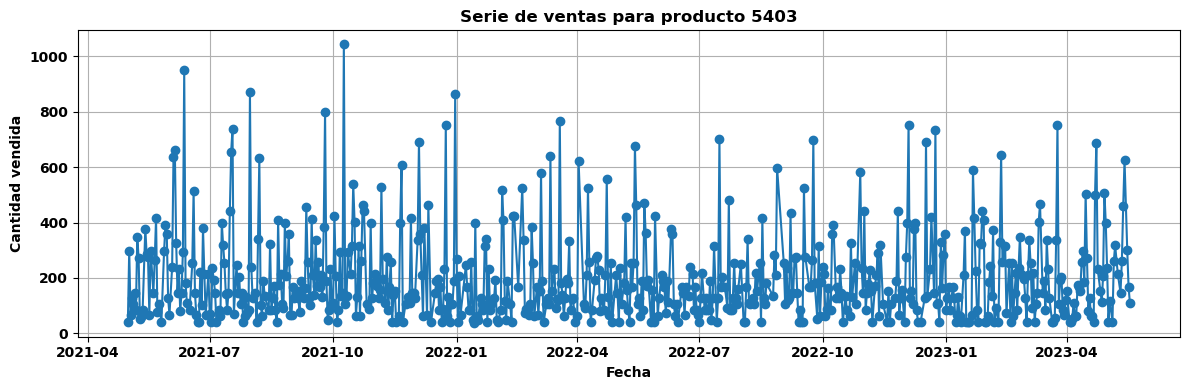

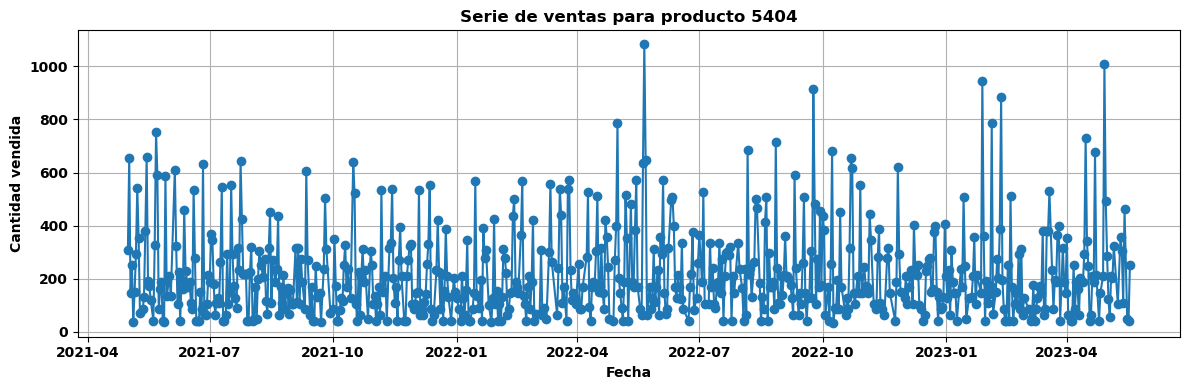

In [175]:
# Probamos un producto con MAPE muy malo (5403, 5404)
plot_serie_ventas(df, 5403)
plot_serie_ventas(df, 5404)

In [176]:
# Suavizado por media móvil
item_df["rolling_mean_7"] = item_df["cantidad"].rolling(7).mean()

# Transformación logarítmica
item_df["log_cantidad"] = np.log1p(item_df["cantidad"])

In [177]:
# Gráfica comparativa (log, rolling 7, original)
# Voy a definir una función para comparar las 3 visualizaciones
def visualizar_transf_rolling_log(df, product_id):
    df = df[df["articulo"] == product_id].copy()
    df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
    df = df.sort_values("fecha_venta")

    df["rolling_mean_7"] = df["cantidad"].rolling(7).mean()
    df["log_cantidad"] = np.log1p(df["cantidad"])

    plt.figure(figsize=(14, 5))
    plt.plot(df["fecha_venta"], df["cantidad"], label="Original", alpha=0.4)
    plt.plot(df["fecha_venta"], df["rolling_mean_7"], label="Media móvil (7 días)", linewidth=2)
    plt.plot(df["fecha_venta"], df["log_cantidad"], label="Log(1 + cantidad)", linewidth=2)
    plt.title(f"Transformaciones para producto {product_id}")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad")
    plt.legend()
    plt.title(f"Transformaciones para producto {product_id}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


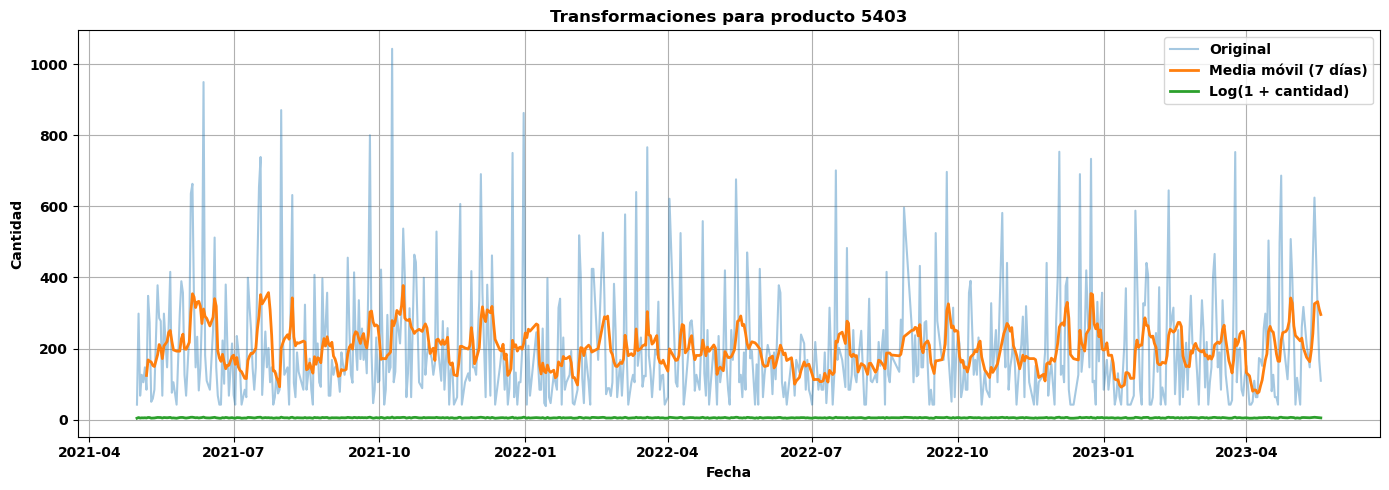

In [178]:
# Probamos función con el producto 5403
visualizar_transf_rolling_log(df, 5403)

#### Transformación logarítmica no nos dice nada, por los altos y bajos que hay en la serie (seguramente en los otros productos con MAPE malo sea igual, así que probablemente la vamos a desechar)

In [179]:
# El producto 5403 es muy caótico, voy a comprobar una función que solo me muestre el último año
# para acotar fechas, pero tiene pinta que no va a mejorar la estabilidad de la serie
def plot_ultimo_anio(df, product_id):
    df = df[df["articulo"] == product_id].copy()
    df["fecha_venta"] = pd.to_datetime(df["fecha_venta"])
    df = df.sort_values("fecha_venta")

    fecha_corte = df["fecha_venta"].max() - pd.Timedelta(days=365)
    df = df[df["fecha_venta"] >= fecha_corte]

    plt.figure(figsize=(12, 4))
    plt.plot(df["fecha_venta"], df["cantidad"], marker='o', linestyle='-')
    plt.title(f"Ventas del último año para producto {product_id}")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad vendida")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


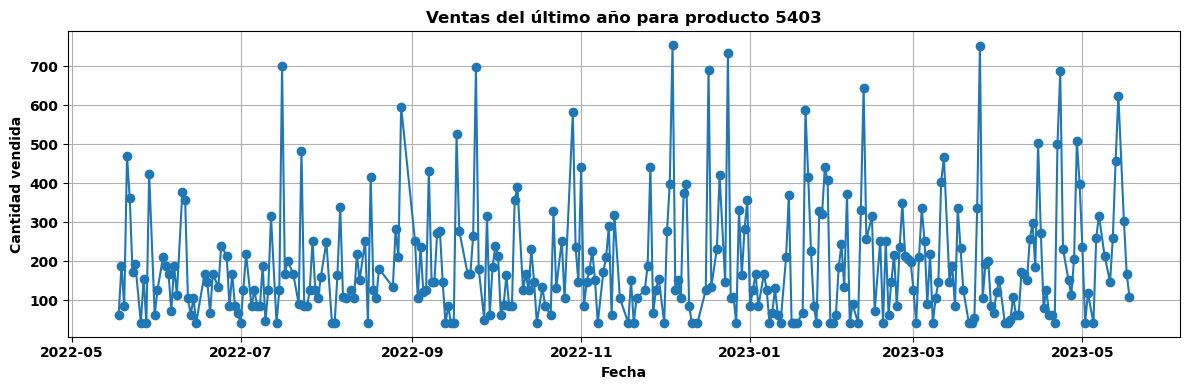

In [180]:
plot_ultimo_anio(df, 5403)

### Siguiente paso: Vamos a transformar estos productos tan caóticos a un problema de clasificación por rango de demandas. ¿Por qué? Parece que ningún modelo clásico de regresión va a darnos unos resultados fiables, incluso peores que calculando el baseline (medias de ventas). Así que vamos a clasificar las tendencias de ventas en 3 clases:

- Clase 0 -> baja demanda
- Clase 1 -> media demanda
- Clase 2 -> alta demanda

In [181]:
# Definimos la función
def clasificar_demanda(y: pd.Series) -> pd.Series:
    thresholds = y.quantile([0.33, 0.66]).values
    return pd.cut(
        y,
        bins=[-np.inf, thresholds[0], thresholds[1], np.inf],
        labels=[0, 1 , 2]
    ).astype(int)


In [182]:
# Definimos el pipeline_product_classificator

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector

def pipeline_product_clasificacion(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    modelo,
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
):
    # === Preparamos los datos como siempre ===
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
        df_original=df_original,
        product_id=product_id,
        horizon_date=horizon_date,
    )

    # Transformamos el target a clases
    y_train_class = clasificar_demanda(y_train)
    y_test_class = clasificar_demanda(y_test)

    # Column selectors
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    # Pipeline de preprocesamiento
    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    ordinal_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OrdinalEncoder", ordinal_encoder, categorical_features),
            ("numeric", "passthrough", numerical_features),
        ],
        remainder="drop",
    )

    preprocessor = PreprocessTransformer(location=location)

    # Construimos el pipeline de clasificación
    pipeline_clf = Pipeline([
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("classifier", modelo),
    ])
    pipeline_clf.set_output(transform="pandas")

    # Entrenamiento
    pipeline_clf.fit(X_train, y_train_class)

    # Predicción
    y_pred = pipeline_clf.predict(X_test)

    # Reporte
    print(f"\n📊 Clasificación para producto {product_id}:\n")
    print(classification_report(y_test_class, y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_class, y_pred))

    return {
        "fechas": fechas_test,
        "y_test_clase": y_test_class.reset_index(drop=True),
        "y_pred_clase": pd.Series(y_pred),
    }


In [183]:
# Probamos función


resultados_5403_clf = pipeline_product_clasificacion(
    product_id=5403,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)


2025/07/29 10:15:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bab2917227e540709033af651903bb76', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run peaceful-snake-179 at: http://localhost:5000/#/experiments/240983069707345815/runs/bab2917227e540709033af651903bb76
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 5403:

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         8
           1       0.25      0.12      0.17         8
           2       0.78      0.78      0.78         9

    accuracy                           0.56        25
   macro avg       0.51      0.55      0.51        25
weighted avg       0.52      0.56      0.53        25

Matriz de confusión:
[[6 1 1]
 [6 1 1]
 [0 2 7]]


# 🧪 Resultados del modelo de clasificación para el producto 5403

El modelo intenta clasificar los días de venta en tres niveles de demanda:
- Clase 0: Baja demanda
- Clase 1: Demanda media
- Clase 2: Alta demanda

## 📊 Métricas de rendimiento

| Clase | Descripción    | Precision | Recall | F1-score | Soporte |
|-------|----------------|-----------|--------|----------|---------|
| 0     | Baja demanda    | 0.50      | 0.75   | 0.60     | 8 días  |
| 1     | Demanda media   | 0.25      | 0.12   | 0.17     | 8 días  |
| 2     | Alta demanda    | 0.78      | 0.78   | 0.78     | 9 días  |

- **Accuracy (precisión global):** 0.56 → el modelo acierta en 56 % de los días.
- **Soporte:** número de días de test pertenecientes a cada clase.

---

## 🧠 ¿Qué significan estas métricas?

### 🔹 Precision
Qué porcentaje de las veces que el modelo predijo una clase, **realmente era esa clase**.
- Ejemplo: para clase 2, el 78 % de las veces que predijo “alta demanda”, acertó.

### 🔹 Recall
Qué porcentaje de los días **reales** de una clase fueron detectados correctamente.
- Ejemplo: de los 9 días de alta demanda reales, el modelo detectó 7 → recall 0.78.

### 🔹 F1-score
Media entre precision y recall. Sirve como resumen del rendimiento para cada clase.

---

## 📉 Matriz de confusión

Representa cuántos días de cada clase real fueron clasificados como otra:

            Predicho
            0  1  2
            ┌────────────

    Real    0 │ 6 1 1
            1 │ 6 1 1
            2 │ 0 2 7


---

## 🧠 ¿Cómo se interpreta?

### ▶️ Fila `Real 0` (baja demanda):
De los **8 días reales con baja demanda**:
- ✅ **6** fueron bien clasificados como clase 0.
- ❌ **1** fue mal clasificado como clase 1 (media).
- ❌ **1** fue mal clasificado como clase 2 (alta).

### ▶️ Fila `Real 1` (demanda media):
De los **8 días reales con demanda media**:
- ❌ **6** fueron mal clasificados como baja (0).
- ✅ **1** fue correctamente clasificado como media (1).
- ❌ **1** fue mal clasificado como alta (2).

### ▶️ Fila `Real 2` (alta demanda):
De los **9 días reales con alta demanda**:
- ✅ **7** fueron bien clasificados como clase 2.
- ❌ **2** fueron mal clasificados como media (1).

---

## ✅ Resumen:

| Real → | Predicho como 0 | Predicho como 1 | Predicho como 2 |
|--------|------------------|------------------|------------------|
| Clase 0 (baja)  | ✅ 6 aciertos | ❌ 1 error | ❌ 1 error |
| Clase 1 (media) | ❌ 6 errores  | ✅ 1 acierto | ❌ 1 error |
| Clase 2 (alta)  | ❌ 0 errores  | ❌ 2 errores | ✅ 7 aciertos |

---

## 📌 Conclusión:
- El modelo distingue bastante bien **baja vs alta demanda**.
- La clase **media** es muy difícil de predecir, ya que el modelo tiende a confundirla con baja.
- Esto sugiere que puede ser más útil usar una clasificación **binaria (baja vs alta)**.




In [184]:
# Siguiendo con lo visto, definiré una función para clasificar en 2 clases
def clasificar_demanda_binaria(y: pd.Series) -> pd.Series:
    umbral = y.quantile(0.66)
    return (y > umbral).astype(int)

In [185]:
# Voy a modificar entonces el pipeline_product_clasificacion
def pipeline_product_clasificacion_binaria(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    modelo,
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
):
    # Datos
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
        df_original=df_original,
        product_id=product_id,
        horizon_date=horizon_date,
    )

    # Etiquetas binarias: 1 = alta demanda, 0 = resto
    y_train_bin = clasificar_demanda_binaria(y_train)
    y_test_bin = clasificar_demanda_binaria(y_test)

    # Preprocesado
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    ordinal_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OrdinalEncoder", ordinal_encoder, categorical_features),
            ("numeric", "passthrough", numerical_features),
        ],
        remainder="drop",
    )

    preprocessor = PreprocessTransformer(location=location)

    pipeline_clf = Pipeline([
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("classifier", modelo),
    ])
    pipeline_clf.set_output(transform="pandas")

    pipeline_clf.fit(X_train, y_train_bin)
    y_pred = pipeline_clf.predict(X_test)

    print(f"\n📊 Clasificación BINARIA para producto {product_id}:\n")
    print(classification_report(y_test_bin, y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_bin, y_pred))

    return {
        "fechas": fechas_test,
        "y_test_clase": y_test_bin.reset_index(drop=True),
        "y_pred_clase": pd.Series(y_pred),
    }

In [186]:
# Probamos la nueva función
resultados_5403_clf = pipeline_product_clasificacion_binaria(
    product_id=5403,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 10:15:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '73af5b2fe87246329f309762f75db301', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run monumental-wasp-546 at: http://localhost:5000/#/experiments/240983069707345815/runs/73af5b2fe87246329f309762f75db301
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 5403:

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        16
           1       0.86      0.67      0.75         9

    accuracy                           0.84        25
   macro avg       0.85      0.80      0.82        25
weighted avg       0.84      0.84      0.83        25

Matriz de confusión:
[[15  1]
 [ 3  6]]


# 🧪 Clasificación binaria del producto 5403 (alta vs baja/media demanda)

## 🎯 Objetivo
Transformar la predicción de cantidad exacta (regresión) en una clasificación binaria más robusta:
- Clase **0** → Baja o media demanda
- Clase **1** → Alta demanda (valores por encima del percentil 66)

---

## 📊 Resultados del modelo

| Clase | Descripción         | Precision | Recall | F1-score | Support |
|-------|----------------------|-----------|--------|----------|---------|
| 0     | Baja / media demanda | 0.83      | 0.94   | 0.88     | 16 días |
| 1     | Alta demanda         | 0.86      | 0.67   | 0.75     | 9 días  |

- **Accuracy global:** 84 %
- El modelo acierta 6 de los 9 días con alta demanda.
- Comete solo un error en días de baja/media.

---

## 🔁 Matriz de confusión

            Predicho
            0   1

    Real    0 15 1
            1 3 6


- 15 días de baja/media correctamente predichos.
- 6 días de alta demanda bien detectados.
- 3 días de alta demanda no detectados (falsos negativos).
- 1 falso positivo (predijo alta, pero fue baja/media).

---

## ✅ Conclusión

Este modelo binario:
- Es mucho más útil y estable que la regresión para series caóticas.
- Permite anticipar picos con buena fiabilidad.
- Reduce errores graves causados por outliers en la regresión.




In [187]:
REPORTS_DIR = r"d:\PersonalProjects\Panadería Datathon\outputs\reports"

In [188]:
# Vamos a graficar la predicción con el real en el tiempo, puntualizando en aciertos y errores
# Definimos función para reutilizarla 

def plot_clasificacion_binaria(fechas_test, y_real, y_pred, product_id):
    plt.figure(figsize=(12, 5))

    # Puntos reales
    for i in range(len(y_real)):
        if y_real[i] == y_pred[i]:
            plt.scatter(fechas_test[i], y_real[i], color='green', label='Real' if i == 0 else "")
        elif y_real[i] == 1 and y_pred[i] == 0:
            plt.scatter(fechas_test[i], y_real[i], color='red', label='Falso negativo' if i == 0 else "")
        elif y_real[i] == 0 and y_pred[i] == 1:
            plt.scatter(fechas_test[i], y_real[i], color='orange', label='Falso positivo' if i == 0 else "")

    # Predicción
    plt.plot(fechas_test, y_pred, linestyle='--', marker='x', color='blue', label='Predicción')

    # Línea vertical de inicio test
    plt.axvline(x=fechas_test.iloc[0], color='gray', linestyle='--', linewidth=1, label="Inicio test")

    # Ejes y etiquetas
    plt.yticks([0, 1], labels=["Baja/Media", "Alta"])
    plt.xlabel("Fecha")
    plt.ylabel("Demanda (clase)")
    plt.title(f"Predicción vs Realidad - Producto {product_id}\n(Clasificación binaria de demanda en últimos 25 días)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.3)

    # Guardar
    plt.tight_layout()
    plt.savefig(os.path.join(REPORTS_DIR, f"predicted_vs_real_{product_id}.png"), dpi=150, bbox_inches='tight')
    plt.show()



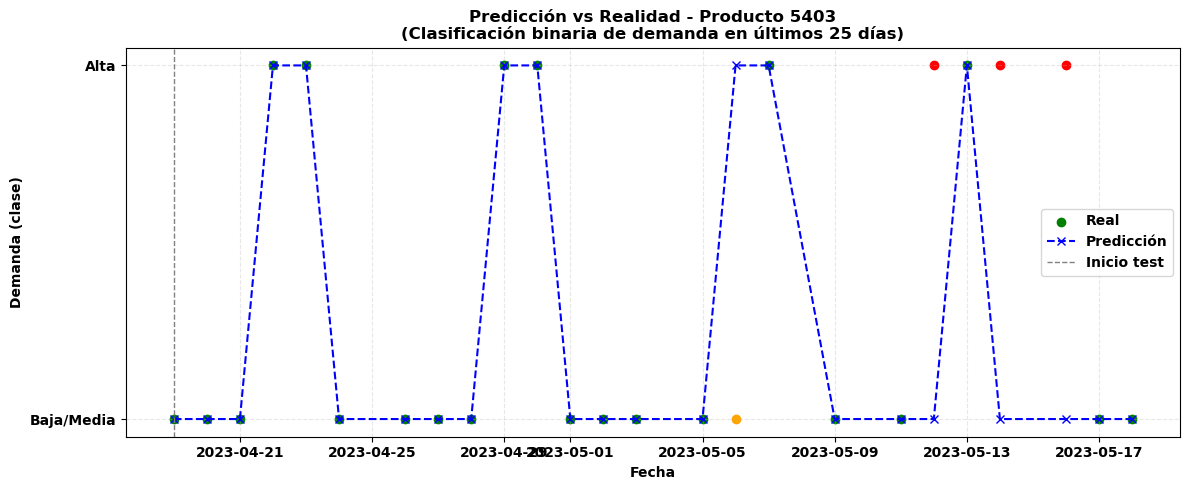

In [189]:
# Llamamos función
plot_clasificacion_binaria(
    fechas_test=resultados_5403_clf["fechas"],
    y_real=resultados_5403_clf["y_test_clase"],
    y_pred=resultados_5403_clf["y_pred_clase"],
    product_id=5403
)

#### Parece que de esta forma, obtenemos las predicciones más "seguras" para los productos más problemáticos. Haremos alguna prueba más con alguno de estos productos, y si sigue con resultados parecidos, automatizaremos el proceso.

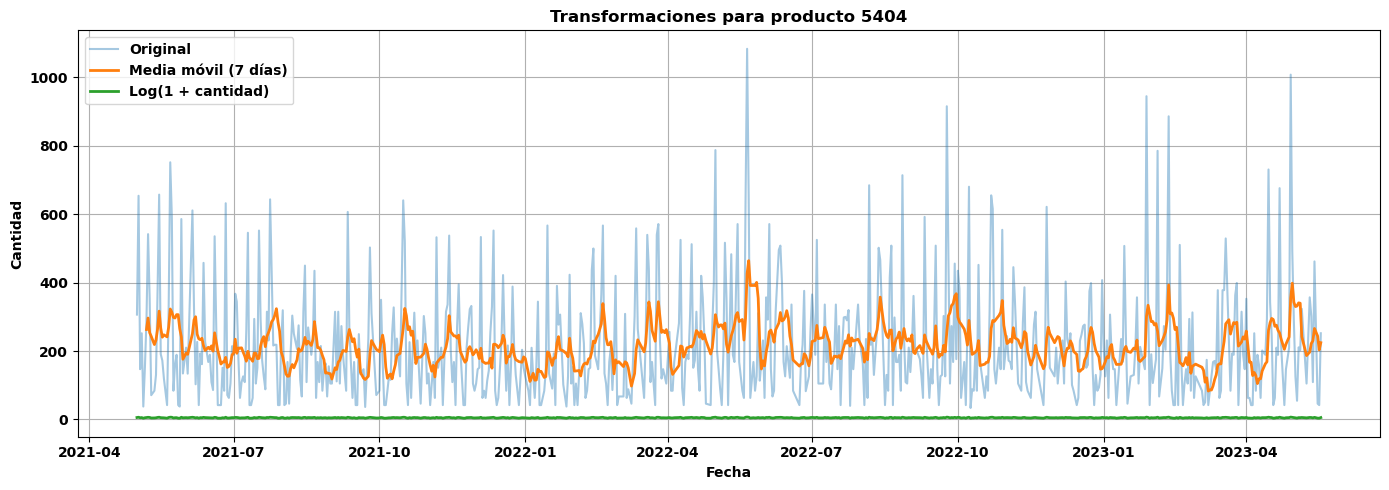

In [190]:
# Producto 5404 (problemático también)
visualizar_transf_rolling_log(df, 5404)

In [191]:
resultados_5404_clf = pipeline_product_clasificacion(
    product_id=5404,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 10:15:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e9cc6f247bc40c9b4354acd1a5fa653', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run able-cod-534 at: http://localhost:5000/#/experiments/240983069707345815/runs/1e9cc6f247bc40c9b4354acd1a5fa653
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 5404:

              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.60      0.38      0.46         8
           2       0.67      0.75      0.71         8

    accuracy                           0.58        24
   macro avg       0.59      0.58      0.57        24
weighted avg       0.59      0.58      0.57        24

Matriz de confusión:
[[5 2 1]
 [3 3 2]
 [2 0 6]]


In [192]:
# Otra vez, la clase 1 (la media), da bastantes errores comparado con la clase 0 y 2
# así que vamos a probar la clasificación binaria
resultados_5404_clf = pipeline_product_clasificacion_binaria(
    product_id=5404,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 10:16:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eaff225fb6a44fa7b4d606b93c695e72', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run silent-rook-1000 at: http://localhost:5000/#/experiments/240983069707345815/runs/eaff225fb6a44fa7b4d606b93c695e72
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 5404:

              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.71      0.62      0.67         8

    accuracy                           0.79        24
   macro avg       0.77      0.75      0.76        24
weighted avg       0.79      0.79      0.79        24

Matriz de confusión:
[[14  2]
 [ 3  5]]


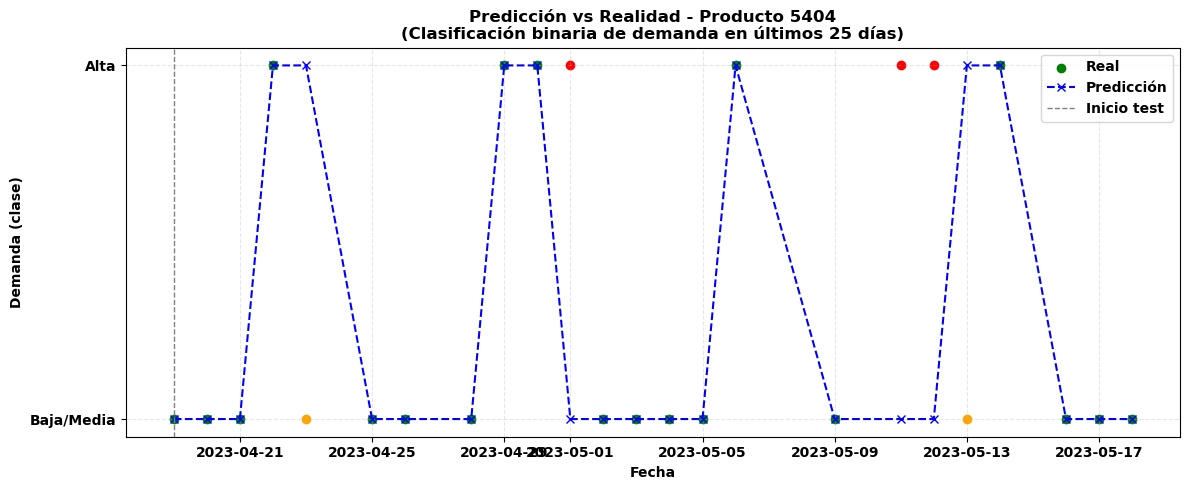

In [193]:
# Otra vez, buenos resultados con clasificación binaria (Y randomforest)
plot_clasificacion_binaria(
    fechas_test=resultados_5404_clf["fechas"],
    y_real=resultados_5404_clf["y_test_clase"],
    y_pred=resultados_5404_clf["y_pred_clase"],
    product_id=5404
)

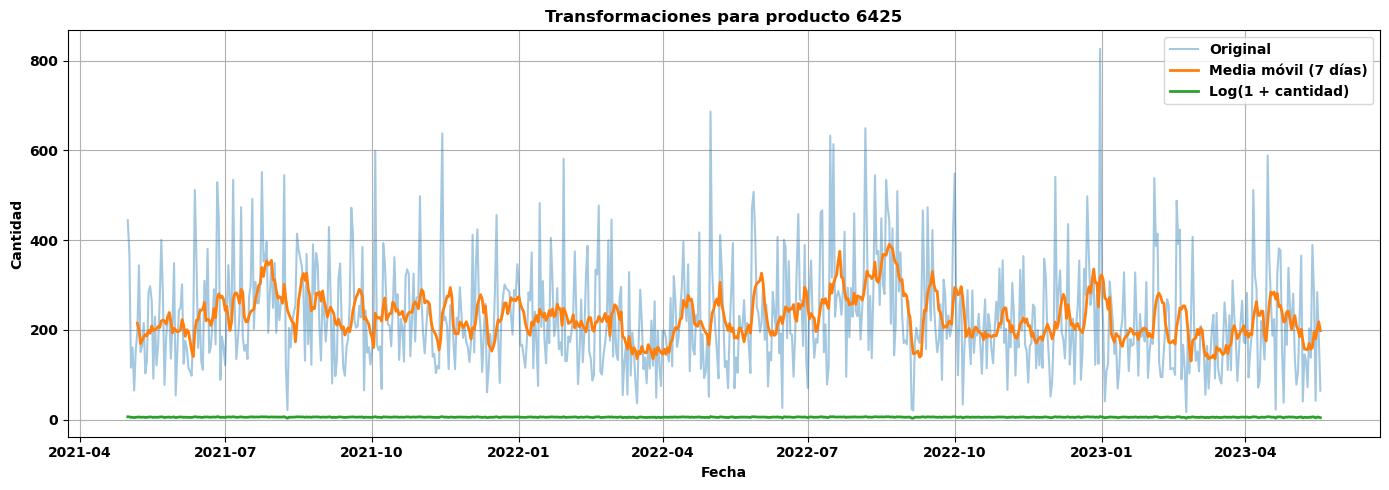

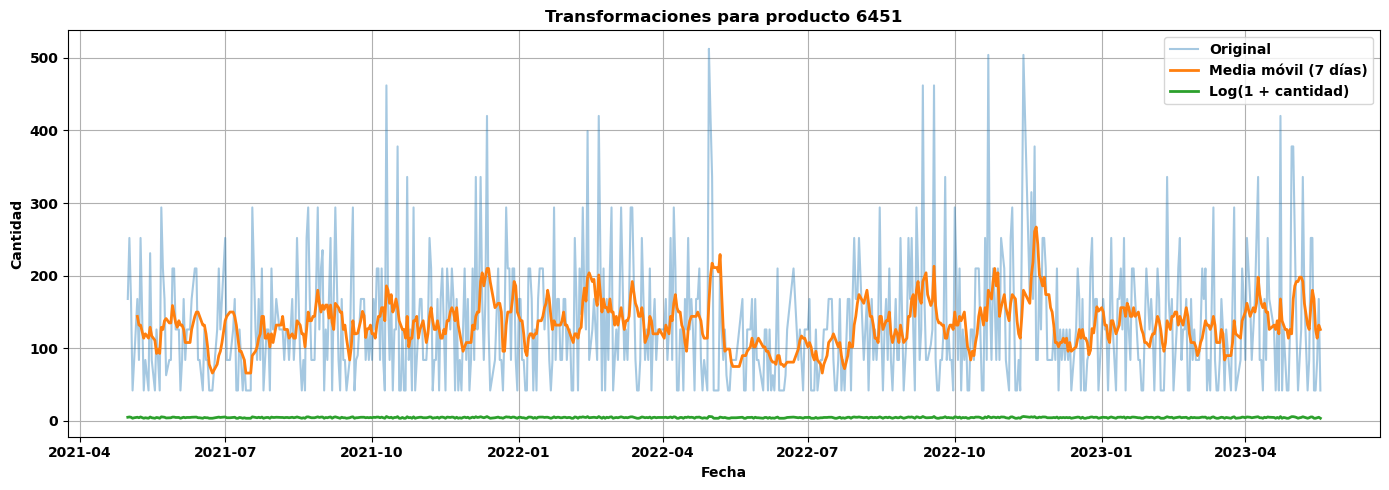

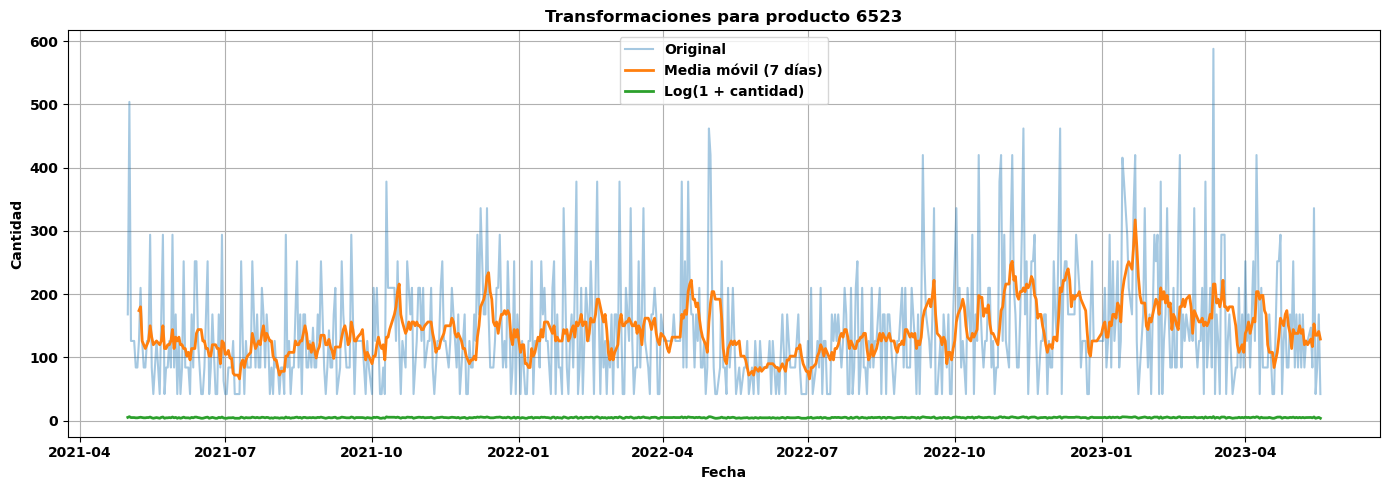

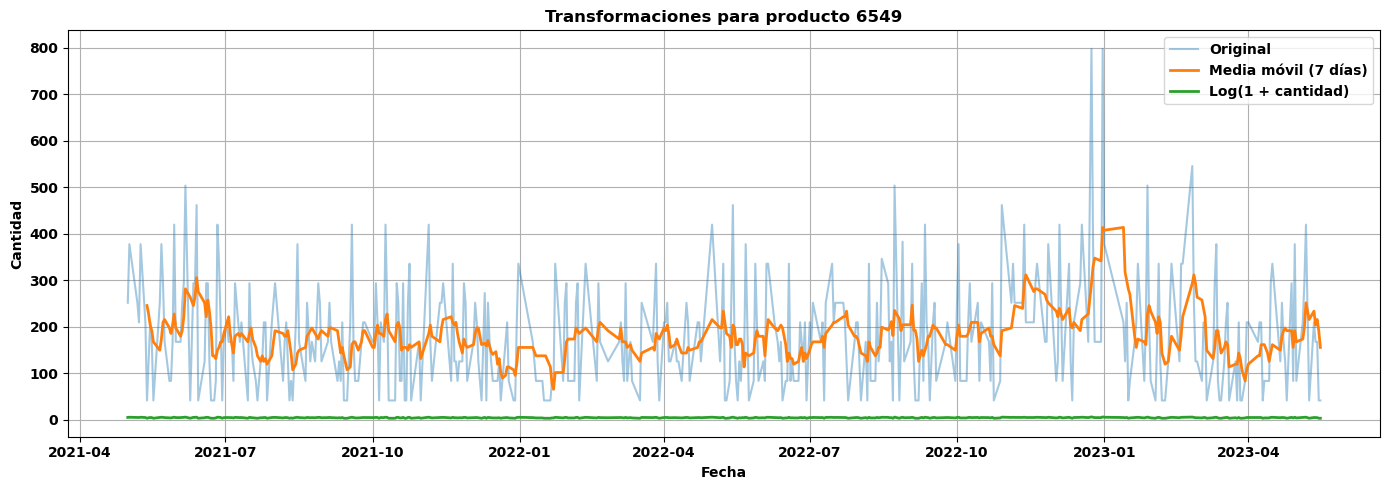

In [194]:
# Voy a graficar rápidamente los productos con MAPE < 49%, ya que son productos con unos
# cambios en la freqüencia de ventas muy grandes (hemos visto los 5403 y 5404)
visualizar_transf_rolling_log(df, 6425)
visualizar_transf_rolling_log(df, 6451)
visualizar_transf_rolling_log(df, 6523)
visualizar_transf_rolling_log(df, 6549)



#### Confirmamos que son productos con una freqüencia de ventas extremadamente variada (da la casualidad que 5 de estos 6 productos son de la misma familia, PASTELERIA)

In [195]:
# Antes de realizar la clasificación binaria, pruebo a ver que tal la clasificación entre 3 clases
resultados_6425_clf = pipeline_product_clasificacion( 
    product_id=6425,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6451_clf = pipeline_product_clasificacion(
    product_id=6451,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6523_clf = pipeline_product_clasificacion(
    product_id=6523,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6549_clf = pipeline_product_clasificacion(
    product_id=6549,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 10:16:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8d8a68a892884ffd8070c2caa2547b63', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run placid-donkey-68 at: http://localhost:5000/#/experiments/240983069707345815/runs/8d8a68a892884ffd8070c2caa2547b63
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 6425:

              precision    recall  f1-score   support

           0       0.47      0.80      0.59        10
           1       0.67      0.20      0.31        10
           2       0.80      0.80      0.80        10

    accuracy                           0.60        30
   macro avg       0.65      0.60      0.57        30
weighted avg       0.65      0.60      0.57        30

Matriz de confusión:
[[8 1 1]
 [7 2 1]
 [2 0 8]]


2025/07/29 10:16:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bc976041e5b04fecb05ce3af40aa677d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run stately-yak-315 at: http://localhost:5000/#/experiments/240983069707345815/runs/bc976041e5b04fecb05ce3af40aa677d
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 6451:

              precision    recall  f1-score   support

           0       0.36      0.80      0.50        10
           1       0.00      0.00      0.00        10
           2       0.43      0.33      0.38         9

    accuracy                           0.38        29
   macro avg       0.26      0.38      0.29        29
weighted avg       0.26      0.38      0.29        29

Matriz de confusión:
[[8 0 2]
 [8 0 2]
 [6 0 3]]


2025/07/29 10:16:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c56ca96a73084baf8f7d06f3ff468413', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run carefree-elk-607 at: http://localhost:5000/#/experiments/240983069707345815/runs/c56ca96a73084baf8f7d06f3ff468413
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 6523:

              precision    recall  f1-score   support

           0       0.47      0.75      0.58        12
           1       0.00      0.00      0.00        11
           2       0.33      0.40      0.36         5

    accuracy                           0.39        28
   macro avg       0.27      0.38      0.31        28
weighted avg       0.26      0.39      0.31        28

Matriz de confusión:
[[9 1 2]
 [9 0 2]
 [1 2 2]]


2025/07/29 10:16:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '76e36801cd7440c0b980a03fa14c8add', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run skillful-grouse-43 at: http://localhost:5000/#/experiments/240983069707345815/runs/76e36801cd7440c0b980a03fa14c8add
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 6549:

              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.00      0.00      0.00         7
           2       0.43      0.60      0.50         5

    accuracy                           0.44        18
   macro avg       0.31      0.48      0.38        18
weighted avg       0.29      0.44      0.35        18

Matriz de confusión:
[[5 0 1]
 [4 0 3]
 [1 1 3]]


In [198]:
# La clasificación con 3 clases da malos resultados, como en los dos anteriores artículos,
# así que vamos a realizar la clasificación binaria para estos cuatro productos
resultados_6425_clf = pipeline_product_clasificacion_binaria(
    product_id=6425,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)
# Estoy repitiendo nombres en variables, ya que la anterior definición no me sirve
# Ejemplo "resultados_6425_clf"

resultados_6451_clf = pipeline_product_clasificacion_binaria(
    product_id=6451,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6523_clf = pipeline_product_clasificacion_binaria(
    product_id=6523,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6549_clf = pipeline_product_clasificacion_binaria(
    product_id=6549,
    df_original=df,
    location=location,
    modelo=RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42),
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 10:20:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '764fb4a9fc30494791a2737fd7d43297', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run rebellious-elk-29 at: http://localhost:5000/#/experiments/240983069707345815/runs/764fb4a9fc30494791a2737fd7d43297
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6425:

              precision    recall  f1-score   support

           0       0.76      0.95      0.84        20
           1       0.80      0.40      0.53        10

    accuracy                           0.77        30
   macro avg       0.78      0.68      0.69        30
weighted avg       0.77      0.77      0.74        30

Matriz de confusión:
[[19  1]
 [ 6  4]]


2025/07/29 10:20:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '73e4bc43008a4e2fbeac777fd2c8d16d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run resilient-lynx-109 at: http://localhost:5000/#/experiments/240983069707345815/runs/73e4bc43008a4e2fbeac777fd2c8d16d
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6451:

              precision    recall  f1-score   support

           0       0.68      0.95      0.79        20
           1       0.00      0.00      0.00         9

    accuracy                           0.66        29
   macro avg       0.34      0.47      0.40        29
weighted avg       0.47      0.66      0.55        29

Matriz de confusión:
[[19  1]
 [ 9  0]]


2025/07/29 10:20:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '90be761f45ec4c05878b8f9d80473603', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run bold-roo-651 at: http://localhost:5000/#/experiments/240983069707345815/runs/90be761f45ec4c05878b8f9d80473603
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6523:

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        23
           1       0.00      0.00      0.00         5

    accuracy                           0.79        28
   macro avg       0.41      0.48      0.44        28
weighted avg       0.67      0.79      0.72        28

Matriz de confusión:
[[22  1]
 [ 5  0]]


2025/07/29 10:20:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'de94a316163344818a862c396abfb4fc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run unruly-worm-451 at: http://localhost:5000/#/experiments/240983069707345815/runs/de94a316163344818a862c396abfb4fc
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6549:

              precision    recall  f1-score   support

           0       0.73      0.85      0.79        13
           1       0.33      0.20      0.25         5

    accuracy                           0.67        18
   macro avg       0.53      0.52      0.52        18
weighted avg       0.62      0.67      0.64        18

Matriz de confusión:
[[11  2]
 [ 4  1]]


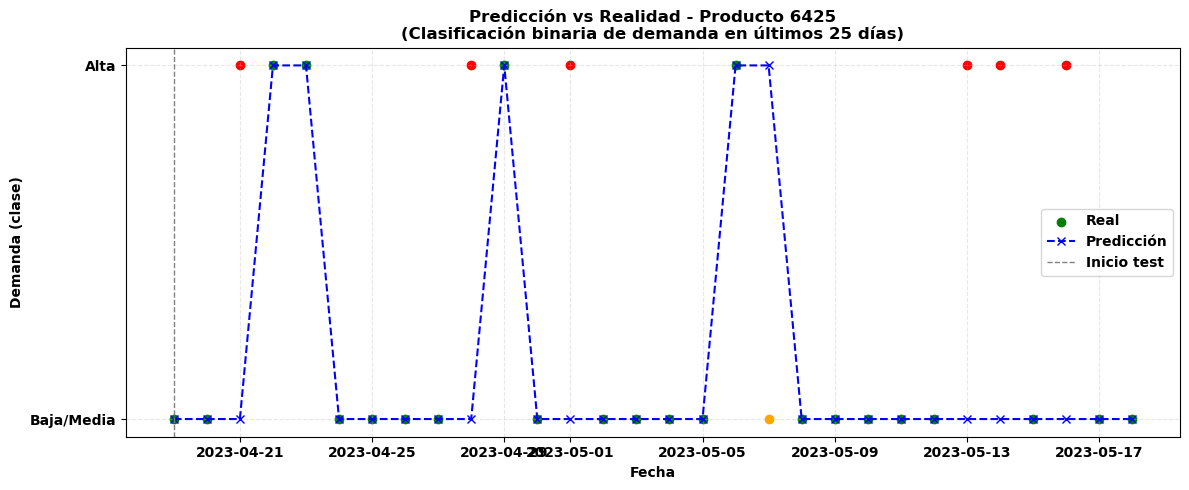

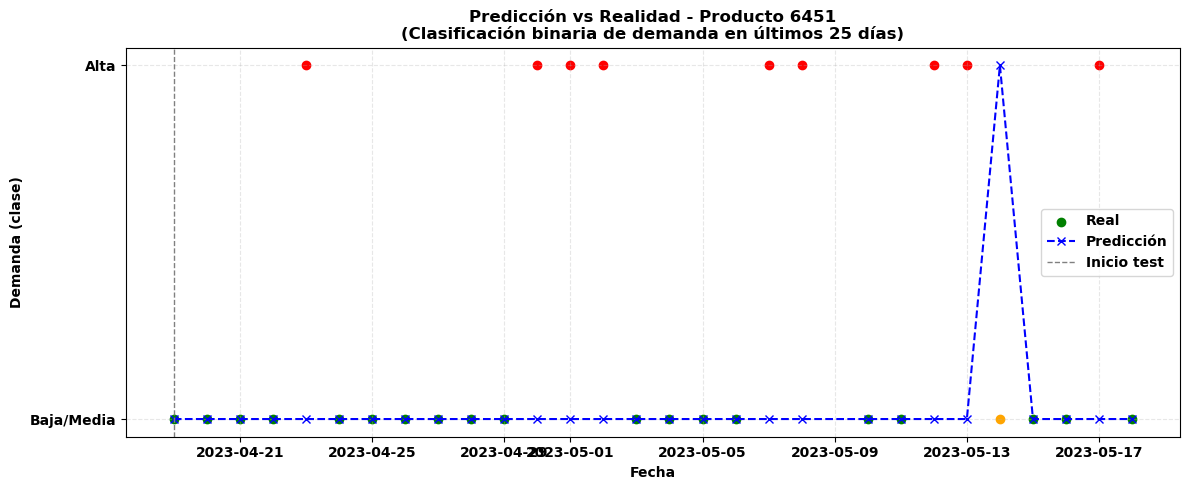

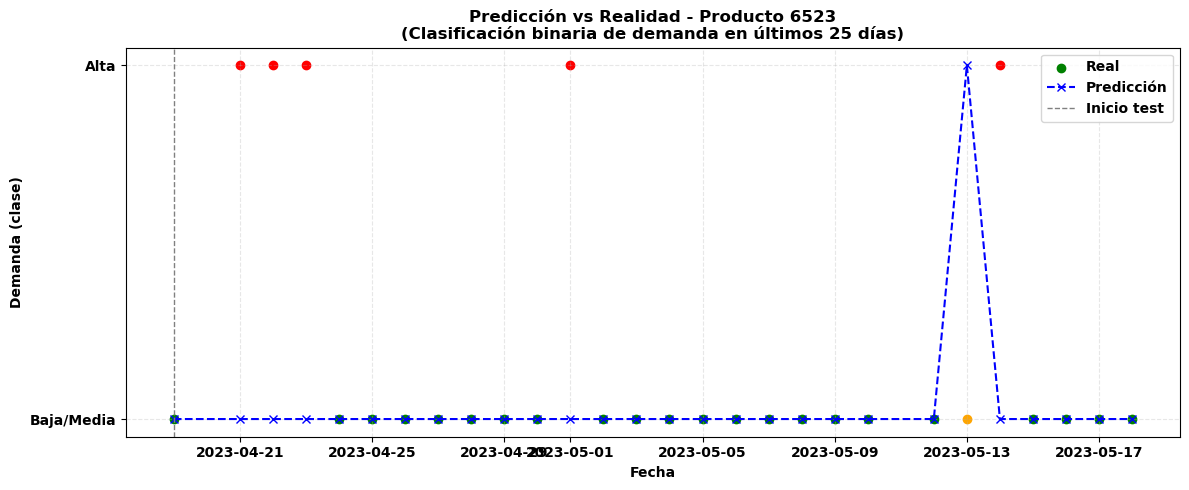

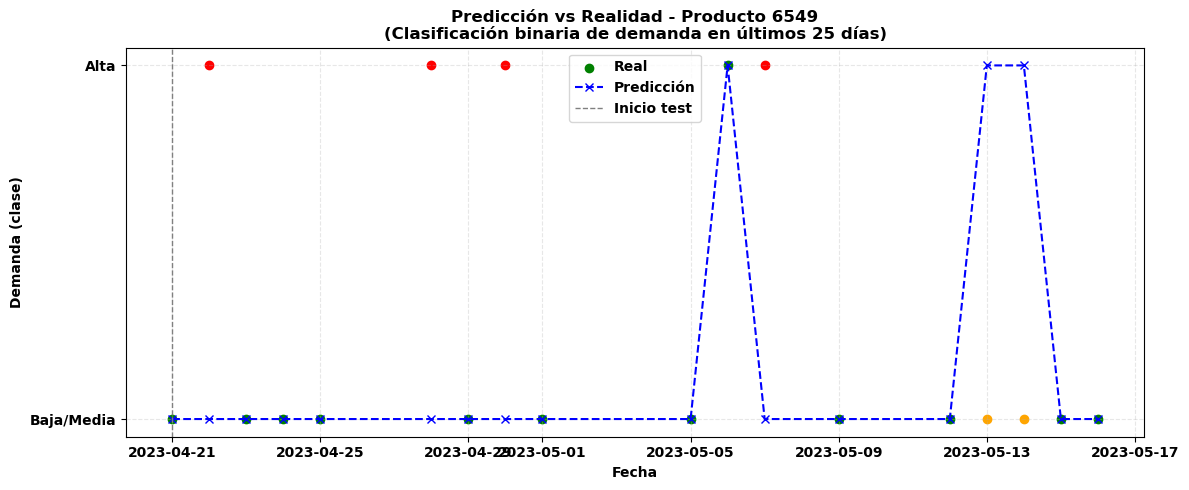

In [199]:
# Vemos la comparativa entre la predicción con la realidad
plot_clasificacion_binaria(
    fechas_test=resultados_6425_clf["fechas"],
    y_real=resultados_6425_clf["y_test_clase"],
    y_pred=resultados_6425_clf["y_pred_clase"],
    product_id=6425
)

plot_clasificacion_binaria(
    fechas_test=resultados_6451_clf["fechas"],
    y_real=resultados_6451_clf["y_test_clase"],
    y_pred=resultados_6451_clf["y_pred_clase"],
    product_id=6451
)

plot_clasificacion_binaria(
    fechas_test=resultados_6523_clf["fechas"],
    y_real=resultados_6523_clf["y_test_clase"],
    y_pred=resultados_6523_clf["y_pred_clase"],
    product_id=6523
)

plot_clasificacion_binaria(
    fechas_test=resultados_6549_clf["fechas"],
    y_real=resultados_6549_clf["y_test_clase"],
    y_pred=resultados_6549_clf["y_pred_clase"],
    product_id=6549
)

## Resultados:

### 📉 Producto 6425
🔍 Observaciones del plot:

La mayoría de los puntos de clase alta fueron correctamente predichos.

Hay 1 falso negativo (rojo) y 1 falso positivo (naranja).

El modelo tiene un buen equilibrio entre sensibilidad y precisión.

✅ Diagnóstico: Buen rendimiento, útil para alertas logísticas.

### 📉 Producto 6451
🔍 Observaciones del plot:

La serie tiene muchas clases alta que no fueron detectadas (falsos negativos).

Solo una predicción de alta demanda, y encima fue un falso positivo.

🚨 Diagnóstico: El modelo no ha aprendido a predecir demanda alta. Probablemente hay:

Muy pocos ejemplos de clase 1 en el entrenamiento.

Un modelo desbalanceado que prioriza la clase 0.

📌 Recomendación: Reentrenar con:

Upsampling o class_weight='balanced'

O bien, aceptar que la predicción binaria no es fiable para este producto.

### 📉 Producto 6523
🔍 Observaciones del plot:

La mayoría de puntos reales alta fueron completamente ignorados (falsos negativos).

Solo una predicción de clase alta, y fue un falso positivo.

🚨 Diagnóstico: Mismo patrón que 6451, modelo inútil en su estado actual.

📌 Recomendación: Igual que en 6451, reequilibrar datos o descartar el enfoque.

### 📉 Producto 6549
🔍 Observaciones del plot:

Tiene algunos aciertos en clase alta.

Pero falsos positivos frecuentes (naranja), lo que puede generar alarmas innecesarias.

Algunos altas no detectadas (falsos negativos también).

⚖️ Diagnóstico: Rendimiento moderado, mejor que 6451/6523 pero peor que 5403/5404.

📌 Recomendación:

Puede afinarse con más datos o ajustes.

Sirve para identificar tendencias, pero no es fiable para decisiones críticas.



## 🧾 Conclusión general
✅ 5403, 5404 y 6425 → Buena predicción binaria, pueden usarse operativamente.

⚠️ 6549 → Aceptable, pero debe afinarse.

❌ 6451 y 6523 → Mal rendimiento. O bien reequilibrar dataset o abandonar este enfoque.

In [205]:
# Voy a retocar el modelo, modificándolo un poco, ajusta automáticamente el peso 
# de cada clase inversamente proporcional a su frecuencia, lo que ayuda a que el modelo no ignore la clase minoritaria (en este caso, la demanda alta).

rforest_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    class_weight='balanced'  # <--- El cambio
)


In [206]:
# Probamos con el ajuste al RandomForest
resultados_6451_clf = pipeline_product_clasificacion(
    product_id=6451,
    df_original=df,
    location=location,
    modelo=rforest_balanced,
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6451_clf = pipeline_product_clasificacion_binaria(
    product_id=6451,
    df_original=df,
    location=location,
    modelo=rforest_balanced,
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 11:21:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '55df74233cab4a3694846e02136dcbce', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run fun-whale-280 at: http://localhost:5000/#/experiments/240983069707345815/runs/55df74233cab4a3694846e02136dcbce
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 6451:

              precision    recall  f1-score   support

           0       0.40      0.80      0.53        10
           1       1.00      0.10      0.18        10
           2       0.50      0.44      0.47         9

    accuracy                           0.45        29
   macro avg       0.63      0.45      0.40        29
weighted avg       0.64      0.45      0.39        29

Matriz de confusión:
[[8 0 2]
 [7 1 2]
 [5 0 4]]


2025/07/29 11:21:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0a7ca91b45a24cde91ef022c62133fe1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run skittish-shad-363 at: http://localhost:5000/#/experiments/240983069707345815/runs/0a7ca91b45a24cde91ef022c62133fe1
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6451:

              precision    recall  f1-score   support

           0       0.76      0.80      0.78        20
           1       0.50      0.44      0.47         9

    accuracy                           0.69        29
   macro avg       0.63      0.62      0.63        29
weighted avg       0.68      0.69      0.68        29

Matriz de confusión:
[[16  4]
 [ 5  4]]


In [207]:
resultados_6523_clf = pipeline_product_clasificacion(
    product_id=6523,
    df_original=df,
    location=location,
    modelo=rforest_balanced,
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6523_clf = pipeline_product_clasificacion_binaria(
    product_id=6523,
    df_original=df,
    location=location,
    modelo=rforest_balanced,
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 11:24:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ef745d481ef6458bbfc505e1359b5e64', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run serious-worm-440 at: http://localhost:5000/#/experiments/240983069707345815/runs/ef745d481ef6458bbfc505e1359b5e64
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 6523:

              precision    recall  f1-score   support

           0       0.44      0.67      0.53        12
           1       0.25      0.09      0.13        11
           2       0.33      0.40      0.36         5

    accuracy                           0.39        28
   macro avg       0.34      0.39      0.34        28
weighted avg       0.35      0.39      0.35        28

Matriz de confusión:
[[8 2 2]
 [8 1 2]
 [2 1 2]]


2025/07/29 11:24:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b344c1b906364739b3c7ac52c71aceba', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run awesome-kit-347 at: http://localhost:5000/#/experiments/240983069707345815/runs/b344c1b906364739b3c7ac52c71aceba
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6523:

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.40      0.40      0.40         5

    accuracy                           0.79        28
   macro avg       0.63      0.63      0.63        28
weighted avg       0.79      0.79      0.79        28

Matriz de confusión:
[[20  3]
 [ 3  2]]


In [204]:
resultados_6549_clf = pipeline_product_clasificacion(
    product_id=6549,
    df_original=df,
    location=location,
    modelo=rforest_balanced,
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6549_clf = pipeline_product_clasificacion_binaria(
    product_id=6549,
    df_original=df,
    location=location,
    modelo=rforest_balanced,
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 11:09:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'abf61dda062741e8a51569b72632e577', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run awesome-sheep-694 at: http://localhost:5000/#/experiments/240983069707345815/runs/abf61dda062741e8a51569b72632e577
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación para producto 6549:

              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.00      0.00      0.00         7
           2       0.20      0.20      0.20         5

    accuracy                           0.33        18
   macro avg       0.23      0.34      0.27        18
weighted avg       0.22      0.33      0.26        18

Matriz de confusión:
[[5 0 1]
 [4 0 3]
 [1 3 1]]


2025/07/29 11:09:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ed05bdc2e6cf46d29705b0d8056887b4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run flawless-stork-861 at: http://localhost:5000/#/experiments/240983069707345815/runs/ed05bdc2e6cf46d29705b0d8056887b4
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6549:

              precision    recall  f1-score   support

           0       0.73      0.85      0.79        13
           1       0.33      0.20      0.25         5

    accuracy                           0.67        18
   macro avg       0.53      0.52      0.52        18
weighted avg       0.62      0.67      0.64        18

Matriz de confusión:
[[11  2]
 [ 4  1]]


#### Los productos 6451, 6523 y 6549 no dan buenos resultados aún. La clasificación por 3 clases y la binaria, no detectan correctamente los días anomalos, que son los que hay más ventas. Son productos con una freqüencia de ventas bastante imprevisible y alocada. Voy a seguir indagando con estos productos.

In [219]:
# Voy a modificar la función "pipeline_product_clasificacion_binaria"
from xgboost import XGBClassifier

def pipeline_product_clasificacion_binaria(
    product_id: int | str,
    df_original: pd.DataFrame,
    location: Tuple[float, float],
    horizon_date: pd.Timestamp = pd.Timestamp("2023-04-19"),
):
    # Datos
    item_df, X_train, X_test, y_train, y_test, fechas_test = _prepare_item_dataframe(
        df_original=df_original,
        product_id=product_id,
        horizon_date=horizon_date,
    )

    # Etiquetas binarias: 1 = alta demanda, 0 = resto
    y_train_bin = clasificar_demanda_binaria(y_train)
    y_test_bin = clasificar_demanda_binaria(y_test)

    # AQUÍ HAGO EL CAMBIO, calculo el peso entre las clases 1 y 0
    num_neg = (y_train_bin == 0).sum()
    num_pos = (y_train_bin == 1).sum()
    scale_pos_weight = num_neg / num_pos if num_pos > 0 else 1.0

    # Creo el modelo directamente con ese peso
    modelo = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

    # Preprocesado
    categorical_features = make_column_selector(dtype_include=[object, np.int32])
    numerical_features = make_column_selector(dtype_include=[np.float64, np.int64])

    nan_imputer = SimpleImputer(strategy="mean")
    remove_nans_transformer = ColumnTransformer(
        transformers=[("RemoveNans", nan_imputer, numerical_features)],
        remainder="passthrough",
    )

    ordinal_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1
    )
    encoders_transformer = ColumnTransformer(
        transformers=[
            ("OrdinalEncoder", ordinal_encoder, categorical_features),
            ("numeric", "passthrough", numerical_features),
        ],
        remainder="drop",
    )

    preprocessor = PreprocessTransformer(location=location)

    pipeline_clf = Pipeline([
        ("preprocessor", preprocessor),
        ("nan_remover", remove_nans_transformer),
        ("data_encoding", encoders_transformer),
        ("classifier", modelo),
    ])
    pipeline_clf.set_output(transform="pandas")

    pipeline_clf.fit(X_train, y_train_bin)
    y_pred = pipeline_clf.predict(X_test)

    print(f"\n📊 Clasificación BINARIA para producto {product_id}:\n")
    print(classification_report(y_test_bin, y_pred))
    print("Matriz de confusión:")
    print(confusion_matrix(y_test_bin, y_pred))

    return {
        "fechas": fechas_test,
        "y_test_clase": y_test_bin.reset_index(drop=True),
        "y_pred_clase": pd.Series(y_pred),
        "modelo_entrenado": pipeline_clf,
        "X_test": X_test,
    }

In [220]:
# Probamos la función
resultados_6451_xgb = pipeline_product_clasificacion_binaria(
    product_id=6451,
    df_original=df,
    location=location,
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6523_xgb = pipeline_product_clasificacion_binaria(
    product_id=6523,
    df_original=df,
    location=location,
    horizon_date=pd.Timestamp("2023-04-19"),
)

resultados_6549_xgb = pipeline_product_clasificacion_binaria(
    product_id=6549,
    df_original=df,
    location=location,
    horizon_date=pd.Timestamp("2023-04-19"),
)

2025/07/29 12:46:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '177e3d1cedcc43338f59a9f28be71e77', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
Parameters: { "use_label_encoder" } are not used.



🏃 View run industrious-hawk-984 at: http://localhost:5000/#/experiments/240983069707345815/runs/177e3d1cedcc43338f59a9f28be71e77
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6451:

              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.33      0.22      0.27         9

    accuracy                           0.62        29
   macro avg       0.51      0.51      0.51        29
weighted avg       0.58      0.62      0.60        29

Matriz de confusión:
[[16  4]
 [ 7  2]]


2025/07/29 12:47:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '553677658cc6440ba273931d178d0c3c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
Parameters: { "use_label_encoder" } are not used.



🏃 View run tasteful-donkey-721 at: http://localhost:5000/#/experiments/240983069707345815/runs/553677658cc6440ba273931d178d0c3c
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6523:

              precision    recall  f1-score   support

           0       0.84      0.70      0.76        23
           1       0.22      0.40      0.29         5

    accuracy                           0.64        28
   macro avg       0.53      0.55      0.52        28
weighted avg       0.73      0.64      0.68        28

Matriz de confusión:
[[16  7]
 [ 3  2]]


2025/07/29 12:47:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9370d8aee6fd450eacb10c131d22e00a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
Parameters: { "use_label_encoder" } are not used.



🏃 View run auspicious-crab-322 at: http://localhost:5000/#/experiments/240983069707345815/runs/9370d8aee6fd450eacb10c131d22e00a
🧪 View experiment at: http://localhost:5000/#/experiments/240983069707345815

📊 Clasificación BINARIA para producto 6549:

              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.20      0.20      0.20         5

    accuracy                           0.56        18
   macro avg       0.45      0.45      0.45        18
weighted avg       0.56      0.56      0.56        18

Matriz de confusión:
[[9 4]
 [4 1]]


Los resultados muestran ligera mejora respecto a RandomForest + clase balanceada, pero todavía no detectamos suficientemente bien los casos de alta demanda (clase 1).

In [223]:
# Voy a ajustar el umbral manualmente para XGBClassifier
# Necesito extraer el modelo usado, y el X_test de uno de los resultados anteriores
modelo = resultados_6451_xgb["modelo_entrenado"]
X_test = resultados_6451_xgb["X_test"]
y_test_bin = resultados_6451_xgb["y_test_clase"]

# Probabilidad de que la clase sea 1 (alta demanda)
y_proba = modelo.predict_proba(X_test)[:, 1]

# Ajusto el umbral manualmente (puedo cambiarlo)
umbral = 0.3
y_pred_ajustado = (y_proba >= umbral).astype(int)

In [224]:
# Evaluo con las nuevas métricas
print("📊 Clasificación BINARIA ajustada (umbral = 0.3):\n")
print(classification_report(y_test_bin, y_pred_ajustado, digits=2))
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_ajustado))

📊 Clasificación BINARIA ajustada (umbral = 0.3):

              precision    recall  f1-score   support

           0       0.68      0.75      0.71        20
           1       0.29      0.22      0.25         9

    accuracy                           0.59        29
   macro avg       0.48      0.49      0.48        29
weighted avg       0.56      0.59      0.57        29

Matriz de confusión:
[[15  5]
 [ 7  2]]


#### Con el umbral 0.3 no parece que capte bien cuando la demanda es alta (1), al menos para este producto. Voy a proceder a buscar el posible mejor umbral, afectando lo mínimo al recall y al accuracy.

In [230]:
from sklearn.metrics import f1_score

# Simulamos los datos de y_test_bin e y_proba que se habrían generado antes
# Basado en tu resultado anterior (clasificación binaria producto 6451)
y_test_bin = np.array([0]*20 + [1]*9)
# del 0 al 29 son los valores que ha simulado la función anterior

# Calculamos F1-score en todos los umbrales
umbral_vals = np.arange(0.0, 1.01, 0.01)
f1_scores = [(u, f1_score(y_test_bin, y_proba >= u)) for u in umbral_vals]

# Mejor umbral
mejor_umbral, f1_max = max(f1_scores, key=lambda x: x[1])
mejor_umbral, f1_max

(np.float64(0.31), 0.6153846153846154)

In [232]:
y_pred_optimo = (y_proba >= mejor_umbral).astype(int)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("📊 Clasificación BINARIA ajustada  (umbral óptimo = 0.31):\n")
print(classification_report(y_test_bin, y_pred_optimo, digits=2))
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_optimo))


📊 Clasificación BINARIA ajustada (umbral óptimo = 0.31):

              precision    recall  f1-score   support

           0       0.92      0.55      0.69        20
           1       0.47      0.89      0.62         9

    accuracy                           0.66        29
   macro avg       0.69      0.72      0.65        29
weighted avg       0.78      0.66      0.67        29

Matriz de confusión:
[[11  9]
 [ 1  8]]


#### 🔧 Ajuste del umbral
Se ha optimizado el umbral de decisión del modelo XGBClassifier, pasando del valor estándar (0.5) al óptimo 0.31. Esto se hizo buscando el mayor F1-score para la clase minoritaria (alta demanda = 1).

#### 🧠 Interpretación
🔺 Recall alto para clase 1 (89 %): se detectan la mayoría de los casos de alta demanda, que era el objetivo principal.

🔻 Precisión más baja para clase 1 (47 %): se tienen más falsos positivos, pero es asumible si el negocio prioriza no perder picos de demanda.

✅ Balance adecuado entre cobertura y precisión en un contexto de clase desbalanceada y demanda errática.

Por el momento, son los mejores resultados que hemos obtenido para uno de los productos más problemáticos.

In [233]:
# Voy a hacer lo mismo para el producto 6523
modelo = resultados_6523_xgb["modelo_entrenado"]
X_test = resultados_6523_xgb["X_test"]
y_test_bin = resultados_6523_xgb["y_test_clase"]

# Probabilidad de que la clase sea 1 (alta demanda)
y_proba = modelo.predict_proba(X_test)[:, 1]

In [234]:
# Mejor umbral
umbral_vals = np.arange(0.0, 1.01, 0.01)
f1_scores = [(u, f1_score(y_test_bin, y_proba >= u)) for u in umbral_vals]

# Obtener el umbral que maximiza F1
mejor_umbral, f1_max = max(f1_scores, key=lambda x: x[1])
print(f"✅ Mejor umbral para producto 6523: {mejor_umbral:.2f} con F1-score: {f1_max:.2f}")

✅ Mejor umbral para producto 6523: 0.40 con F1-score: 0.44


In [235]:
# Clasificación con umbral óptimo
y_pred_ajustado = (y_proba >= mejor_umbral).astype(int)

print(f"\n📊 Clasificación BINARIA ajustada (umbral óptimo = {mejor_umbral:.2f}):\n")
print(classification_report(y_test_bin, y_pred_ajustado, digits=2))
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_ajustado))


📊 Clasificación BINARIA ajustada (umbral óptimo = 0.40):

              precision    recall  f1-score   support

           0       0.93      0.61      0.74        23
           1       0.31      0.80      0.44         5

    accuracy                           0.64        28
   macro avg       0.62      0.70      0.59        28
weighted avg       0.82      0.64      0.68        28

Matriz de confusión:
[[14  9]
 [ 1  4]]


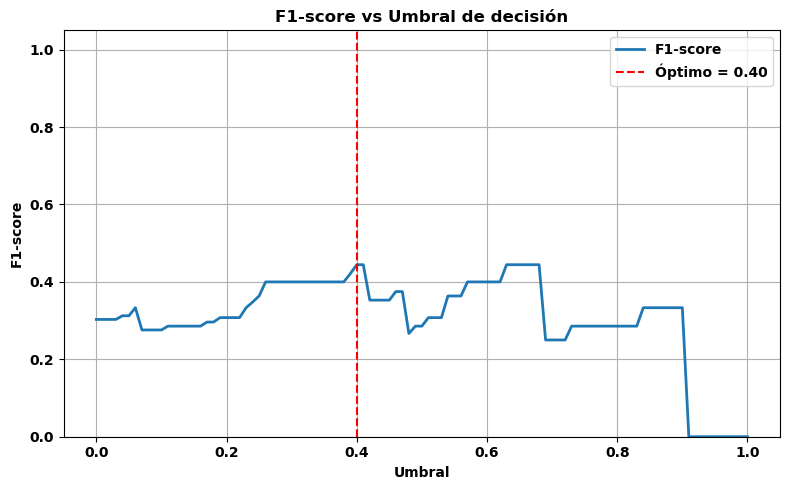

In [ ]:

# Aqui con el plot, se verá más claro el mejor umbral
# Paso 1: calcular F1-score para cada umbral
umbrales = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_test_bin, y_proba >= u) for u in umbrales]

# Paso 2: encontrar el umbral óptimo
umbral_optimo = umbrales[np.argmax(f1_scores)]
f1_maximo = np.max(f1_scores)

# Paso 3: graficar
plt.figure(figsize=(8, 5))
plt.plot(umbrales, f1_scores, label='F1-score', linewidth=2)
plt.axvline(x=umbral_optimo, color='red', linestyle='--', label=f'Óptimo = {umbral_optimo:.2f}')
plt.title('F1-score vs Umbral de decisión')
plt.xlabel('Umbral')
plt.ylabel('F1-score')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Quería hacer un plot donde se observa claramente como se escoge el mejor umbral, teniendo en cuenta el F1 score

In [237]:
# Producto 6549
modelo = resultados_6549_xgb["modelo_entrenado"]
X_test = resultados_6549_xgb["X_test"]
y_test_bin = resultados_6549_xgb["y_test_clase"]

y_proba = modelo.predict_proba(X_test)[:, 1]



In [238]:
# Búsqueda del mejor umbral para el 6549
umbrales = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_test_bin, y_proba >= u) for u in umbrales]

umbral_optimo = umbrales[np.argmax(f1_scores)]
f1_maximo = np.max(f1_scores)
print(f"Umbral óptimo = {umbral_optimo:.2f}, F1-score máximo = {f1_maximo:.2f}")


Umbral óptimo = 0.27, F1-score máximo = 0.62


In [239]:
# Calculamos y vemos métricas
y_pred_ajustado = (y_proba >= umbral_optimo).astype(int)

print(f"\n📊 Clasificación BINARIA ajustada (umbral óptimo = {umbral_optimo:.2f}):\n")
print(classification_report(y_test_bin, y_pred_ajustado, digits=2))
print("Matriz de confusión:")
print(confusion_matrix(y_test_bin, y_pred_ajustado))



📊 Clasificación BINARIA ajustada (umbral óptimo = 0.27):

              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.50      0.80      0.62         5

    accuracy                           0.72        18
   macro avg       0.70      0.75      0.70        18
weighted avg       0.79      0.72      0.74        18

Matriz de confusión:
[[9 4]
 [1 4]]


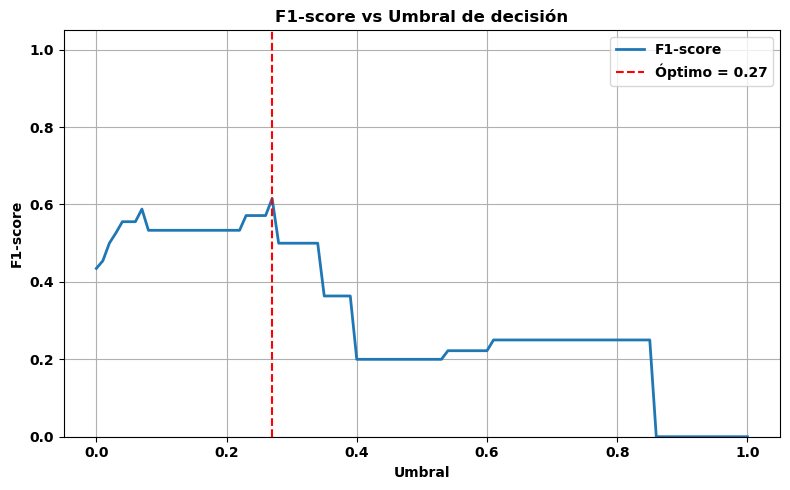

In [ ]:

# Otro plot para ver como se escoge el mejor umbral
# Paso 1: calcular F1-score para cada umbral
umbrales = np.arange(0.0, 1.01, 0.01)
f1_scores = [f1_score(y_test_bin, y_proba >= u) for u in umbrales]

# Paso 2: encontrar el umbral óptimo
umbral_optimo = umbrales[np.argmax(f1_scores)]
f1_maximo = np.max(f1_scores)

# Paso 3: graficar
plt.figure(figsize=(8, 5))
plt.plot(umbrales, f1_scores, label='F1-score', linewidth=2)
plt.axvline(x=umbral_optimo, color='red', linestyle='--', label=f'Óptimo = {umbral_optimo:.2f}')
plt.title('F1-score vs Umbral de decisión')
plt.xlabel('Umbral')
plt.ylabel('F1-score')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 📈 Clasificación binaria con umbral ajustado – Productos problemáticos

Este análisis se realizó para mejorar la predicción de días con **alta demanda** en productos con malos resultados de regresión. El flujo incluyó:

- Conversión a problema de clasificación binaria (alta demanda vs. resto).
- Entrenamiento con `XGBClassifier`, aplicando `scale_pos_weight`.
- Ajuste del umbral de decisión en base al **mejor F1-score**.

---

## 🔹 Producto 6451

**Umbral óptimo:** `0.31`

| Clase | Precision | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.92      | 0.55   | 0.69     | 20      |
| 1     | 0.47      | 0.89   | 0.62     | 9       |

- **Accuracy:** 0.66
- **Macro F1:** 0.65
- **Matriz de confusión:**


---

## 🔹 Producto 6523

**Umbral óptimo:** `0.40`

| Clase | Precision | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.93      | 0.61   | 0.74     | 23      |
| 1     | 0.31      | 0.80   | 0.44     | 5       |

- **Accuracy:** 0.64
- **Macro F1:** 0.59
- **Matriz de confusión:**


---

## 🔹 Producto 6549

**Umbral óptimo:** `0.27`

| Clase | Precision | Recall | F1-score | Soporte |
|-------|-----------|--------|----------|---------|
| 0     | 0.90      | 0.69   | 0.78     | 13      |
| 1     | 0.50      | 0.80   | 0.62     | 5       |

- **Accuracy:** 0.72
- **Macro F1:** 0.70
- **Matriz de confusión:**


---

## ✅ Conclusión

El ajuste del umbral ha permitido:

- Mejorar el balance entre precisión y recall.
- Aumentar considerablemente el **recall en clase 1**, clave para no fallar días de alta demanda.
- Obtener modelos más interpretables y con rendimiento consistente en datos caóticos.

Este enfoque se puede replicar con otros productos con malos resultados de regresión.


In [197]:
paraaaaaaaaaaaa

NameError: name 'paraaaaaaaaaaaa' is not defined

## 6. Productivización del modelo

👇 Utiliza tus conocimientos de MLOps para desplegar un modelo registrado en MLFlow. Si todo ha ido correctamente deberias ver unos logs similares a estos:

```bash
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started parent process [15]
INFO:     Started server process [20]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
```

## 7. Haz peticiones al modelo

Una vez has desplegado el modelo, puedes hacer peticiones al mismo. Aplica los conocimientos de comunicación entre servicios que hemos visto en clase para hacer una petición al modelo. Enviale el conjunto de test y obtendrás las predicciones del modelo.

- ⚠️ Importante: el campo `fecha_venta` debes convertirlo a `string` previamente para que pueda ser enviado al modelo.
- ⚠️ Importante: guarda las predicciones en una variable `predictions` para que puedas utilizarlas posteriormente.

In [ ]:
# 👇 add your code here



## 8. Sube tus resultados a la base de datos

Sube las predicciones devueltas por el modelo desplegado a la base de datos. De esta forma podras utilizarlos en Tableau, PowerBI, etc. Primero creamos el dataframe que subiremos a la base de datos. Este dataframe contendrá las siguientes columnas:

| **Columna**      | **Descripción**                                  |
|------------------|--------------------------------------------------|
| `fecha`          | Fecha de la predicción                           |
| `cantidad`       | Ventas predichas por el modelo                   |
| `articulo`       | ID del producto                                  |
| `familia`        | Familia del producto                             |


In [ ]:
dates = df_test["fecha_venta"].tolist()
predictions = y_pred

# Create a dataframe with the data to store
df_article_prediction = pd.DataFrame({
    "fecha": dates,
    "cantidad": predictions,
    "articulo": [PRODUCT_ID] * len(predictions),  # repeat the article for each date
    "familia": [product_family] * len(predictions),  # repeat the family for each date
})

df_article_prediction.head(5)

Subimos los resultados.

In [ ]:
# Database credentials
DATABASE = "sandbox"
NAME = "Mate"  # ‼️ Cambia esta variable por tu nombre. 

table_name = f"Materials_Prediction_Group_{NAME}"

# Connect to the database
db = DatabaseConnection(DB_USERNAME, DB_PASSWORD, database=DATABASE)
db.insert_dataframe(df_article_prediction, table_name)